In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from aps_ai.beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import beamline34IDC
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

19162


In [5]:
!pwd

/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test


In [6]:
base_dir = Path('/'.join(beamline34IDC.__file__.split('/')[:-2]))
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [7]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [159]:
move_motors_ranges = {'hkb_1': [-50, 50], #microns
                      'vkb_1': [-50, 50],
                      'hkb_2': [-50, 50],
                      'vkb_2': [-50, 50],
                      'hkb_3': [-0.04, 0.04], #mrads
                      'vkb_3': [-0.04, 0.04],
                      'hkb_4': [-30, 30], #microns
                      'vkb_4': [-30, 30]}

In [11]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


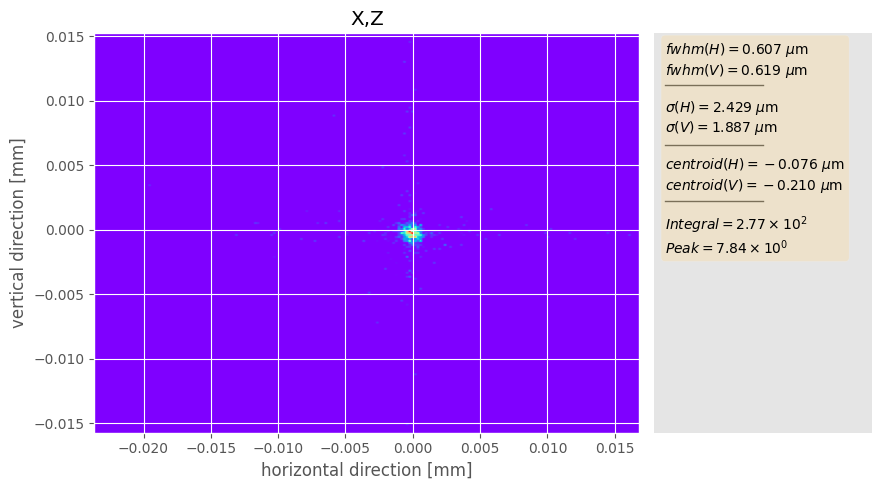

In [160]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

In [141]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [15]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [16]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [98]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'

    
    def motor_subset_loss_function(self, motor_types: list, verbose: bool = True):
        lossfn_object_this = self.TrialInstanceLossFunction(self, verbose=verbose)
        
        translations_all = np.zeros(len(self.motor_types))
        
        def closure_fn(translations):
            for ix, motor in enumerate(motor_types):
                iy = self.motor_types.index(motor)
                translations_all[iy] = translations[ix]
            
            return lossfn_object_this.loss(translations_all)
        return closure_fn
    
    def set_optimizer_options(self, motor_ranges: list=None, base_sampler: optuna.samplers.BaseSampler = None, directions: str = None, **extra_options):
        
        self.motor_ranges = self._get_guess_ranges(motor_ranges)
        
        if base_sampler is None:
            if self.multi_objective_optimization:
                base_sampler = optuna.samplers.MOTPESampler()
            else:
                base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        
        if directions is None:
            directions = ['minimize'] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions
        
        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0. for mt in self.motor_types})
        
        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        
        self.best_params = {k: 0. for k in self.motor_types}
    
    def _objective(self, trial):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
            #print(mot, 'Min, max, resolution', r[0], r[1], resolution)
            current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            loss[np.isnan(loss)] = 1e4
            
            for k in ['sigma', 'fwhm']:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0: loss[width_idx] = 1e4
            loss = list(loss)
            
        return loss
    
    def trials(self, n_trials: int, trial_motor_types: list = None):
        if trial_motor_types is None:
            self.study.optimize(self._objective, n_trials)
            
        else:
            
            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(self._objective, n_trials=n_trials)
            
            self.study.sampler = self._base_sampler
        
        self.best_params.update(self.study.best_trials[0].params)
    
    #def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass
    
    def _optimize(self):
        pass

    #def set_optimizer_options(self):
    #    pass
    

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


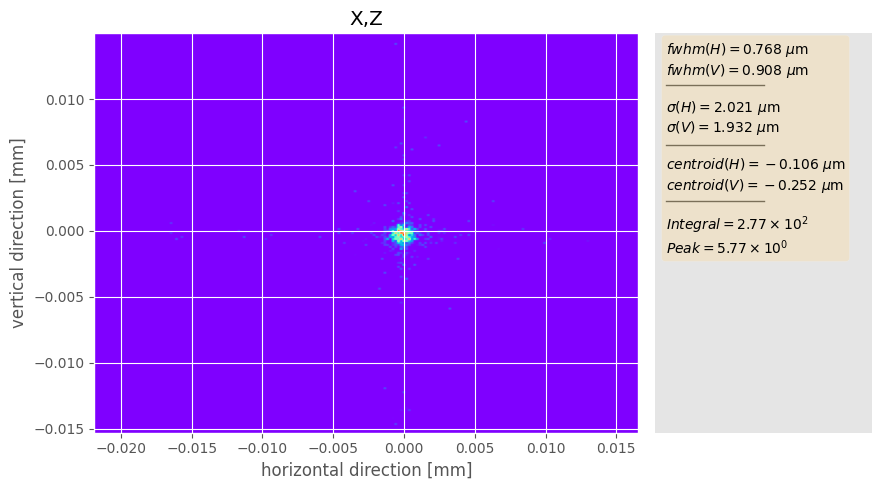

In [165]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4'] [14.251661047875658, -8.295736037176567, 45.912132841619396, 7.660644387693182, 0.011201789615352106, -0.009267993243764129, -12.584471856239247, 21.165665711373165]


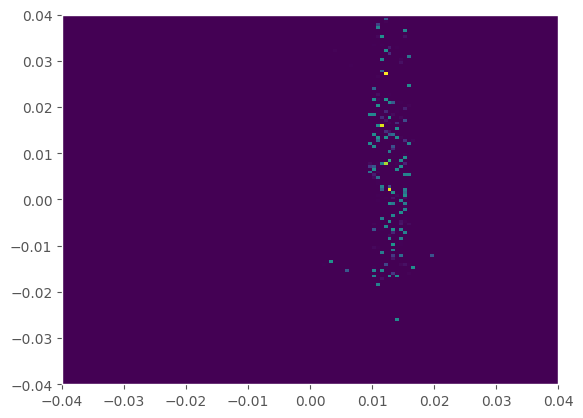

In [166]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, motor_types=list(move_motors_ranges.keys()),
                                                                               init_range=list(move_motors_ranges.values()),
                                                                               xrange=[-0.04, 0.04],yrange=[-0.04,0.04], nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.show()

In [167]:
opt_common.get_centroid_distance(photon_beam=beam)

BeamParameterOutput(parameter_value=0.04031806033150629, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7ff0178685b0>, hist=<beamline34IDC.util.common.Histogram object at 0x7ff016017670>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7ff016017040>)

In [168]:
focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.


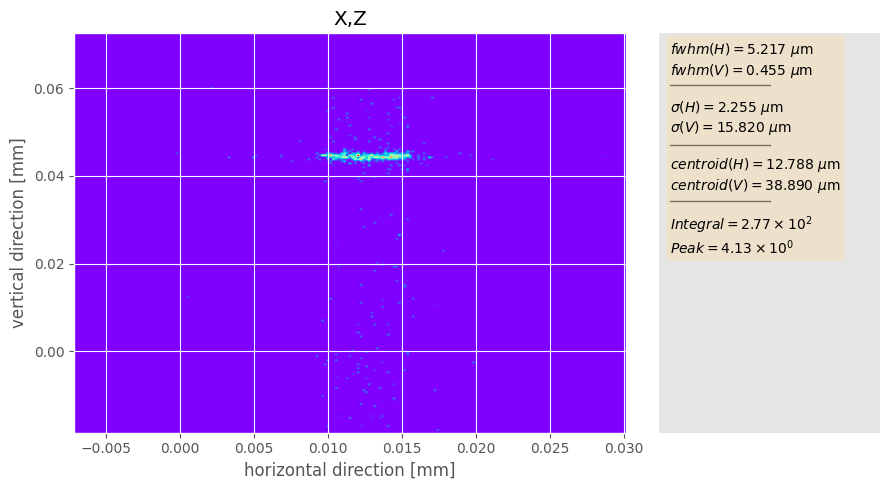

In [169]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [170]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [171]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()))

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_10632/1461133378.py:25: FutureWarning: MOTPESampler has been deprecated in v2.9.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.9.0.
  base_sampler = optuna.samplers.MOTPESampler()
[I 2022-09-23 13:34:36,445] A new study created in memory with name: no-name-37e8f75f-2650-4fe3-bcc6-eaa6cc76d644


In [172]:
centroid_ground, sigma_ground = opt_trial._loss_fn_this(-np.array(initial_movement))
centroid_ground, sigma_ground

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


(0.0002846259084148746, 0.0032497841905851886)

In [173]:
opt_trial._loss_fn_this(np.array(initial_movement))

array([10000., 10000.])

In [181]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_10632/1461133378.py:69: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
[I 2022-09-23 13:52:12,728] Trial 10

In [182]:
opt_trial.study.best_trials

[FrozenTrial(number=69, values=[0.006700377287707333, 0.0029582339397240896], datetime_start=datetime.datetime(2022, 9, 23, 13, 36, 59, 558694), datetime_complete=datetime.datetime(2022, 9, 23, 13, 37, 0, 898164), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.001

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_10632/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


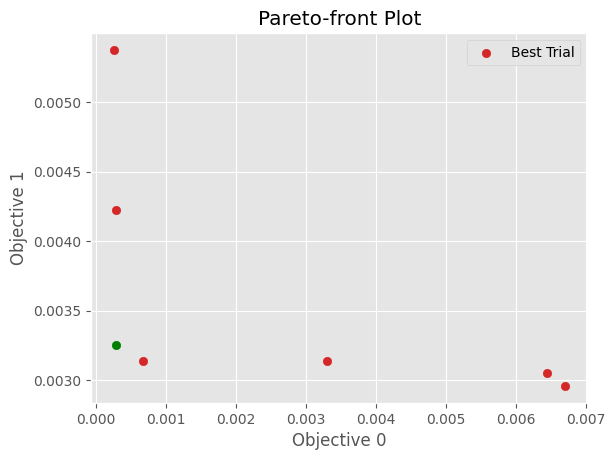

In [187]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [184]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-10.828754273265478
-11.478515865610142
-13.47304146307252
-13.5877265863877
-10.83785522015573
-13.056656952000802


[0.006700377287707333, 0.0029582339397240896]


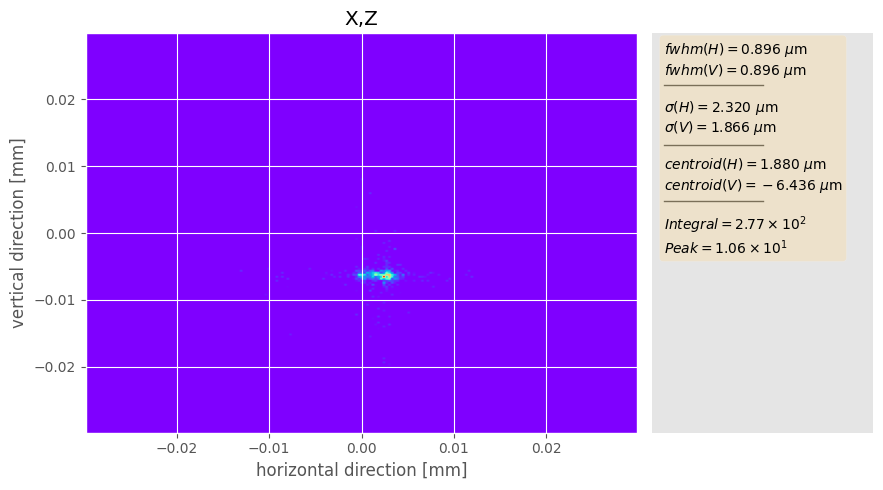

[0.0032976101984621463, 0.003138662232432737]


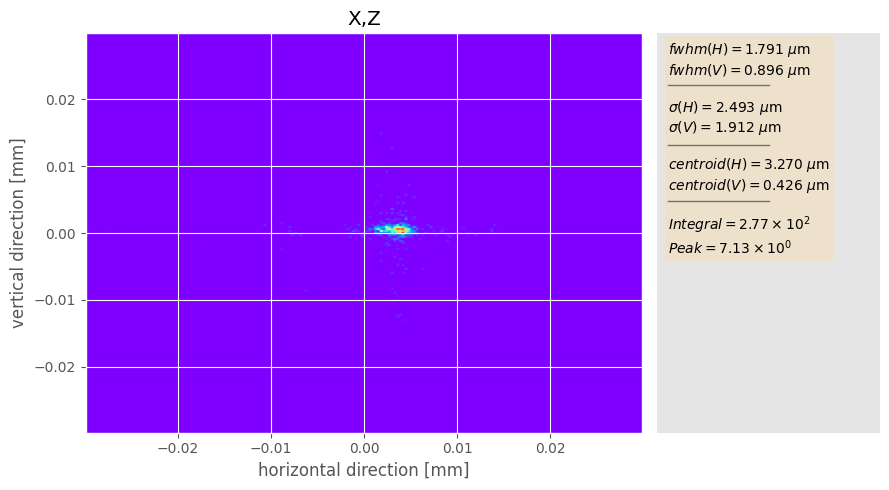

[0.0002619267686708625, 0.005377154968690369]


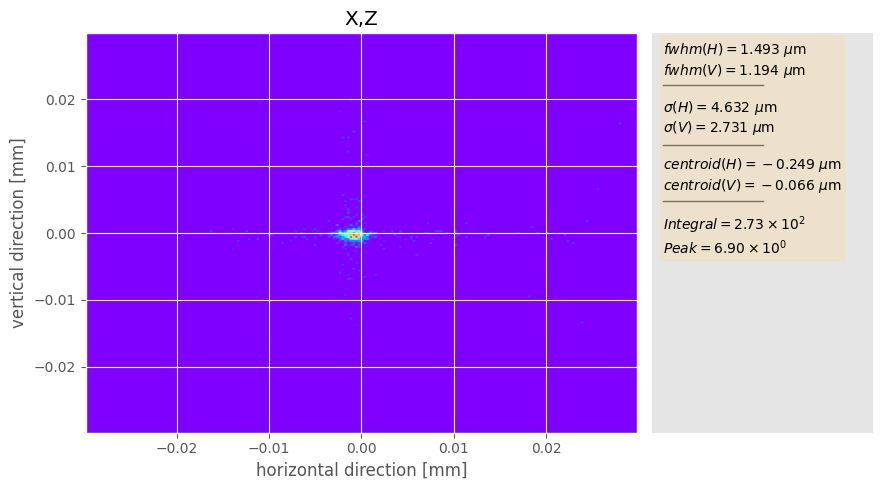

[0.00029701638842888383, 0.0042280966759113674]


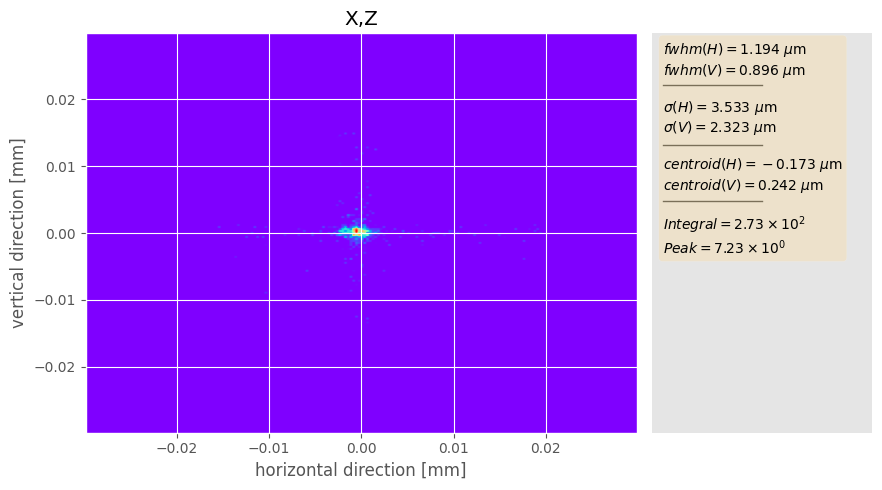

[0.006439418153279333, 0.0030502304667811542]


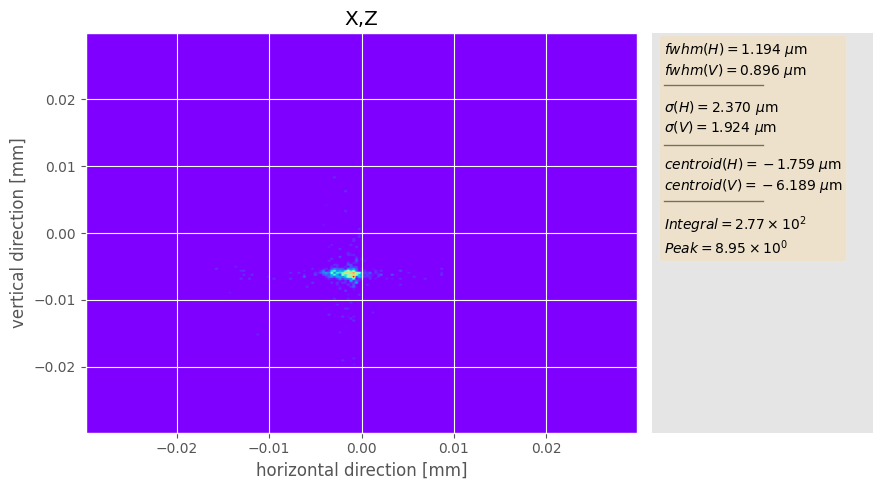

[0.0006803129555658254, 0.003139476178515442]


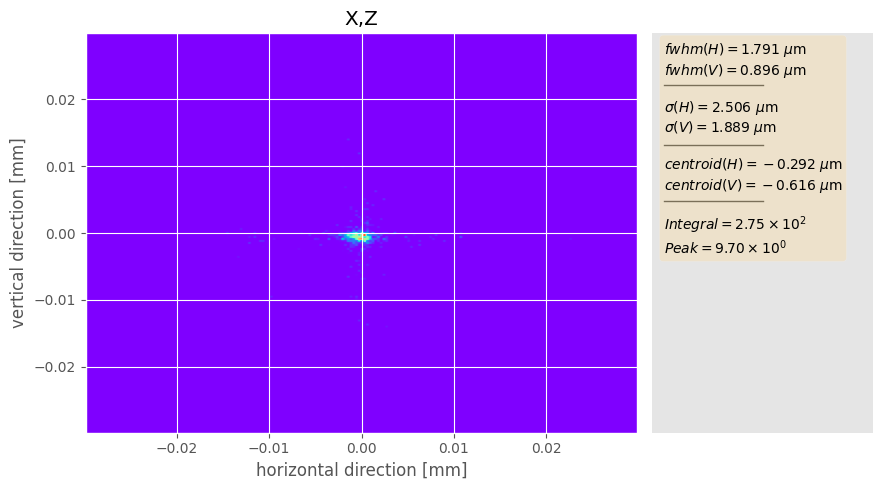

In [186]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [188]:
opt_trial._objective(opt_trial.study.best_trials[3])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


[0.0002970163884293044, 0.004228096675910141]

In [189]:
opt_trial.trials(200, trial_motor_types=['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_10632/1461133378.py:69: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:11,559] Trial 200 finished with values: [0.006673738022726961, 0.0030271260054958453] and parameters: {'hkb_1': -4.9728000000000065, 'vkb_1': -5.892600000000002, 'hkb_2': 4.917899999999996, 'vkb_2': -4.517300000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:13,249] Trial 201 finished with values: [0.006635705315351968, 0.0029725388393496265] and parameters: {'hkb_1': 4.502899999999997, 'vkb_1': 4.783999999999992, 'hkb_2': 5.868999999999993, 'vkb_2': 5.021899999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:14,913] Trial 202 finished with values: [0.006705973936961951, 0.003027526983064344] and parameters: {'hkb_1': -4.382100000000001, 'vkb_1': -4.993100000000005, 'hkb_2': 4.7431999999999945, 'vkb_2': -4.806300000000007, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:16,397] Trial 203 finished with values: [0.006646163387306238, 0.0029680709698415102] and parameters: {'hkb_1': -4.5105000000000075, 'vkb_1': 4.483999999999995, 'hkb_2': -4.858200000000004, 'vkb_2': 4.685199999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:18,038] Trial 204 finished with values: [0.006473778004463904, 0.0029936044697989645] and parameters: {'hkb_1': -5.405900000000003, 'vkb_1': -4.670800000000007, 'hkb_2': 4.421499999999995, 'vkb_2': 4.673399999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:19,535] Trial 205 finished with values: [0.006694189308102084, 0.0029461186689843147] and parameters: {'hkb_1': 5.582499999999996, 'vkb_1': 4.429399999999994, 'hkb_2': -5.697800000000001, 'vkb_2': 5.066699999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:21,017] Trial 206 finished with values: [0.006705542228646151, 0.002947561026924721] and parameters: {'hkb_1': 5.604599999999998, 'vkb_1': 4.515899999999995, 'hkb_2': -5.252300000000005, 'vkb_2': 4.743499999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:22,679] Trial 207 finished with values: [0.006752961329489669, 0.0030142982170246945] and parameters: {'hkb_1': 5.498199999999997, 'vkb_1': -4.596900000000005, 'hkb_2': 4.838999999999999, 'vkb_2': -4.260100000000001, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:24,186] Trial 208 finished with values: [0.006744379661836459, 0.0029462499178147606] and parameters: {'hkb_1': 5.366799999999998, 'vkb_1': 6.5053999999999945, 'hkb_2': -4.916500000000006, 'vkb_2': 4.257999999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:25,699] Trial 209 finished with values: [0.00657555159228744, 0.0029686613975643443] and parameters: {'hkb_1': -5.744900000000001, 'vkb_1': 4.570399999999992, 'hkb_2': -5.143500000000003, 'vkb_2': 7.4295999999999935, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:27,181] Trial 210 finished with values: [0.006715544993968896, 0.0029513911745781703] and parameters: {'hkb_1': 4.977199999999996, 'vkb_1': 4.274999999999999, 'hkb_2': -6.571600000000004, 'vkb_2': 5.819799999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:28,818] Trial 211 finished with values: [0.006648932139326978, 0.0029677903387801906] and parameters: {'hkb_1': -4.567300000000003, 'vkb_1': 5.380599999999994, 'hkb_2': -5.225900000000003, 'vkb_2': 4.693399999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:30,497] Trial 212 finished with values: [0.006500541361585951, 0.003174938944929515] and parameters: {'hkb_1': -45.3903, 'vkb_1': 4.750999999999998, 'hkb_2': -4.349800000000002, 'vkb_2': 4.3714999999999975, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:33,574] Trial 213 finished with values: [0.004576733700234911, 0.0037544061762529294] and parameters: {'hkb_1': -5.215300000000006, 'vkb_1': -49.5251, 'hkb_2': 48.874999999999986, 'vkb_2': 45.559, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:35,696] Trial 214 finished with values: [0.008775423829474974, 0.0033683249032700046] and parameters: {'hkb_1': 44.3013, 'vkb_1': 29.957899999999995, 'hkb_2': -43.3557, 'vkb_2': -45.8783, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:37,481] Trial 215 finished with values: [0.0064049033809699, 0.0030092094198373616] and parameters: {'hkb_1': 7.436199999999992, 'vkb_1': -8.428000000000004, 'hkb_2': 7.552299999999995, 'vkb_2': 7.207999999999998, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:38,978] Trial 216 finished with values: [0.0068442037310474145, 0.003023641947993389] and parameters: {'hkb_1': 3.6820999999999984, 'vkb_1': -8.019400000000005, 'hkb_2': -8.628700000000002, 'vkb_2': -7.432200000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:40,608] Trial 217 finished with values: [0.007211381419836886, 0.0030793268459419765] and parameters: {'hkb_1': -8.456300000000006, 'vkb_1': 45.390399999999985, 'hkb_2': 3.739999999999995, 'vkb_2': 4.532899999999998, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:42,938] Trial 218 finished with values: [0.007039974956017256, 0.0032760920939216773] and parameters: {'hkb_1': 47.51169999999999, 'vkb_1': 4.523199999999996, 'hkb_2': -3.9466000000000037, 'vkb_2': 8.226799999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:44,654] Trial 219 finished with values: [0.004987093330869293, 0.003191173408765632] and parameters: {'hkb_1': 8.632599999999996, 'vkb_1': -41.8023, 'hkb_2': 6.896599999999992, 'vkb_2': 46.389799999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:46,381] Trial 220 finished with values: [0.00724419473823811, 0.003541278351318709] and parameters: {'hkb_1': -3.6791000000000054, 'vkb_1': -29.0041, 'hkb_2': 7.876899999999992, 'vkb_2': -45.1982, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:49,498] Trial 221 finished with values: [0.005617758148431912, 0.003566607873876827] and parameters: {'hkb_1': -29.0176, 'vkb_1': 7.774499999999996, 'hkb_2': 47.1416, 'vkb_2': 34.448199999999986, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:52,214] Trial 222 finished with values: [0.007234052793270808, 0.0035531628875569384] and parameters: {'hkb_1': 3.5611999999999924, 'vkb_1': 3.459399999999995, 'hkb_2': 40.90129999999999, 'vkb_2': -29.1155, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:54,041] Trial 223 finished with values: [0.00754961365348363, 0.0031074913968856784] and parameters: {'hkb_1': 36.0911, 'vkb_1': 10.198399999999992, 'hkb_2': -37.8455, 'vkb_2': -7.515500000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:56,247] Trial 224 finished with values: [0.0068252100468689314, 0.0032291494769238413] and parameters: {'hkb_1': 27.578999999999994, 'vkb_1': -3.4140000000000015, 'hkb_2': 17.62849999999999, 'vkb_2': -3.5426000000000073, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:57,651] Trial 225 finished with values: [0.006148787718196213, 0.0030311032030527693] and parameters: {'hkb_1': -7.176100000000005, 'vkb_1': -10.940700000000007, 'hkb_2': -16.218000000000004, 'vkb_2': 18.36099999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:58:59,202] Trial 226 finished with values: [0.006072633587608621, 0.00301870694225816] and parameters: {'hkb_1': -7.677200000000006, 'vkb_1': -18.890200000000004, 'hkb_2': -3.4802000000000035, 'vkb_2': 14.677999999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:00,547] Trial 227 finished with values: [0.006837578411167305, 0.0030696221881090857] and parameters: {'hkb_1': -7.392400000000002, 'vkb_1': 16.261899999999997, 'hkb_2': -27.8228, 'vkb_2': 7.925199999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:02,907] Trial 228 finished with values: [0.005959703012658314, 0.0032743259819086983] and parameters: {'hkb_1': 14.060699999999997, 'vkb_1': -15.912200000000006, 'hkb_2': 29.589299999999994, 'vkb_2': 17.475099999999998, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:04,402] Trial 229 finished with values: [0.007815316576133711, 0.0031705933986823044] and parameters: {'hkb_1': -26.261000000000003, 'vkb_1': 48.41189999999999, 'hkb_2': -13.3309, 'vkb_2': -17.994800000000005, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:05,988] Trial 230 finished with values: [0.0065685175458259195, 0.003145732852387528] and parameters: {'hkb_1': -14.860700000000001, 'vkb_1': 34.029799999999994, 'hkb_2': -3.1917000000000044, 'vkb_2': 22.7162, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:07,471] Trial 231 finished with values: [0.006817462631601838, 0.003045616558622222] and parameters: {'hkb_1': -3.4691000000000045, 'vkb_1': -3.2849000000000075, 'hkb_2': -19.523200000000003, 'vkb_2': -3.433100000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:09,369] Trial 232 finished with values: [0.00666799271177746, 0.0030901835748405786] and parameters: {'hkb_1': 26.57719999999999, 'vkb_1': -9.4069, 'hkb_2': 3.2423999999999964, 'vkb_2': 3.6288999999999945, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:11,017] Trial 233 finished with values: [0.006803650110899064, 0.003016767488062316] and parameters: {'hkb_1': 3.439299999999996, 'vkb_1': -3.779500000000006, 'hkb_2': 3.3240999999999943, 'vkb_2': -6.3426000000000045, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:12,445] Trial 234 finished with values: [0.006616255041793103, 0.0032399664526722213] and parameters: {'hkb_1': 9.204199999999993, 'vkb_1': -28.071600000000004, 'hkb_2': -49.8298, 'vkb_2': 3.4306999999999945, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:14,219] Trial 235 finished with values: [0.00774943883711486, 0.0031261657150186387] and parameters: {'hkb_1': 3.3152999999999935, 'vkb_1': 21.976, 'hkb_2': 10.336499999999994, 'vkb_2': -34.9729, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:15,950] Trial 236 finished with values: [0.006021812679819832, 0.003218420070052485] and parameters: {'hkb_1': -49.6339, 'vkb_1': -6.887200000000007, 'hkb_2': -3.308000000000007, 'vkb_2': 15.601299999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:17,859] Trial 237 finished with values: [0.006975264583074738, 0.003088542725995809] and parameters: {'hkb_1': -3.5767000000000024, 'vkb_1': 3.248599999999996, 'hkb_2': 16.40599999999999, 'vkb_2': -14.3949, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:19,515] Trial 238 finished with values: [0.006327465519403657, 0.0031745247783081586] and parameters: {'hkb_1': -38.2063, 'vkb_1': -12.4814, 'hkb_2': -6.431500000000007, 'vkb_2': 3.3641999999999967, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:20,904] Trial 239 finished with values: [0.006872853205242778, 0.003129319789077927] and parameters: {'hkb_1': -16.107000000000006, 'vkb_1': 3.5970999999999975, 'hkb_2': -26.483200000000004, 'vkb_2': -3.448500000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:23,193] Trial 240 finished with values: [0.006510253370253311, 0.0031865455440894612] and parameters: {'hkb_1': 6.644899999999993, 'vkb_1': 7.455799999999996, 'hkb_2': 28.94449999999999, 'vkb_2': 6.876499999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:24,713] Trial 241 finished with values: [0.005835203477174908, 0.0030453507490170516] and parameters: {'hkb_1': -3.2343000000000046, 'vkb_1': -3.3390000000000057, 'hkb_2': -4.136600000000001, 'vkb_2': 32.43669999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:26,444] Trial 242 finished with values: [0.007407594760129151, 0.003163884005297847] and parameters: {'hkb_1': 23.44319999999999, 'vkb_1': -3.2924000000000007, 'hkb_2': -3.278000000000006, 'vkb_2': -24.991500000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:28,190] Trial 243 finished with values: [0.005447011132411759, 0.003117805714460099] and parameters: {'hkb_1': 16.97189999999999, 'vkb_1': -30.5639, 'hkb_2': 3.841299999999997, 'vkb_2': 37.276099999999985, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:29,834] Trial 244 finished with values: [0.005540452460933722, 0.003060092479100651] and parameters: {'hkb_1': -3.2109000000000023, 'vkb_1': -24.221200000000003, 'hkb_2': 3.4310999999999936, 'vkb_2': 31.76379999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:31,460] Trial 245 finished with values: [0.0063962608265791185, 0.0033065099529792355] and parameters: {'hkb_1': -3.5068000000000055, 'vkb_1': 41.1592, 'hkb_2': 3.2597999999999985, 'vkb_2': 34.724999999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:33,773] Trial 246 finished with values: [0.005409535276428721, 0.0032589615280550436] and parameters: {'hkb_1': -3.2961000000000027, 'vkb_1': -21.518200000000004, 'hkb_2': 30.4315, 'vkb_2': 32.32409999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:36,213] Trial 247 finished with values: [0.0066897787311519024, 0.003289529524020919] and parameters: {'hkb_1': -7.866500000000002, 'vkb_1': -3.3863000000000056, 'hkb_2': 33.946299999999994, 'vkb_2': -9.917000000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:37,931] Trial 248 finished with values: [0.0063604324327790444, 0.003206138798782786] and parameters: {'hkb_1': 14.94319999999999, 'vkb_1': -39.4209, 'hkb_2': 3.3284999999999982, 'vkb_2': -3.118700000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:39,954] Trial 249 finished with values: [0.006851316742661165, 0.00311418348663569] and parameters: {'hkb_1': 38.75229999999999, 'vkb_1': 3.543599999999998, 'hkb_2': -9.136200000000002, 'vkb_2': 12.007099999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:41,486] Trial 250 finished with values: [0.00671018592775882, 0.002951259888388988] and parameters: {'hkb_1': 3.2242999999999924, 'vkb_1': 2.907499999999999, 'hkb_2': -3.6351000000000013, 'vkb_2': 3.1581999999999937, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:43,710] Trial 251 finished with values: [0.005778150930152771, 0.003128766415713531] and parameters: {'hkb_1': -6.097300000000004, 'vkb_1': -3.3260000000000076, 'hkb_2': 23.107799999999997, 'vkb_2': 28.0907, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:45,873] Trial 252 finished with values: [0.007002457024254022, 0.0031141820133962226] and parameters: {'hkb_1': -33.75020000000001, 'vkb_1': 28.986799999999988, 'hkb_2': 21.280699999999996, 'vkb_2': -3.3985000000000056, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:47,578] Trial 253 finished with values: [0.006461978784695736, 0.0030329725544910335] and parameters: {'hkb_1': -20.812200000000004, 'vkb_1': -3.5091000000000037, 'hkb_2': 3.571399999999997, 'vkb_2': 3.027699999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:49,127] Trial 254 finished with values: [0.0072011580679240935, 0.003414285898748593] and parameters: {'hkb_1': -5.452000000000005, 'vkb_1': -24.753500000000003, 'hkb_2': -3.311000000000007, 'vkb_2': -38.1205, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:50,553] Trial 255 finished with values: [0.006907352103137194, 0.002984053634076405] and parameters: {'hkb_1': -2.9868000000000023, 'vkb_1': 16.736499999999992, 'hkb_2': -15.525500000000001, 'vkb_2': 3.1588999999999956, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:52,082] Trial 256 finished with values: [0.005801953586196759, 0.0031048862010628854] and parameters: {'hkb_1': 3.3196999999999974, 'vkb_1': 3.2283999999999935, 'hkb_2': -5.716700000000003, 'vkb_2': 38.938199999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:53,732] Trial 257 finished with values: [0.006918719321588417, 0.003316774340843116] and parameters: {'hkb_1': 19.619199999999992, 'vkb_1': -35.217600000000004, 'hkb_2': -5.588900000000002, 'vkb_2': -21.277600000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:55,254] Trial 258 finished with values: [0.0062039615852116075, 0.0036152169832962956] and parameters: {'hkb_1': -42.1497, 'vkb_1': -47.2931, 'hkb_2': -32.641400000000004, 'vkb_2': -5.710500000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 13:59:56,791] Trial 259 finished with values: [0.007502218069164829, 0.002999547342825867] and parameters: {'hkb_1': -2.8660000000000068, 'vkb_1': 38.38619999999999, 'hkb_2': -3.197900000000004, 'vkb_2': -9.387800000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:00,165] Trial 260 finished with values: [0.005648025541063935, 0.003975353545061731] and parameters: {'hkb_1': 34.9623, 'vkb_1': 3.1809999999999974, 'hkb_2': 44.365599999999986, 'vkb_2': 39.1964, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:01,820] Trial 261 finished with values: [0.00615863074226199, 0.0029879486838912672] and parameters: {'hkb_1': 3.4058999999999955, 'vkb_1': -3.249600000000001, 'hkb_2': 3.312199999999997, 'vkb_2': 21.123599999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:04,518] Trial 262 finished with values: [0.0065009286315422365, 0.0033549157819020895] and parameters: {'hkb_1': -10.521600000000007, 'vkb_1': -3.145000000000003, 'hkb_2': 39.489999999999995, 'vkb_2': -3.0457000000000036, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:06,198] Trial 263 finished with values: [0.006241861177770466, 0.003007040760835909] and parameters: {'hkb_1': 3.6698999999999984, 'vkb_1': -16.574600000000004, 'hkb_2': 3.433499999999995, 'vkb_2': 10.352499999999992, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:07,606] Trial 264 finished with values: [0.006092377767340956, 0.0030320079885018236] and parameters: {'hkb_1': 3.428299999999993, 'vkb_1': -16.633100000000006, 'hkb_2': -21.940700000000003, 'vkb_2': 22.374799999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:09,282] Trial 265 finished with values: [0.007866269105535584, 0.003308029890337355] and parameters: {'hkb_1': 3.040399999999998, 'vkb_1': 6.403899999999993, 'hkb_2': 3.1513999999999953, 'vkb_2': -49.5027, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:11,094] Trial 266 finished with values: [0.006069318614687987, 0.0030289235079007403] and parameters: {'hkb_1': 3.2009999999999934, 'vkb_1': 2.998599999999996, 'hkb_2': 10.557199999999995, 'vkb_2': 24.0753, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:12,679] Trial 267 finished with values: [0.005831301742857256, 0.0030098421590899547] and parameters: {'hkb_1': 3.9329999999999927, 'vkb_1': -18.8744, 'hkb_2': -2.8956000000000017, 'vkb_2': 26.58829999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:14,322] Trial 268 finished with values: [0.006379246931921862, 0.0029780697950691644] and parameters: {'hkb_1': -3.001500000000007, 'vkb_1': -5.148900000000005, 'hkb_2': -3.0109000000000066, 'vkb_2': 10.916899999999991, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:15,818] Trial 269 finished with values: [0.007799096963944693, 0.00308796876416748] and parameters: {'hkb_1': -3.6996000000000038, 'vkb_1': 23.22359999999999, 'hkb_2': -7.903400000000005, 'vkb_2': -33.7241, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:18,309] Trial 270 finished with values: [0.006858668440623233, 0.00340154064107183] and parameters: {'hkb_1': 49.894499999999994, 'vkb_1': -20.900100000000002, 'hkb_2': -3.2439000000000036, 'vkb_2': 3.5241999999999933, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:20,069] Trial 271 finished with values: [0.006962391892436439, 0.0031130868512925444] and parameters: {'hkb_1': 29.57029999999999, 'vkb_1': -5.740500000000004, 'hkb_2': -49.0561, 'vkb_2': 9.549699999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:21,855] Trial 272 finished with values: [0.0068216919392333104, 0.0030265106169312943] and parameters: {'hkb_1': -22.047700000000003, 'vkb_1': 11.328899999999997, 'hkb_2': 3.226299999999995, 'vkb_2': -2.9265000000000043, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:23,436] Trial 273 finished with values: [0.0069767925201986, 0.0030516044310756217] and parameters: {'hkb_1': -2.8248000000000033, 'vkb_1': -3.9779000000000053, 'hkb_2': -3.026900000000005, 'vkb_2': -13.509800000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:25,125] Trial 274 finished with values: [0.006412096562141784, 0.0033245535511219654] and parameters: {'hkb_1': -32.9901, 'vkb_1': -3.0083000000000055, 'hkb_2': -37.4033, 'vkb_2': 10.371999999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:26,804] Trial 275 finished with values: [0.0055744975959318935, 0.003056638122970324] and parameters: {'hkb_1': 2.9588999999999928, 'vkb_1': -31.276000000000003, 'hkb_2': 2.887299999999996, 'vkb_2': 28.977599999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:28,462] Trial 276 finished with values: [0.004908405981436777, 0.003195531086084114] and parameters: {'hkb_1': -2.884200000000007, 'vkb_1': -37.0997, 'hkb_2': 2.721899999999998, 'vkb_2': 49.150699999999986, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:30,106] Trial 277 finished with values: [0.006336421442810797, 0.003212429886207765] and parameters: {'hkb_1': 10.702199999999998, 'vkb_1': -43.4773, 'hkb_2': -2.981800000000007, 'vkb_2': -3.231900000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:31,766] Trial 278 finished with values: [0.006122043952049797, 0.0030947456936136677] and parameters: {'hkb_1': -3.3109000000000037, 'vkb_1': -31.5529, 'hkb_2': 2.875799999999998, 'vkb_2': 5.629399999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:33,158] Trial 279 finished with values: [0.006892754145733933, 0.0030902078037514406] and parameters: {'hkb_1': 2.9679999999999964, 'vkb_1': 3.3544999999999945, 'hkb_2': -39.8543, 'vkb_2': 3.3193999999999946, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:35,312] Trial 280 finished with values: [0.007173306727662383, 0.003209364173551157] and parameters: {'hkb_1': 39.9096, 'vkb_1': -2.7831000000000046, 'hkb_2': -3.150500000000001, 'vkb_2': -6.386000000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:37,068] Trial 281 finished with values: [0.007248788225361521, 0.0030605959350795886] and parameters: {'hkb_1': 31.3082, 'vkb_1': 2.9420999999999964, 'hkb_2': -30.1446, 'vkb_2': -2.9232000000000014, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:38,925] Trial 282 finished with values: [0.007032329277560922, 0.00301217323955841] and parameters: {'hkb_1': 19.5903, 'vkb_1': 21.118199999999987, 'hkb_2': 5.321899999999992, 'vkb_2': 2.708999999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:41,541] Trial 283 finished with values: [0.00675294393171079, 0.0033451639718816125] and parameters: {'hkb_1': 2.786299999999997, 'vkb_1': 5.875999999999998, 'hkb_2': 37.481899999999996, 'vkb_2': -5.471600000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:42,938] Trial 284 finished with values: [0.007601540559055406, 0.003313872252934946] and parameters: {'hkb_1': -3.0671000000000035, 'vkb_1': 3.2098999999999975, 'hkb_2': -43.4236, 'vkb_2': -28.6137, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:45,159] Trial 285 finished with values: [0.007861590326626238, 0.0032897867992110574] and parameters: {'hkb_1': -2.899800000000006, 'vkb_1': 25.77539999999999, 'hkb_2': 26.623099999999994, 'vkb_2': -41.0891, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:47,023] Trial 286 finished with values: [0.005734990873469166, 0.0032290934063480344] and parameters: {'hkb_1': -49.9452, 'vkb_1': -3.347200000000001, 'hkb_2': 2.755999999999993, 'vkb_2': 26.8112, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:48,610] Trial 287 finished with values: [0.006902417322190332, 0.002945625906555506] and parameters: {'hkb_1': 3.120899999999999, 'vkb_1': 17.173299999999998, 'hkb_2': -2.663000000000004, 'vkb_2': 3.0082999999999984, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:50,025] Trial 288 finished with values: [0.006759971184855602, 0.003110089027370739] and parameters: {'hkb_1': -13.261600000000001, 'vkb_1': -3.1019000000000077, 'hkb_2': -23.372300000000003, 'vkb_2': -2.5775000000000077, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:51,500] Trial 289 finished with values: [0.006615686619628781, 0.0029818754160452036] and parameters: {'hkb_1': 2.8334999999999937, 'vkb_1': -6.023800000000001, 'hkb_2': -11.191400000000002, 'vkb_2': 3.3362999999999943, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:53,520] Trial 290 finished with values: [0.007044637096584654, 0.003082739714940749] and parameters: {'hkb_1': -19.628200000000003, 'vkb_1': 37.9019, 'hkb_2': 16.546699999999987, 'vkb_2': 2.919399999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:55,104] Trial 291 finished with values: [0.007566162244621561, 0.0030533022763420516] and parameters: {'hkb_1': 2.852499999999992, 'vkb_1': 48.73559999999999, 'hkb_2': -2.9040000000000035, 'vkb_2': -3.1648000000000067, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:56,793] Trial 292 finished with values: [0.006356989184951469, 0.0029752789625585746] and parameters: {'hkb_1': 5.196699999999993, 'vkb_1': -2.702700000000007, 'hkb_2': 3.1976999999999975, 'vkb_2': 13.410699999999991, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:00:58,465] Trial 293 finished with values: [0.005663615296065367, 0.003254657515694754] and parameters: {'hkb_1': -27.4676, 'vkb_1': 11.126799999999996, 'hkb_2': -3.1744000000000057, 'vkb_2': 40.78869999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:00,706] Trial 294 finished with values: [0.005897625149707082, 0.0031423319766562597] and parameters: {'hkb_1': -2.806500000000007, 'vkb_1': 2.741799999999998, 'hkb_2': 23.336099999999988, 'vkb_2': 28.08059999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:03,007] Trial 295 finished with values: [0.00778306472968976, 0.0032779777942895444] and parameters: {'hkb_1': 43.102199999999996, 'vkb_1': 14.879099999999994, 'hkb_2': -3.217000000000006, 'vkb_2': -22.1898, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:04,401] Trial 296 finished with values: [0.006944611430438651, 0.003085009054172043] and parameters: {'hkb_1': 5.240199999999994, 'vkb_1': -3.2002000000000024, 'hkb_2': -34.3099, 'vkb_2': -3.1393000000000058, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:06,050] Trial 297 finished with values: [0.007024306166683924, 0.0030938490846283665] and parameters: {'hkb_1': 20.769299999999987, 'vkb_1': -2.9148000000000067, 'hkb_2': -47.1635, 'vkb_2': 3.066599999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:07,825] Trial 298 finished with values: [0.005361887844834464, 0.0031267155655712244] and parameters: {'hkb_1': -23.331100000000003, 'vkb_1': -32.5762, 'hkb_2': 2.880499999999998, 'vkb_2': 30.67349999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:09,896] Trial 299 finished with values: [0.007280848536461495, 0.003179117479403524] and parameters: {'hkb_1': -39.755700000000004, 'vkb_1': 45.11959999999999, 'hkb_2': 14.30619999999999, 'vkb_2': -2.8930000000000007, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:11,594] Trial 300 finished with values: [0.005457981026380607, 0.003075220548391825] and parameters: {'hkb_1': -2.781000000000006, 'vkb_1': -34.0319, 'hkb_2': 2.9040999999999926, 'vkb_2': 30.368599999999986, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:13,329] Trial 301 finished with values: [0.00672873002619726, 0.002983082450294447] and parameters: {'hkb_1': 13.531299999999995, 'vkb_1': 2.435999999999993, 'hkb_2': 2.491799999999998, 'vkb_2': 2.805899999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:15,011] Trial 302 finished with values: [0.00666107440893963, 0.002978148885841485] and parameters: {'hkb_1': 2.9206999999999965, 'vkb_1': 18.995099999999994, 'hkb_2': 2.830999999999996, 'vkb_2': 12.743799999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:16,773] Trial 303 finished with values: [0.007119995933033, 0.003042825504617819] and parameters: {'hkb_1': -24.463300000000004, 'vkb_1': 30.7474, 'hkb_2': 2.880599999999994, 'vkb_2': -2.733700000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:18,369] Trial 304 finished with values: [0.007566636439748568, 0.0029806399716121547] and parameters: {'hkb_1': 2.559199999999997, 'vkb_1': 33.31179999999999, 'hkb_2': -3.0823000000000036, 'vkb_2': -14.261100000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:21,101] Trial 305 finished with values: [0.006626090198258663, 0.0033944109989355064] and parameters: {'hkb_1': 16.952699999999993, 'vkb_1': -2.530000000000001, 'hkb_2': 34.90939999999999, 'vkb_2': -2.860200000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:22,763] Trial 306 finished with values: [0.006027597703853946, 0.0032117312682527995] and parameters: {'hkb_1': -11.246400000000001, 'vkb_1': -45.216300000000004, 'hkb_2': -3.0442000000000036, 'vkb_2': 2.830599999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:24,597] Trial 307 finished with values: [0.005439898804127755, 0.0032531004652340215] and parameters: {'hkb_1': -32.4795, 'vkb_1': 2.5788999999999973, 'hkb_2': 2.9314999999999927, 'vkb_2': 42.055199999999985, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:26,219] Trial 308 finished with values: [0.006647049042985498, 0.0029716872056177275] and parameters: {'hkb_1': -2.9337000000000018, 'vkb_1': 2.7609999999999957, 'hkb_2': -2.865300000000005, 'vkb_2': 3.195299999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:29,233] Trial 309 finished with values: [0.005332270538114874, 0.003529246358575772] and parameters: {'hkb_1': -3.035100000000007, 'vkb_1': -19.523200000000003, 'hkb_2': 44.084599999999995, 'vkb_2': 32.898799999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:30,805] Trial 310 finished with values: [0.0068872190953995025, 0.003591370377680862] and parameters: {'hkb_1': -36.0084, 'vkb_1': -33.314800000000005, 'hkb_2': -19.7036, 'vkb_2': -29.727800000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:33,081] Trial 311 finished with values: [0.0059181185411276436, 0.0031718130488432405] and parameters: {'hkb_1': 3.0320999999999927, 'vkb_1': 5.410099999999993, 'hkb_2': 24.59339999999999, 'vkb_2': 27.873899999999992, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:35,220] Trial 312 finished with values: [0.006679759789697916, 0.003133705805103354] and parameters: {'hkb_1': -43.8667, 'vkb_1': 8.873699999999992, 'hkb_2': 12.847099999999998, 'vkb_2': -2.7017000000000024, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:37,346] Trial 313 finished with values: [0.005850543754186487, 0.003192488275786539] and parameters: {'hkb_1': 31.938299999999998, 'vkb_1': -26.874200000000002, 'hkb_2': 2.9536999999999978, 'vkb_2': 30.510499999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:39,337] Trial 314 finished with values: [0.007118883123972377, 0.003176278093938839] and parameters: {'hkb_1': 22.843599999999995, 'vkb_1': -13.933900000000001, 'hkb_2': -2.745500000000007, 'vkb_2': -18.651500000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:40,945] Trial 315 finished with values: [0.007135083906137784, 0.0035916953036117744] and parameters: {'hkb_1': -5.789900000000003, 'vkb_1': -39.223, 'hkb_2': -5.370400000000004, 'vkb_2': -41.557900000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:42,396] Trial 316 finished with values: [0.007302928770791063, 0.003142915473953599] and parameters: {'hkb_1': -2.717000000000006, 'vkb_1': 25.98299999999999, 'hkb_2': -42.4335, 'vkb_2': -2.5663000000000054, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:44,265] Trial 317 finished with values: [0.007277746734952153, 0.0032883402098255123] and parameters: {'hkb_1': -29.797600000000003, 'vkb_1': -2.5227000000000075, 'hkb_2': 2.9617999999999967, 'vkb_2': -33.6131, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:45,974] Trial 318 finished with values: [0.006584171513081745, 0.0030171553316459855] and parameters: {'hkb_1': -18.673800000000004, 'vkb_1': 2.4395999999999987, 'hkb_2': -2.903000000000006, 'vkb_2': 2.6554999999999964, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:47,774] Trial 319 finished with values: [0.00726874287249711, 0.0031420253748219804] and parameters: {'hkb_1': 2.9705999999999975, 'vkb_1': -2.755600000000001, 'hkb_2': 2.7434999999999974, 'vkb_2': -27.033700000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:49,914] Trial 320 finished with values: [0.005564441979718623, 0.0031598688198541092] and parameters: {'hkb_1': -2.738200000000006, 'vkb_1': -2.7623000000000033, 'hkb_2': 19.140299999999996, 'vkb_2': 36.606399999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:52,479] Trial 321 finished with values: [0.0065485643892857085, 0.0032392907302652724] and parameters: {'hkb_1': -2.990300000000005, 'vkb_1': -2.9133000000000067, 'hkb_2': 32.3912, 'vkb_2': -2.6432000000000073, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:54,114] Trial 322 finished with values: [0.0067139341315848354, 0.00295315001784595] and parameters: {'hkb_1': 2.882099999999994, 'vkb_1': 2.481999999999992, 'hkb_2': -6.247900000000001, 'vkb_2': 2.898299999999992, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:55,992] Trial 323 finished with values: [0.005742790537045649, 0.003334356702148262] and parameters: {'hkb_1': -47.3268, 'vkb_1': 12.764099999999992, 'hkb_2': -2.657200000000003, 'vkb_2': 36.37089999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:57,539] Trial 324 finished with values: [0.006538332115128369, 0.003045480344063633] and parameters: {'hkb_1': 10.975999999999992, 'vkb_1': 2.8123999999999967, 'hkb_2': -33.049400000000006, 'vkb_2': 20.331199999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:01:59,222] Trial 325 finished with values: [0.00749225292294472, 0.003518272006383092] and parameters: {'hkb_1': 2.8160999999999987, 'vkb_1': -23.245800000000003, 'hkb_2': -2.735200000000006, 'vkb_2': -48.8745, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:01,362] Trial 326 finished with values: [0.006546496256142208, 0.0030532821952025824] and parameters: {'hkb_1': -2.607300000000002, 'vkb_1': 3.0418999999999983, 'hkb_2': 19.71029999999999, 'vkb_2': 2.508499999999998, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:02,873] Trial 327 finished with values: [0.006434725707981863, 0.003319257810946939] and parameters: {'hkb_1': 5.574799999999996, 'vkb_1': 36.26049999999999, 'hkb_2': -23.863300000000002, 'vkb_2': 37.692899999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:04,514] Trial 328 finished with values: [0.006204472709109164, 0.003428871884743971] and parameters: {'hkb_1': 2.5071999999999974, 'vkb_1': 40.574299999999994, 'hkb_2': -5.116000000000007, 'vkb_2': 44.2011, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:06,083] Trial 329 finished with values: [0.006412321531119914, 0.0029778109816648336] and parameters: {'hkb_1': 2.683399999999999, 'vkb_1': -2.568400000000004, 'hkb_2': -15.968400000000003, 'vkb_2': 15.041799999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:07,848] Trial 330 finished with values: [0.006382456525895559, 0.0030415889601169426] and parameters: {'hkb_1': -2.5871000000000066, 'vkb_1': -18.820500000000003, 'hkb_2': 2.632399999999997, 'vkb_2': 2.7963999999999984, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:09,627] Trial 331 finished with values: [0.007409112611447203, 0.003157736514545491] and parameters: {'hkb_1': -2.5128000000000057, 'vkb_1': 2.7649999999999935, 'hkb_2': 2.414899999999996, 'vkb_2': -31.460600000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:11,322] Trial 332 finished with values: [0.0070420979779732855, 0.0030087158099440076] and parameters: {'hkb_1': 2.507099999999994, 'vkb_1': 3.0693999999999946, 'hkb_2': -2.696300000000001, 'vkb_2': -12.276000000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:12,949] Trial 333 finished with values: [0.005361730726994924, 0.0033156815172649553] and parameters: {'hkb_1': -16.423100000000005, 'vkb_1': 2.402799999999992, 'hkb_2': -11.368900000000004, 'vkb_2': 49.629699999999985, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:14,817] Trial 334 finished with values: [0.007341358434226793, 0.0030923432145852263] and parameters: {'hkb_1': -22.833700000000004, 'vkb_1': 44.501599999999996, 'hkb_2': 2.705699999999993, 'vkb_2': -2.823500000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:17,314] Trial 335 finished with values: [0.0075116468317133, 0.0037407300621256317] and parameters: {'hkb_1': 43.13629999999999, 'vkb_1': -31.5959, 'hkb_2': 2.579199999999993, 'vkb_2': -40.4966, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:20,601] Trial 336 finished with values: [0.005760211553499657, 0.0038203084121744345] and parameters: {'hkb_1': -2.9207000000000036, 'vkb_1': -49.9791, 'hkb_2': 49.98009999999999, 'vkb_2': 2.684199999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:22,452] Trial 337 finished with values: [0.007143211521001251, 0.003088311263860223] and parameters: {'hkb_1': 2.6230999999999938, 'vkb_1': -2.995200000000004, 'hkb_2': -2.598300000000002, 'vkb_2': -19.305500000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:24,083] Trial 338 finished with values: [0.006701064778800351, 0.003327299336821607] and parameters: {'hkb_1': -38.0232, 'vkb_1': -2.5952000000000055, 'hkb_2': -28.893700000000003, 'vkb_2': -4.398300000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:26,748] Trial 339 finished with values: [0.007557969119178679, 0.0034930196052882947] and parameters: {'hkb_1': 46.53899999999999, 'vkb_1': -2.489200000000004, 'hkb_2': 5.2775999999999925, 'vkb_2': -23.861300000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:29,971] Trial 340 finished with values: [0.007238020208684777, 0.003554384681436697] and parameters: {'hkb_1': 4.417199999999994, 'vkb_1': 25.32629999999999, 'hkb_2': 45.60509999999999, 'vkb_2': -15.863500000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:31,502] Trial 341 finished with values: [0.0066436944771477895, 0.0032271416828752973] and parameters: {'hkb_1': -2.6219000000000037, 'vkb_1': -17.4756, 'hkb_2': -45.8976, 'vkb_2': 2.3981999999999957, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:33,745] Trial 342 finished with values: [0.007120887420947469, 0.0031477298100506083] and parameters: {'hkb_1': 36.8116, 'vkb_1': 2.587999999999994, 'hkb_2': -2.518900000000002, 'vkb_2': -3.0408000000000044, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:36,638] Trial 343 finished with values: [0.0064428058393090895, 0.0033726833852548324] and parameters: {'hkb_1': 2.763699999999993, 'vkb_1': 5.432999999999993, 'hkb_2': 39.77829999999999, 'vkb_2': 5.708899999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:39,651] Trial 344 finished with values: [0.007665869271977527, 0.0035948894669079897] and parameters: {'hkb_1': 5.899799999999992, 'vkb_1': 19.30879999999999, 'hkb_2': 42.0038, 'vkb_2': -38.633, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:42,188] Trial 345 finished with values: [0.005714996233282173, 0.003210945591381281] and parameters: {'hkb_1': -41.6897, 'vkb_1': -2.4355000000000047, 'hkb_2': 26.68119999999999, 'vkb_2': 26.010899999999992, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:43,957] Trial 346 finished with values: [0.006644006758002286, 0.0029733616037657907] and parameters: {'hkb_1': -2.5670000000000073, 'vkb_1': 2.563999999999993, 'hkb_2': 2.758199999999995, 'vkb_2': 2.461899999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:46,021] Trial 347 finished with values: [0.006082049983002679, 0.003118086997644082] and parameters: {'hkb_1': 26.5792, 'vkb_1': -2.717800000000004, 'hkb_2': 2.5763999999999925, 'vkb_2': 30.710199999999986, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:47,552] Trial 348 finished with values: [0.006956954694886427, 0.003029950624982556] and parameters: {'hkb_1': 2.495299999999993, 'vkb_1': 2.608099999999993, 'hkb_2': -25.7909, 'vkb_2': -2.922400000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:49,074] Trial 349 finished with values: [0.006737605881698422, 0.003118912615898799] and parameters: {'hkb_1': -2.600600000000007, 'vkb_1': -5.272800000000004, 'hkb_2': -36.0195, 'vkb_2': 2.826199999999993, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:50,613] Trial 350 finished with values: [0.0074023799392682514, 0.003055188677000107] and parameters: {'hkb_1': 2.5741999999999976, 'vkb_1': 42.806799999999996, 'hkb_2': -19.8942, 'vkb_2': 2.4939999999999927, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:52,370] Trial 351 finished with values: [0.006751076786416694, 0.0029849914632689716] and parameters: {'hkb_1': 2.4491999999999976, 'vkb_1': -2.958900000000007, 'hkb_2': -2.3634000000000057, 'vkb_2': -2.5206000000000017, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:54,010] Trial 352 finished with values: [0.00681740291970086, 0.0031699969567440074] and parameters: {'hkb_1': 16.528099999999995, 'vkb_1': -24.3031, 'hkb_2': -39.602900000000005, 'vkb_2': -2.7573000000000008, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:55,915] Trial 353 finished with values: [0.007344203397649036, 0.0033261408987450836] and parameters: {'hkb_1': -30.908, 'vkb_1': -2.6234000000000037, 'hkb_2': 2.9135999999999953, 'vkb_2': -37.054100000000005, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:57,573] Trial 354 finished with values: [0.007685421473718582, 0.003259185439451761] and parameters: {'hkb_1': -2.521100000000004, 'vkb_1': 2.6248999999999967, 'hkb_2': -4.668500000000002, 'vkb_2': -43.2571, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:02:59,544] Trial 355 finished with values: [0.00654506230118145, 0.003120149932094728] and parameters: {'hkb_1': -36.102900000000005, 'vkb_1': -2.8529000000000053, 'hkb_2': 4.908899999999996, 'vkb_2': -2.6363000000000056, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:01,947] Trial 356 finished with values: [0.007188620009464441, 0.003207419410299501] and parameters: {'hkb_1': 25.046499999999995, 'vkb_1': 33.9837, 'hkb_2': 19.03779999999999, 'vkb_2': 2.409399999999998, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:03,441] Trial 357 finished with values: [0.007064719071819878, 0.0031317095845250437] and parameters: {'hkb_1': -2.4285000000000068, 'vkb_1': -2.5187000000000026, 'hkb_2': -31.0408, 'vkb_2': -10.580300000000001, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:05,303] Trial 358 finished with values: [0.006569685751845584, 0.00299050906314816] and parameters: {'hkb_1': -11.526100000000007, 'vkb_1': 2.9313999999999965, 'hkb_2': -2.312800000000003, 'vkb_2': 4.882999999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:07,488] Trial 359 finished with values: [0.006852901608661007, 0.0031863465722054116] and parameters: {'hkb_1': 32.18039999999999, 'vkb_1': 28.226899999999986, 'hkb_2': 2.4524999999999935, 'vkb_2': 19.85069999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:09,717] Trial 360 finished with values: [0.006551396574351014, 0.003167705325003977] and parameters: {'hkb_1': 4.765199999999993, 'vkb_1': -13.874200000000002, 'hkb_2': 21.393699999999995, 'vkb_2': -5.505500000000005, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:12,657] Trial 361 finished with values: [0.005829582845940152, 0.0034472688643822414] and parameters: {'hkb_1': -46.5358, 'vkb_1': -41.5267, 'hkb_2': 34.88059999999999, 'vkb_2': 2.6461999999999932, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:14,374] Trial 362 finished with values: [0.006661359665678141, 0.002951358203021205] and parameters: {'hkb_1': 2.681999999999995, 'vkb_1': 4.786799999999992, 'hkb_2': -2.4329000000000036, 'vkb_2': 5.007999999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:16,942] Trial 363 finished with values: [0.006604009556518166, 0.003295613409201489] and parameters: {'hkb_1': 40.25739999999999, 'vkb_1': -2.483300000000007, 'hkb_2': 10.769999999999996, 'vkb_2': 13.600099999999998, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:19,734] Trial 364 finished with values: [0.006617244799556211, 0.003305080718778372] and parameters: {'hkb_1': -2.464100000000002, 'vkb_1': 2.768599999999992, 'hkb_2': 36.56639999999999, 'vkb_2': -2.3327000000000027, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:21,522] Trial 365 finished with values: [0.005557858445422554, 0.003137387708159377] and parameters: {'hkb_1': 2.7952999999999975, 'vkb_1': -2.3477000000000032, 'hkb_2': 2.083299999999994, 'vkb_2': 42.523799999999994, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:23,277] Trial 366 finished with values: [0.0065464685984950675, 0.003320657306131705] and parameters: {'hkb_1': -17.3506, 'vkb_1': -36.6972, 'hkb_2': -2.3903000000000034, 'vkb_2': -16.377700000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:25,070] Trial 367 finished with values: [0.006644353224320702, 0.002959670433353662] and parameters: {'hkb_1': 2.5127999999999986, 'vkb_1': 5.146199999999993, 'hkb_2': 2.6968999999999923, 'vkb_2': 4.704699999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:26,965] Trial 368 finished with values: [0.006848259300965171, 0.003025607011166142] and parameters: {'hkb_1': -24.447000000000003, 'vkb_1': 14.776599999999988, 'hkb_2': 3.2453999999999965, 'vkb_2': -2.4680000000000035, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:28,678] Trial 369 finished with values: [0.006444638099120136, 0.00315332864449771] and parameters: {'hkb_1': 2.6451999999999956, 'vkb_1': 32.28359999999999, 'hkb_2': -2.4614000000000047, 'vkb_2': 29.753299999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:30,486] Trial 370 finished with values: [0.0066746394403983346, 0.0029656094052015933] and parameters: {'hkb_1': 2.616199999999992, 'vkb_1': 2.492899999999999, 'hkb_2': 2.405699999999996, 'vkb_2': 2.5304999999999964, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:32,730] Trial 371 finished with values: [0.006926656864620608, 0.003573812382062951] and parameters: {'hkb_1': 33.747299999999996, 'vkb_1': -46.7919, 'hkb_2': 2.3026999999999944, 'vkb_2': -24.446800000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:34,466] Trial 372 finished with values: [0.006803350820251185, 0.0029705858280901637] and parameters: {'hkb_1': 2.331099999999992, 'vkb_1': 2.7161999999999935, 'hkb_2': -2.485900000000001, 'vkb_2': -2.3489000000000075, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:36,513] Trial 373 finished with values: [0.007097772602346851, 0.003049076742979361] and parameters: {'hkb_1': -2.6208000000000027, 'vkb_1': 36.02459999999999, 'hkb_2': 14.008899999999997, 'vkb_2': 2.3471999999999937, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:38,260] Trial 374 finished with values: [0.006641787384954535, 0.0029661451988010497] and parameters: {'hkb_1': 2.832199999999993, 'vkb_1': -2.3578000000000046, 'hkb_2': -2.4636000000000067, 'vkb_2': 2.3962999999999965, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:40,010] Trial 375 finished with values: [0.005182972381767287, 0.0031540638287744943] and parameters: {'hkb_1': -14.007000000000005, 'vkb_1': -25.9308, 'hkb_2': -2.7265000000000015, 'vkb_2': 42.418499999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:41,580] Trial 376 finished with values: [0.006834368277679508, 0.0030030556761777173] and parameters: {'hkb_1': 2.9006999999999934, 'vkb_1': -2.5034000000000063, 'hkb_2': -17.2798, 'vkb_2': -2.5012000000000043, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:43,304] Trial 377 finished with values: [0.005693315561577575, 0.003043841538019915] and parameters: {'hkb_1': -2.390200000000007, 'vkb_1': -29.9999, 'hkb_2': -2.762200000000007, 'vkb_2': 24.876599999999996, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:45,174] Trial 378 finished with values: [0.0057436635223947615, 0.0030366524785930245] and parameters: {'hkb_1': 2.454099999999997, 'vkb_1': -29.956100000000003, 'hkb_2': -2.6892000000000067, 'vkb_2': 24.489999999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:46,904] Trial 379 finished with values: [0.006285832032833501, 0.003085288701211499] and parameters: {'hkb_1': 2.0926999999999936, 'vkb_1': -29.5544, 'hkb_2': -2.7061000000000064, 'vkb_2': 2.398299999999992, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:48,529] Trial 380 finished with values: [0.006131804929749957, 0.0030149855754020107] and parameters: {'hkb_1': -2.6326000000000036, 'vkb_1': 2.6347999999999985, 'hkb_2': -11.122800000000005, 'vkb_2': 25.56909999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:50,338] Trial 381 finished with values: [0.00545592909973504, 0.0032172905533066455] and parameters: {'hkb_1': -2.2782000000000053, 'vkb_1': 2.7907999999999973, 'hkb_2': 2.4494999999999933, 'vkb_2': 47.1656, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:51,935] Trial 382 finished with values: [0.007483338717349595, 0.0030879836613606484] and parameters: {'hkb_1': 2.4580999999999946, 'vkb_1': 49.67429999999999, 'hkb_2': -13.3292, 'vkb_2': 2.5770999999999944, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:53,724] Trial 383 finished with values: [0.00627801318214495, 0.0031776959831193094] and parameters: {'hkb_1': -14.3718, 'vkb_1': -33.182900000000004, 'hkb_2': -2.502500000000005, 'vkb_2': -2.6081000000000074, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:56,328] Trial 384 finished with values: [0.005369198619325784, 0.003357634734415085] and parameters: {'hkb_1': -2.5472000000000037, 'vkb_1': -2.284800000000004, 'hkb_2': 32.170199999999994, 'vkb_2': 41.29499999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:03:57,920] Trial 385 finished with values: [0.007009301528890323, 0.003178674749025673] and parameters: {'hkb_1': -2.2965000000000018, 'vkb_1': 2.1865999999999985, 'hkb_2': -45.5834, 'vkb_2': -2.5145000000000053, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:00,623] Trial 386 finished with values: [0.00710730078951937, 0.003349573004523944] and parameters: {'hkb_1': 49.826599999999985, 'vkb_1': -2.130600000000001, 'hkb_2': -2.3895000000000053, 'vkb_2': 2.3606999999999942, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:02,473] Trial 387 finished with values: [0.007694601054398185, 0.003333567951497441] and parameters: {'hkb_1': 2.256999999999998, 'vkb_1': -2.075100000000006, 'hkb_2': 2.390499999999996, 'vkb_2': -47.3192, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:04,312] Trial 388 finished with values: [0.006659314516427301, 0.0029649924591613596] and parameters: {'hkb_1': 2.4268999999999963, 'vkb_1': 2.5326999999999984, 'hkb_2': 2.463799999999992, 'vkb_2': 2.574399999999997, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:06,701] Trial 389 finished with values: [0.007013356747558671, 0.0032031472375121076] and parameters: {'hkb_1': 38.04839999999999, 'vkb_1': -2.7605000000000075, 'hkb_2': 2.480499999999992, 'vkb_2': -2.391300000000001, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:08,598] Trial 390 finished with values: [0.006631891310221903, 0.003006008564763223] and parameters: {'hkb_1': 16.97529999999999, 'vkb_1': -10.576300000000003, 'hkb_2': -2.278800000000004, 'vkb_2': 2.4564999999999984, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:11,260] Trial 391 finished with values: [0.007350577555284424, 0.003602244940501794] and parameters: {'hkb_1': 46.65679999999999, 'vkb_1': -25.8956, 'hkb_2': 2.169799999999995, 'vkb_2': -26.017300000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:13,672] Trial 392 finished with values: [0.006585790870894831, 0.0031602120543577058] and parameters: {'hkb_1': 2.4087999999999923, 'vkb_1': -2.436800000000005, 'hkb_2': 26.36479999999999, 'vkb_2': -2.3748000000000076, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:16,525] Trial 393 finished with values: [0.007190230257140191, 0.0034235365739045402] and parameters: {'hkb_1': 2.5083999999999946, 'vkb_1': 47.204499999999996, 'hkb_2': 37.71539999999999, 'vkb_2': 2.431999999999995, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:18,378] Trial 394 finished with values: [0.0054535768269120665, 0.00317575457498714] and parameters: {'hkb_1': -9.387900000000002, 'vkb_1': -2.273700000000005, 'hkb_2': 2.349099999999993, 'vkb_2': 43.6455, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:20,148] Trial 395 finished with values: [0.007992017619816012, 0.0031910193021980377] and parameters: {'hkb_1': -2.294400000000003, 'vkb_1': 19.886899999999997, 'hkb_2': -2.469700000000003, 'vkb_2': -44.6088, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:22,118] Trial 396 finished with values: [0.006738432731123565, 0.003002065815281106] and parameters: {'hkb_1': 2.694599999999994, 'vkb_1': 2.2416999999999945, 'hkb_2': 8.884899999999995, 'vkb_2': -2.2519000000000062, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:23,866] Trial 397 finished with values: [0.00693785269608955, 0.0032348323689129163] and parameters: {'hkb_1': -2.099500000000006, 'vkb_1': -22.161700000000003, 'hkb_2': -2.330600000000004, 'vkb_2': -22.320700000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:26,013] Trial 398 finished with values: [0.006978460063656833, 0.003084727932921795] and parameters: {'hkb_1': 28.573999999999998, 'vkb_1': 2.329899999999995, 'hkb_2': 2.379899999999992, 'vkb_2': -2.508900000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:04:27,971] Trial 399 finished with values: [0.008129995550229956, 0.003080018855517658] and parameters: {'hkb_1': 21.66369999999999, 'vkb_1': 39.32369999999999, 'hkb_2': -2.3293000000000035, 'vkb_2': -31.4314, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': 13.700000000000003, 'vkb_4': -27.5}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_10632/4193629308.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


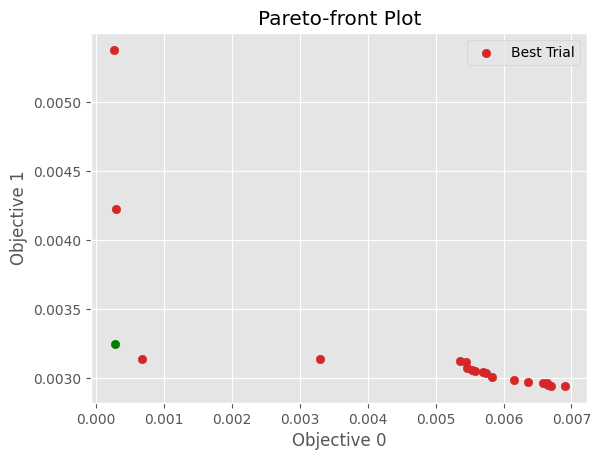

In [192]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)

plt.scatter(centroid_ground, sigma_ground, color='green')
#plt.xscale('log')
#plt.yscale('log')

In [193]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-11.478515865610142
-13.47304146307252
-13.5877265863877
-13.056656952000802
-10.83378207668645
-10.84404094773162
-10.983314058050574
-10.98498925145541
-10.903068994170244
-10.95038266047169
-10.97999270262152
-10.803317544706065
-10.875617887764456
-10.996211321499494
-10.995054990238646
-10.836921468042469
-10.836665281165335
-10.83486624928388
-10.96309739829027
-10.956657556564167


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


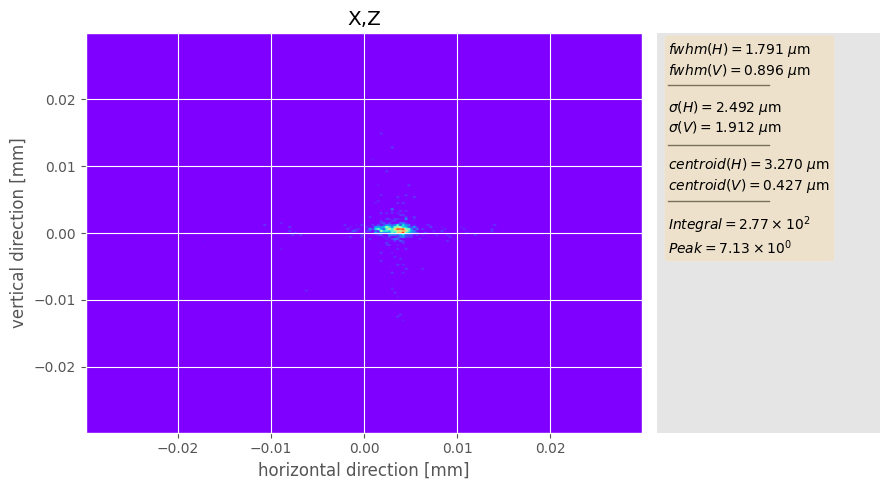

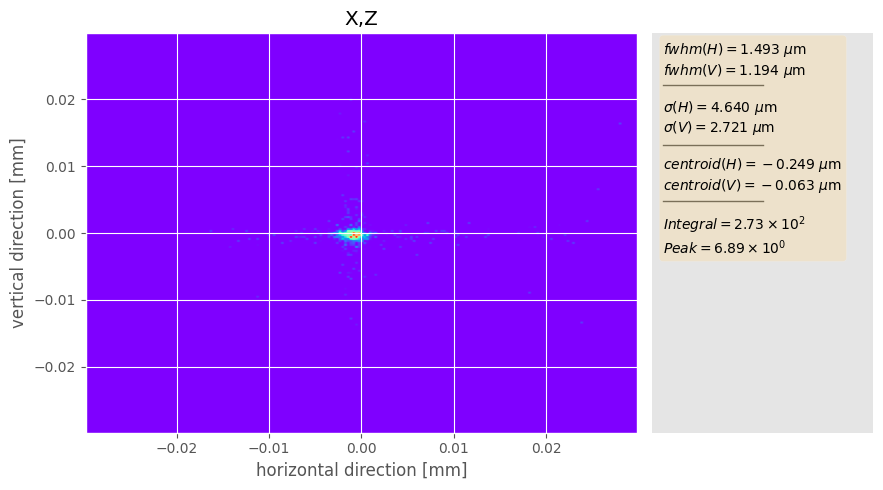

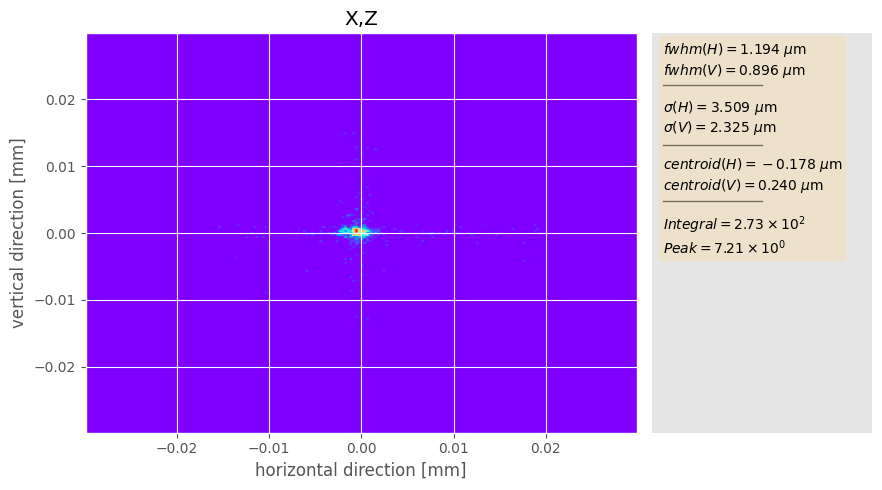

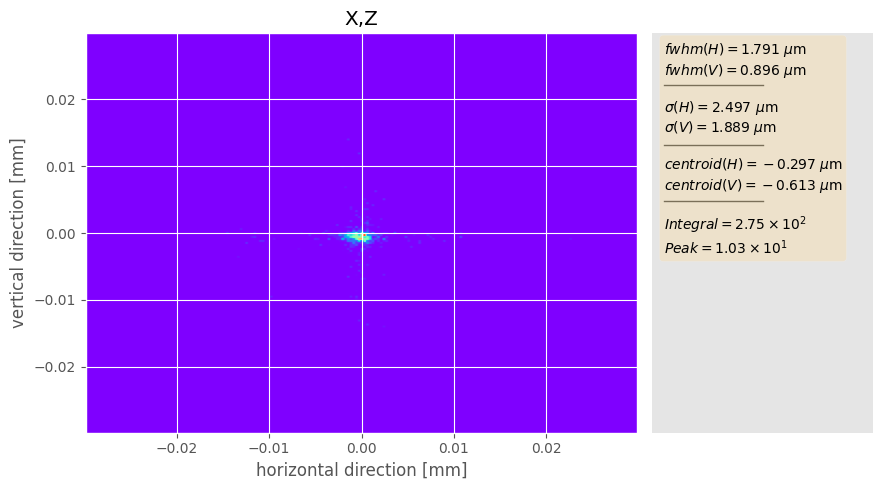

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


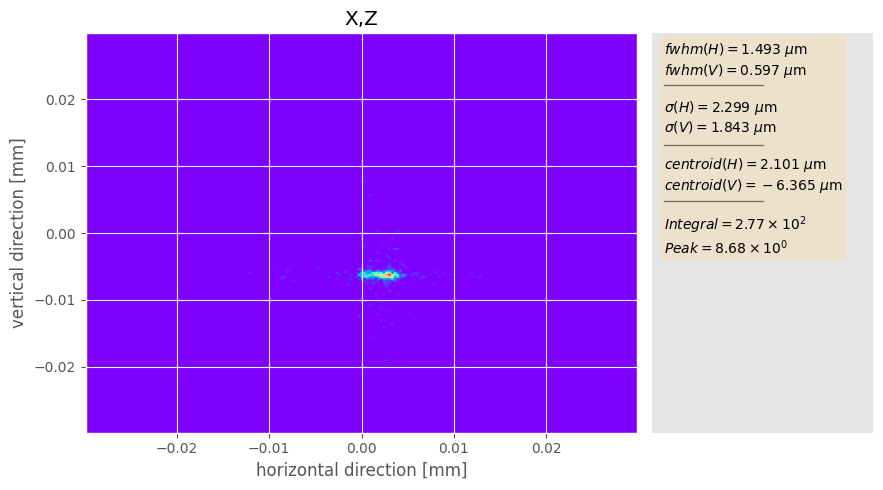

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


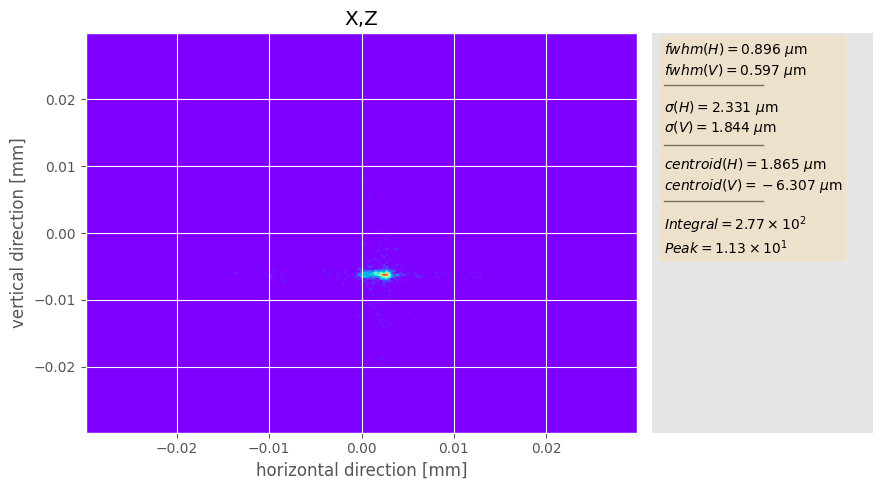

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


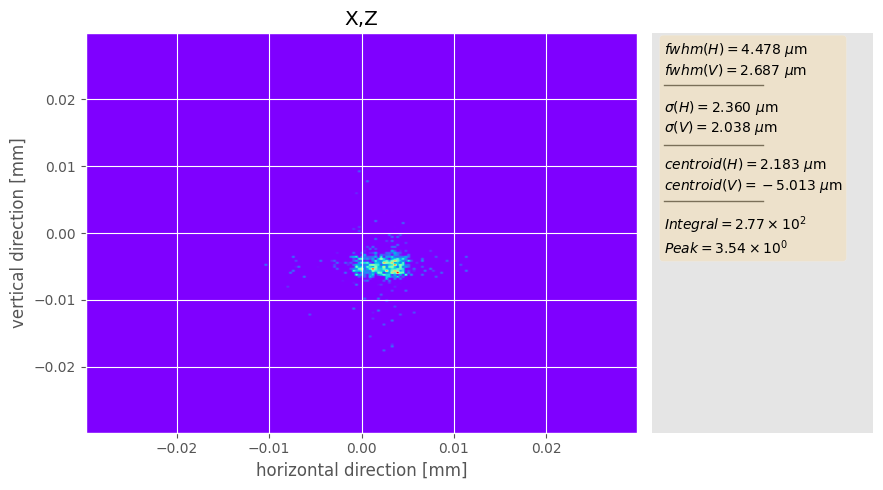

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


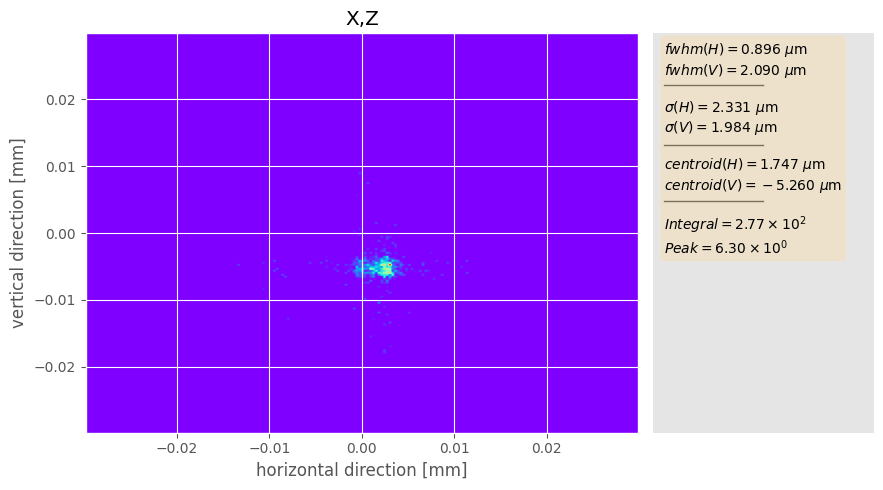

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


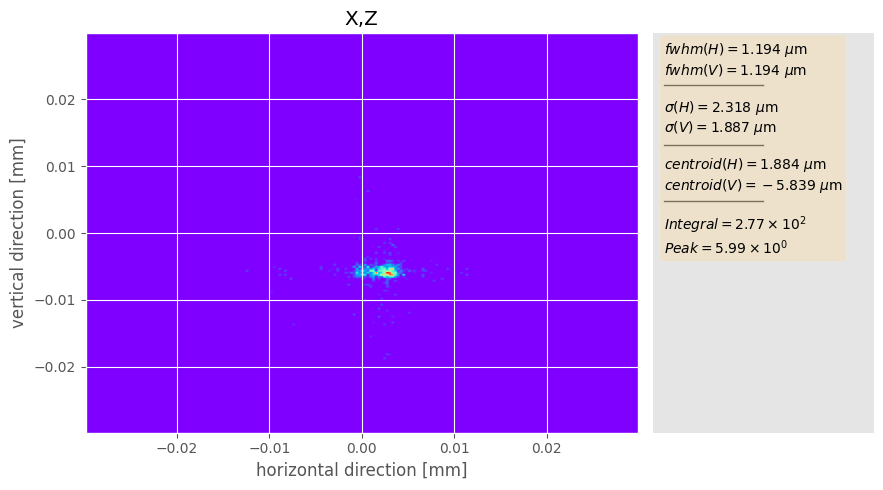

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


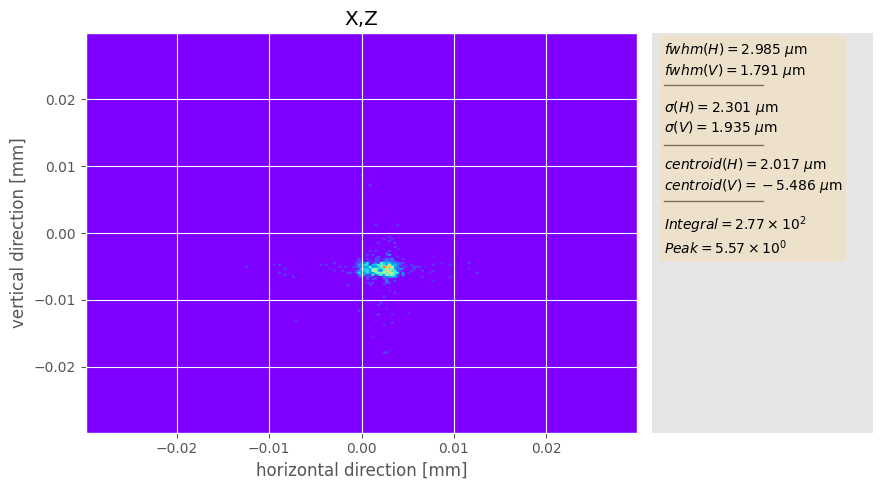

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


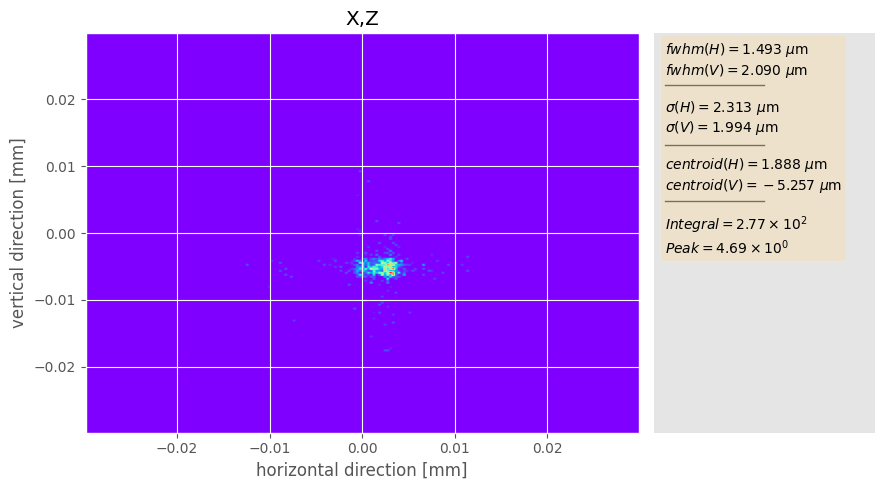

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


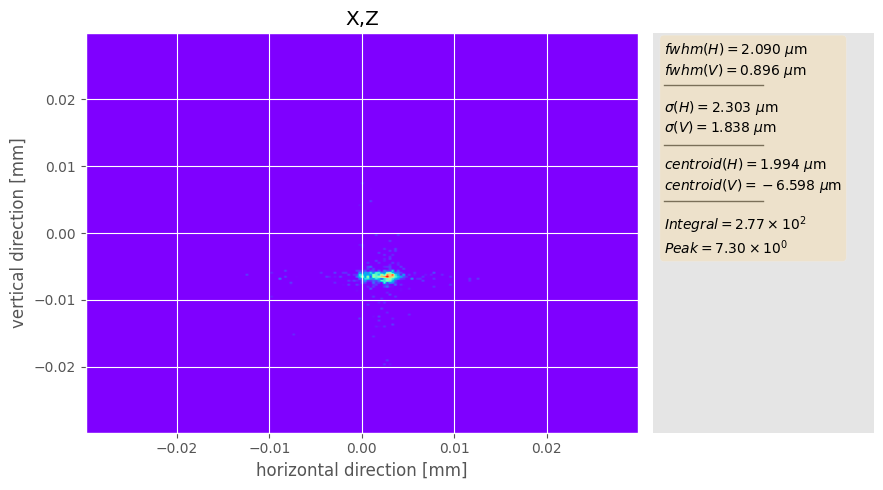

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


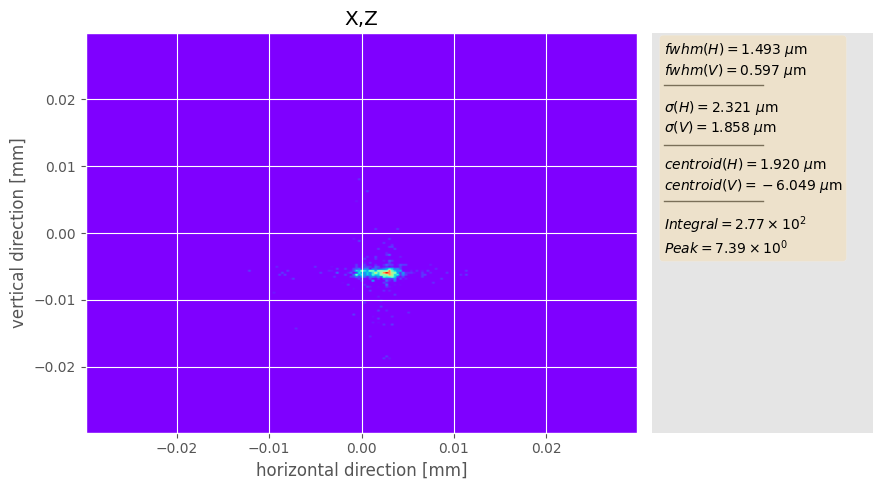

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


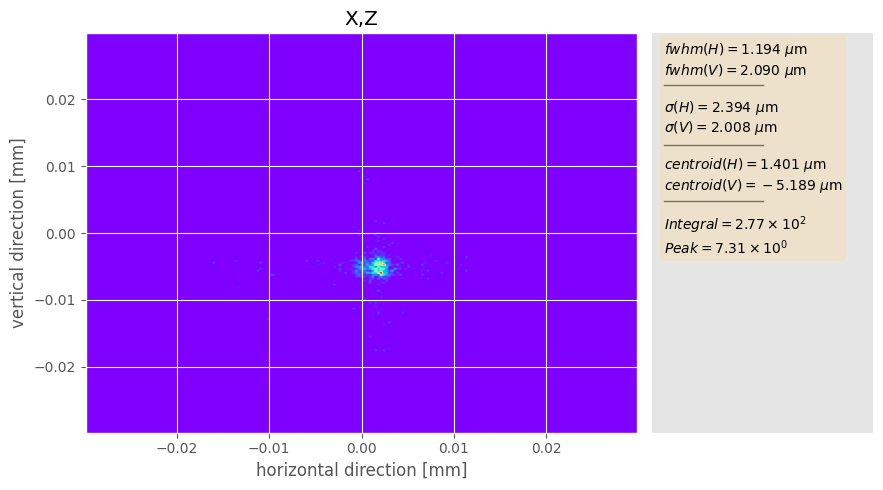

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


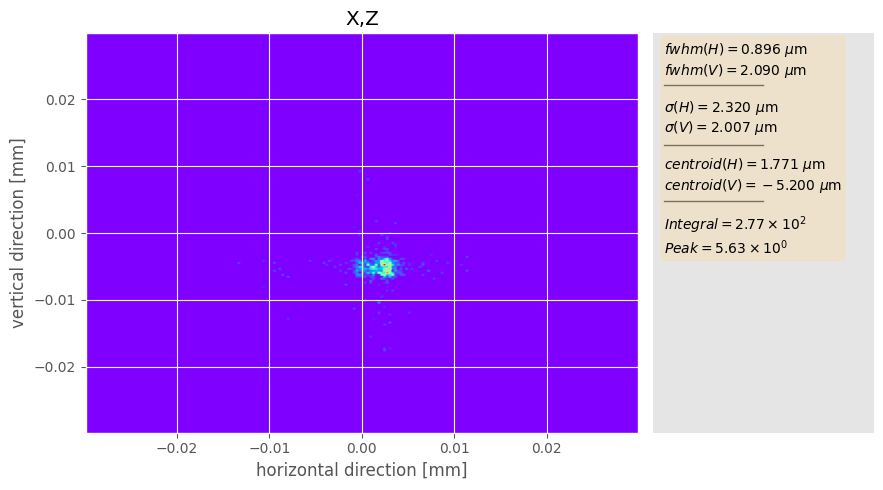

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


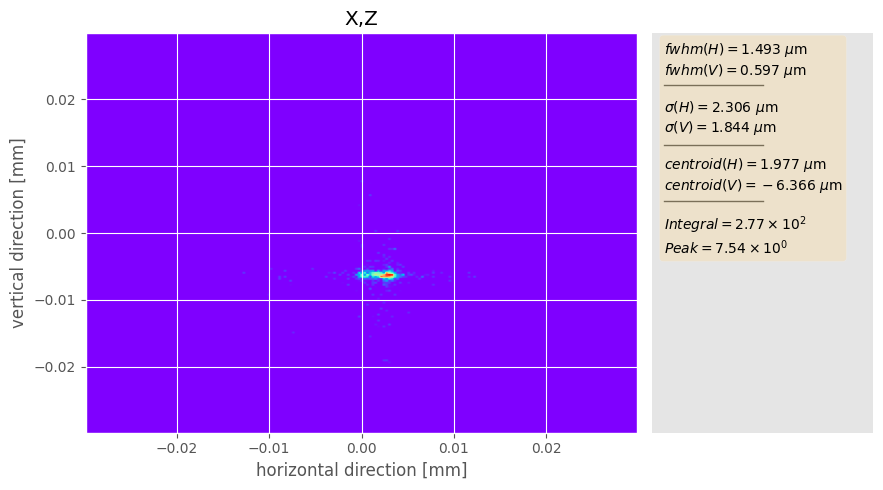

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


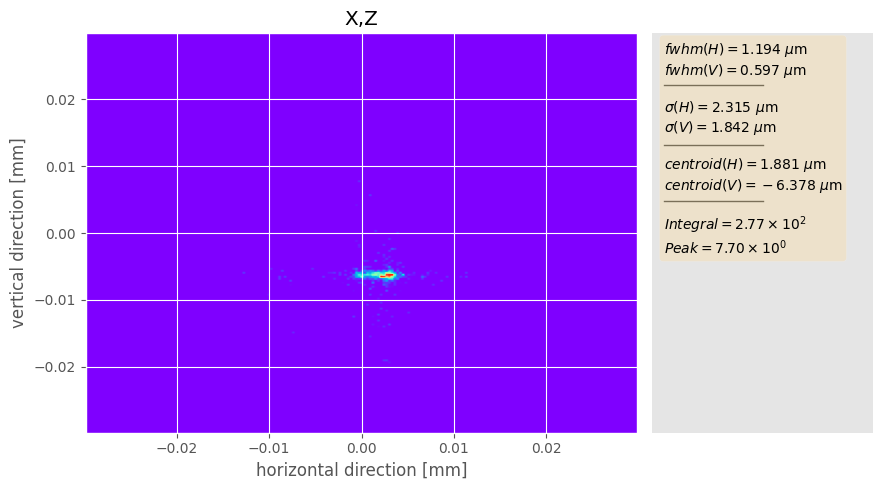

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


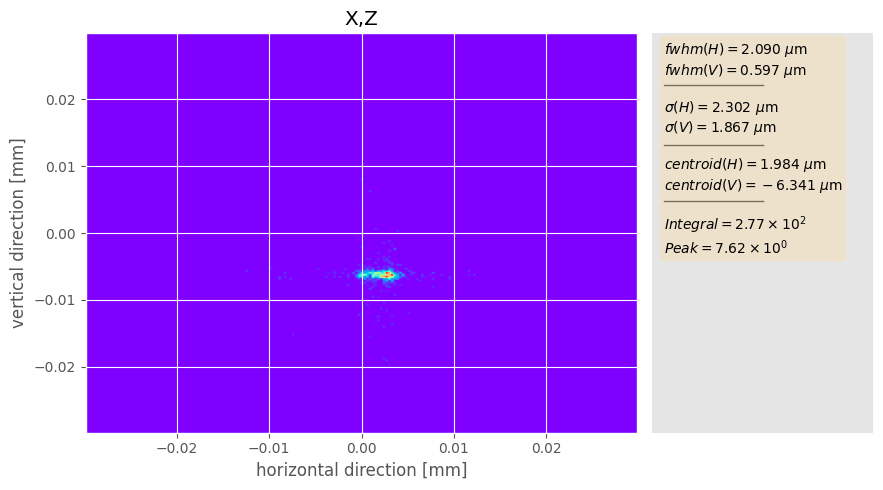

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


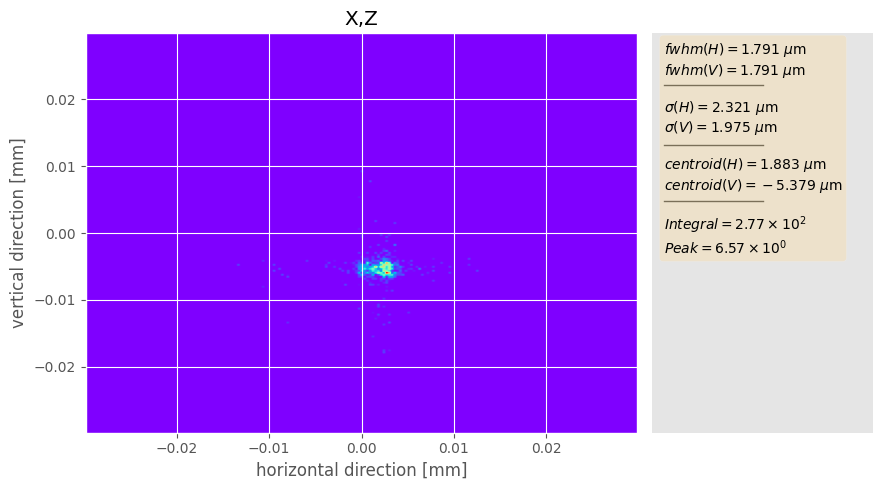

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


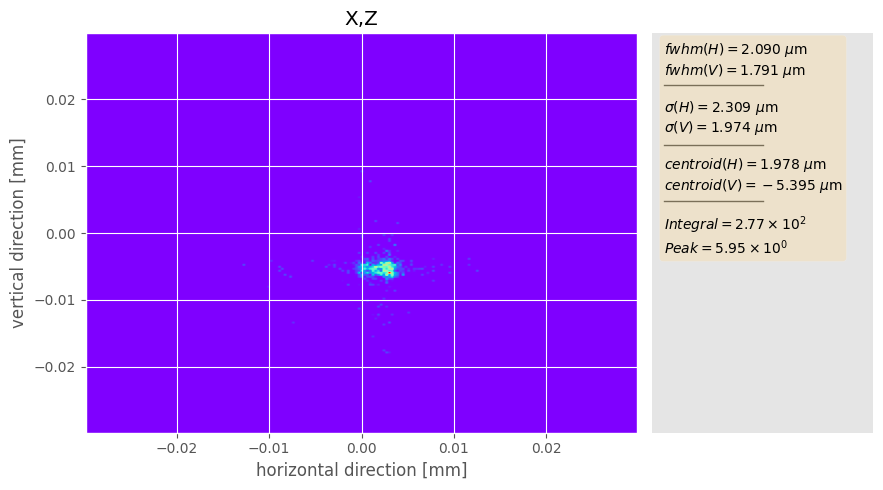

In [194]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [111]:
opt_trial._objective(opt_trial.study.best_trials[3])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-80, 80] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-80, 79.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[0.00460982947761592, 0.0038986768894145856]

In [195]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:17,102] Trial 400 finished with values: [0.0010030130892050518, 0.0043240336455296615] and parameters: {'hkb_1': 11.362499999999997, 'vkb_1': 23.077299999999994, 'hkb_2': 2.2982999999999976, 'vkb_2': 23.618799999999993, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.1, 'vkb_4': -20.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:19,673] Trial 401 finished with values: [0.0005216145012059721, 0.003718391233101033] and parameters: {'hkb_1': -2.4692000000000007, 'vkb_1': 2.5848999999999975, 'hkb_2': -11.226100000000002, 'vkb_2': 2.290999999999997, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.900000000000006, 'vkb_4': -20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:22,356] Trial 402 finished with values: [0.000854296720463932, 0.003738797229063922] and parameters: {'hkb_1': -2.5317000000000007, 'vkb_1': 2.4224999999999923, 'hkb_2': 12.911899999999996, 'vkb_2': 2.768499999999996, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.200000000000003, 'vkb_4': -20.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:24,917] Trial 403 finished with values: [0.0003964308651136113, 0.00519588153779363] and parameters: {'hkb_1': -2.3057000000000016, 'vkb_1': -39.6453, 'hkb_2': -42.2509, 'vkb_2': 2.5231999999999957, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.5, 'vkb_4': -20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:27,710] Trial 404 finished with values: [0.001868682438069814, 0.003715846166912126] and parameters: {'hkb_1': 42.3672, 'vkb_1': -18.7264, 'hkb_2': -39.6101, 'vkb_2': 10.642199999999995, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.1, 'vkb_4': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:30,326] Trial 405 finished with values: [0.0009622617808057507, 0.004257284646405127] and parameters: {'hkb_1': -25.936100000000003, 'vkb_1': -39.9543, 'hkb_2': -13.817400000000006, 'vkb_2': -35.7114, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.5, 'vkb_4': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:32,989] Trial 406 finished with values: [0.0023469471641896925, 0.004202101010729208] and parameters: {'hkb_1': -35.6331, 'vkb_1': 42.26689999999999, 'hkb_2': -23.683600000000002, 'vkb_2': 15.115799999999993, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.200000000000003, 'vkb_4': -20.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:35,551] Trial 407 finished with values: [0.0008891566260069562, 0.004623847310368617] and parameters: {'hkb_1': -2.6593000000000018, 'vkb_1': 13.397499999999994, 'hkb_2': -42.0374, 'vkb_2': 2.3337999999999965, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.300000000000004, 'vkb_4': -20.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:38,184] Trial 408 finished with values: [0.0017724320196217701, 0.004113646810263223] and parameters: {'hkb_1': -39.8467, 'vkb_1': -36.4532, 'hkb_2': -10.9525, 'vkb_2': 25.57029999999999, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.700000000000003, 'vkb_4': -19.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:40,933] Trial 409 finished with values: [0.0025945925520703345, 0.0037371051448295647] and parameters: {'hkb_1': -47.9074, 'vkb_1': 27.921499999999995, 'hkb_2': -35.0713, 'vkb_2': -12.1218, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.300000000000004, 'vkb_4': -21.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:43,486] Trial 410 finished with values: [0.0010395536159311161, 0.003574814498312474] and parameters: {'hkb_1': -12.627700000000004, 'vkb_1': 2.562599999999996, 'hkb_2': -21.542900000000003, 'vkb_2': 28.828999999999994, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.400000000000006, 'vkb_4': -19.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:46,168] Trial 411 finished with values: [0.0005387004806812458, 0.003500577597945414] and parameters: {'hkb_1': -2.6369000000000042, 'vkb_1': -44.986000000000004, 'hkb_2': -17.651500000000006, 'vkb_2': 16.554199999999994, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.300000000000004, 'vkb_4': -20.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:49,757] Trial 412 finished with values: [0.0011691491747549598, 0.003973847165717242] and parameters: {'hkb_1': 30.05749999999999, 'vkb_1': -33.5718, 'hkb_2': 42.617599999999996, 'vkb_2': -20.0648, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.400000000000006, 'vkb_4': -19.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:52,252] Trial 413 finished with values: [0.0006609993473520883, 0.004346742260365894] and parameters: {'hkb_1': 24.479299999999995, 'vkb_1': -46.129400000000004, 'hkb_2': -17.4208, 'vkb_2': 21.853099999999998, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.200000000000003, 'vkb_4': -19.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:54,719] Trial 414 finished with values: [0.0004750562692301428, 0.005161430848545309] and parameters: {'hkb_1': 12.378099999999996, 'vkb_1': -43.3278, 'hkb_2': -21.712600000000002, 'vkb_2': 13.099499999999992, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.200000000000003, 'vkb_4': -19.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:57,297] Trial 415 finished with values: [0.00046383909634704353, 0.0037228172238800866] and parameters: {'hkb_1': 24.160899999999998, 'vkb_1': -30.7053, 'hkb_2': -2.1245000000000047, 'vkb_2': 19.727499999999992, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.5, 'vkb_4': -19.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:14:59,809] Trial 416 finished with values: [0.000988824218959088, 0.0034987338485848807] and parameters: {'hkb_1': 22.801399999999987, 'vkb_1': -31.1169, 'hkb_2': -19.126, 'vkb_2': 18.83269999999999, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.900000000000006, 'vkb_4': -20.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:02,387] Trial 417 finished with values: [0.0012888749151563766, 0.0050595652869872875] and parameters: {'hkb_1': 22.46199999999999, 'vkb_1': -44.5704, 'hkb_2': -20.661600000000004, 'vkb_2': 31.25529999999999, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.5, 'vkb_4': -21.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:04,927] Trial 418 finished with values: [0.0010371913331356617, 0.00530038357548284] and parameters: {'hkb_1': 21.112199999999987, 'vkb_1': -47.9844, 'hkb_2': -18.6884, 'vkb_2': 21.592099999999988, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.5, 'vkb_4': -19.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:08,307] Trial 419 finished with values: [0.015604591623616798, 0.004003620686110453] and parameters: {'hkb_1': 18.6811, 'vkb_1': -29.3014, 'hkb_2': -15.410900000000005, 'vkb_2': 20.663999999999987, 'hkb_3': 0.021086523819801535, 'vkb_3': -0.026037365984045366, 'hkb_4': 21.200000000000003, 'vkb_4': -20.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:12,260] Trial 420 finished with values: [0.0017373101735889541, 0.0034486630041462526] and parameters: {'hkb_1': -20.294700000000002, 'vkb_1': -44.9033, 'hkb_2': 48.4661, 'vkb_2': 16.9657, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.5, 'vkb_4': -19.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:15,013] Trial 421 finished with values: [0.0028143553256502153, 0.003865615300197653] and parameters: {'hkb_1': -44.6548, 'vkb_1': -27.6188, 'hkb_2': -25.427000000000003, 'vkb_2': 18.491899999999987, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.400000000000006, 'vkb_4': -19.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:17,660] Trial 422 finished with values: [0.0009541876566921522, 0.003710777329766318] and parameters: {'hkb_1': -2.3590000000000018, 'vkb_1': -31.204900000000002, 'hkb_2': -19.3347, 'vkb_2': 20.8489, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.005378560551852568, 'hkb_4': 21.300000000000004, 'vkb_4': -20.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:20,702] Trial 423 finished with values: [0.011999317046994107, 0.005408499890794497] and parameters: {'hkb_1': 23.764599999999987, 'vkb_1': -15.724200000000003, 'hkb_2': -18.7342, 'vkb_2': 18.952799999999996, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.03504915783575618, 'hkb_4': 22.900000000000006, 'vkb_4': -21.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:23,649] Trial 424 finished with values: [0.0011162253004523754, 0.0037806264489306965] and parameters: {'hkb_1': 24.092799999999997, 'vkb_1': -41.6532, 'hkb_2': 25.200699999999998, 'vkb_2': 18.374799999999993, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': 21.200000000000003, 'vkb_4': -19.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:26,299] Trial 425 finished with values: [0.0004089647949969081, 0.0034660627806268047] and parameters: {'hkb_1': -2.3093000000000075, 'vkb_1': -31.8459, 'hkb_2': -47.6739, 'vkb_2': 16.221499999999992, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.0, 'vkb_4': -20.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:29,425] Trial 426 finished with values: [0.008213647644478005, 0.004303206146137078] and parameters: {'hkb_1': -18.213400000000004, 'vkb_1': 36.904099999999985, 'hkb_2': -37.4776, 'vkb_2': 14.673199999999994, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.02981317007977318, 'hkb_4': 23.200000000000003, 'vkb_4': -21.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:33,254] Trial 427 finished with values: [0.016769055364202964, 0.0042152075953834885] and parameters: {'hkb_1': -28.5102, 'vkb_1': -31.706400000000002, 'hkb_2': -44.6858, 'vkb_2': 17.569999999999993, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.027782695236039694, 'hkb_4': 21.0, 'vkb_4': -21.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:36,526] Trial 428 finished with values: [0.0117302954509864, 0.0055160281923708875] and parameters: {'hkb_1': -5.339000000000006, 'vkb_1': -30.5818, 'hkb_2': -40.2123, 'vkb_2': 15.601299999999995, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.017310719724073716, 'hkb_4': 22.900000000000006, 'vkb_4': -21.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:39,213] Trial 429 finished with values: [0.006801407111665121, 0.01809215435842998] and parameters: {'hkb_1': 8.223499999999994, 'vkb_1': -31.6594, 'hkb_2': -47.252, 'vkb_2': 14.710799999999992, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.022831853071795867, 'hkb_4': 21.1, 'vkb_4': 3.3000000000000043}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:42,142] Trial 430 finished with values: [0.0028098511582929724, 0.004342948676518002] and parameters: {'hkb_1': 40.48719999999999, 'vkb_1': -33.2405, 'hkb_2': -47.8557, 'vkb_2': -42.9042, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.5, 'vkb_4': -19.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:44,825] Trial 431 finished with values: [0.00020365201989455242, 0.005680541317222056] and parameters: {'hkb_1': -2.3022000000000062, 'vkb_1': -32.3635, 'hkb_2': -49.829, 'vkb_2': 16.3262, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.700000000000003, 'vkb_4': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:47,686] Trial 432 finished with values: [0.002261487608739376, 0.005186294691439898] and parameters: {'hkb_1': -43.432900000000004, 'vkb_1': -28.5348, 'hkb_2': -49.7217, 'vkb_2': 16.693299999999994, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.0, 'vkb_4': -20.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:50,494] Trial 433 finished with values: [0.001571866184531008, 0.0043506517648151275] and parameters: {'hkb_1': 34.0201, 'vkb_1': -34.1605, 'hkb_2': -30.191300000000002, 'vkb_2': 11.924199999999992, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.800000000000004, 'vkb_4': -21.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:54,493] Trial 434 finished with values: [0.019878919515432376, 0.004217357881050807] and parameters: {'hkb_1': -2.8932000000000073, 'vkb_1': -33.0039, 'hkb_2': -46.6095, 'vkb_2': 16.496399999999994, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.036509341496011344, 'hkb_4': 21.5, 'vkb_4': -20.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:15:58,157] Trial 435 finished with values: [0.0016003711270016793, 10000.0] and parameters: {'hkb_1': -6.156500000000001, 'vkb_1': -35.0119, 'hkb_2': -49.3996, 'vkb_2': 17.3827, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.03301868299202268, 'hkb_4': 22.300000000000004, 'vkb_4': 11.600000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:00,771] Trial 436 finished with values: [0.0014064510852117116, 0.003950579974901426] and parameters: {'hkb_1': -2.3157000000000068, 'vkb_1': -32.490700000000004, 'hkb_2': -47.0544, 'vkb_2': 15.102099999999993, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.200000000000003, 'vkb_4': -19.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:03,420] Trial 437 finished with values: [0.0006051757334152808, 0.00523047258714757] and parameters: {'hkb_1': -2.156100000000002, 'vkb_1': -31.120500000000003, 'hkb_2': -48.4258, 'vkb_2': 16.7303, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.200000000000003, 'vkb_4': -20.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:07,518] Trial 438 finished with values: [0.012426503394246403, 0.004549036678651881] and parameters: {'hkb_1': -41.619, 'vkb_1': -29.5762, 'hkb_2': -43.8302, 'vkb_2': 15.32459999999999, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.022546707480056705, 'hkb_4': 21.800000000000004, 'vkb_4': -19.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:09,256] Trial 439 finished with values: [0.009946519963141057, 0.0035260712155222155] and parameters: {'hkb_1': -4.530900000000003, 'vkb_1': -30.146, 'hkb_2': -48.7379, 'vkb_2': 16.08279999999999, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.200000000000003, 'vkb_4': -20.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:11,944] Trial 440 finished with values: [0.0004143370863299604, 0.0036595581049450347] and parameters: {'hkb_1': -2.2083000000000013, 'vkb_1': -34.2076, 'hkb_2': -49.2204, 'vkb_2': 14.405299999999997, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.1, 'vkb_4': -20.1}. 
[I 2022-09-23 14:16:12,502] Trial 441 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 2.1731999999999942, 'vkb_1': -34.9484, 'hkb_2': -49.2978, 'vkb_2': 24.264499999999998, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.021086523819801535, 'hkb_4': 21.200000000000003, 'vkb_4': 18.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:15,971] Trial 442 finished with values: [0.013732708706069765, 0.004473127898543964] and parameters: {'hkb_1': -31.3774, 'vkb_1': -33.4088, 'hkb_2': -49.9752, 'vkb_2': 39.756299999999996, 'hkb_3': 0.021086523819801535, 'vkb_3': -0.020801378228062377, 'hkb_4': 21.900000000000006, 'vkb_4': -21.799999999999997}. 
[I 2022-09-23 14:16:16,528] Trial 443 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -2.2767000000000053, 'vkb_1': 31.4229, 'hkb_2': -44.3897, 'vkb_2': 14.101399999999998, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.1, 'vkb_4': 21.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:19,097] Trial 444 finished with values: [0.005948217866095808, 0.015145553666656396] and parameters: {'hkb_1': 2.2857999999999947, 'vkb_1': -33.1879, 'hkb_2': -47.0208, 'vkb_2': -47.050200000000004, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.014105206811824214, 'hkb_4': 21.200000000000003, 'vkb_4': 9.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:22,600] Trial 445 finished with values: [0.02118055210557314, 0.014412296767678332] and parameters: {'hkb_1': -1.9513000000000034, 'vkb_1': -31.933, 'hkb_2': -48.3491, 'vkb_2': -31.0915, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.017310719724073716, 'hkb_4': -15.299999999999999, 'vkb_4': -20.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:25,878] Trial 446 finished with values: [0.007520025260049605, 0.004523159449528708] and parameters: {'hkb_1': -21.826300000000003, 'vkb_1': -37.9763, 'hkb_2': -45.4411, 'vkb_2': 26.514899999999997, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.013820061220085056, 'hkb_4': 22.300000000000004, 'vkb_4': -18.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:28,996] Trial 447 finished with values: [0.012014857431338863, 0.0035518222403164933] and parameters: {'hkb_1': 16.098499999999987, 'vkb_1': -35.5253, 'hkb_2': 22.8001, 'vkb_2': 16.881199999999993, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.026322511575784517, 'hkb_4': 20.900000000000006, 'vkb_4': -20.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:33,011] Trial 448 finished with values: [0.0014647965588729368, 0.003873792703632041] and parameters: {'hkb_1': 46.21709999999999, 'vkb_1': 17.966499999999996, 'hkb_2': 45.41929999999999, 'vkb_2': -15.737700000000004, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': 22.1, 'vkb_4': -19.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:35,743] Trial 449 finished with values: [0.002329077087766542, 0.005415361960521426] and parameters: {'hkb_1': -2.3486000000000047, 'vkb_1': -13.193100000000001, 'hkb_2': -49.9782, 'vkb_2': 34.04419999999999, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.003633231299858236, 'hkb_4': 22.400000000000006, 'vkb_4': -21.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:39,691] Trial 450 finished with values: [0.021361558336415124, 0.003882341630514755] and parameters: {'hkb_1': -2.351600000000005, 'vkb_1': 24.976, 'hkb_2': -46.7311, 'vkb_2': 37.7872, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.03825467074800567, 'hkb_4': 21.0, 'vkb_4': -20.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:43,061] Trial 451 finished with values: [0.010852663449820884, 10000.0] and parameters: {'hkb_1': 2.1496999999999957, 'vkb_1': -25.7694, 'hkb_2': 29.0522, 'vkb_2': -38.9867, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0071238898038469, 'hkb_4': -25.6, 'vkb_4': -19.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:46,745] Trial 452 finished with values: [0.02238775900835188, 0.004455596732132064] and parameters: {'hkb_1': -2.473300000000002, 'vkb_1': -32.183400000000006, 'hkb_2': 32.85289999999999, 'vkb_2': 13.661799999999992, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.02981317007977318, 'hkb_4': -5.099999999999998, 'vkb_4': -20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:48,600] Trial 453 finished with values: [0.019733558433473797, 0.00734665779344473] and parameters: {'hkb_1': -34.247, 'vkb_1': -32.182500000000005, 'hkb_2': -48.8733, 'vkb_2': 16.99669999999999, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.005378560551852568, 'hkb_4': -11.8, 'vkb_4': -20.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:52,483] Trial 454 finished with values: [0.01414687224805078, 0.005224130378463791] and parameters: {'hkb_1': 45.1686, 'vkb_1': 47.34599999999999, 'hkb_2': 15.626099999999994, 'vkb_2': 49.957199999999986, 'hkb_3': 0.021086523819801535, 'vkb_3': -0.024292036732051034, 'hkb_4': 22.0, 'vkb_4': -18.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:56,056] Trial 455 finished with values: [0.0016790690146488833, 0.01691072569103111] and parameters: {'hkb_1': 48.10539999999999, 'vkb_1': -20.3182, 'hkb_2': 22.312799999999996, 'vkb_2': 15.752199999999988, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': -20.9, 'vkb_4': -21.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:16:59,800] Trial 456 finished with values: [0.018261504921038608, 0.005496563063398718] and parameters: {'hkb_1': -1.9485000000000028, 'vkb_1': 14.084699999999998, 'hkb_2': 9.864499999999992, 'vkb_2': 46.88759999999999, 'hkb_3': 0.021086523819801535, 'vkb_3': -0.03301868299202268, 'hkb_4': 22.900000000000006, 'vkb_4': -19.9}. 
[I 2022-09-23 14:17:00,378] Trial 457 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 41.55569999999999, 'vkb_1': 9.677499999999995, 'hkb_2': -2.210100000000004, 'vkb_2': -36.4334, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.003633231299858236, 'hkb_4': 21.1, 'vkb_4': 24.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:03,564] Trial 458 finished with values: [0.0037324963760066183, 0.020914052947207263] and parameters: {'hkb_1': 36.86699999999999, 'vkb_1': -17.718700000000005, 'hkb_2': 27.98089999999999, 'vkb_2': 29.431799999999996, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.800000000000004, 'vkb_4': 14.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:06,258] Trial 459 finished with values: [0.003562053696730516, 0.003893526912393593] and parameters: {'hkb_1': -37.8385, 'vkb_1': -2.2986000000000075, 'hkb_2': 2.1768999999999963, 'vkb_2': 18.9152, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': 23.5, 'vkb_4': -19.1}. 
[I 2022-09-23 14:17:06,848] Trial 460 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -26.114, 'vkb_1': -34.057500000000005, 'hkb_2': -49.6621, 'vkb_2': -16.902800000000006, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.800000000000004, 'vkb_4': 26.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:10,172] Trial 461 finished with values: [0.0070815409658887135, 0.012024162024264429] and parameters: {'hkb_1': 18.054699999999997, 'vkb_1': -30.190600000000003, 'hkb_2': 37.276099999999985, 'vkb_2': -9.113700000000001, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.0, 'vkb_4': 3.6000000000000014}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:13,139] Trial 462 finished with values: [0.028495851235759657, 0.00439528298151006] and parameters: {'hkb_1': 2.102799999999995, 'vkb_1': -10.6509, 'hkb_2': -41.9635, 'vkb_2': 42.20609999999999, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0071238898038469, 'hkb_4': -8.2, 'vkb_4': -20.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:15,530] Trial 463 finished with values: [0.008601000880633668, 0.012339548394602044] and parameters: {'hkb_1': 2.374599999999994, 'vkb_1': -2.190100000000001, 'hkb_2': -28.563100000000002, 'vkb_2': -33.5191, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.0071238898038469, 'hkb_4': -22.9, 'vkb_4': -20.1}. 
[I 2022-09-23 14:17:16,120] Trial 464 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 15.310699999999997, 'vkb_1': 43.51639999999999, 'hkb_2': -48.0583, 'vkb_2': -49.8592, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.300000000000004, 'vkb_4': 20.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:18,690] Trial 465 finished with values: [0.007309738184484214, 0.0032155170468271847] and parameters: {'hkb_1': -1.9596000000000018, 'vkb_1': -23.415300000000002, 'hkb_2': -41.9812, 'vkb_2': 15.076499999999996, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.900000000000006, 'vkb_4': 6.5}. 
[I 2022-09-23 14:17:19,284] Trial 466 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -22.939500000000002, 'vkb_1': 21.042599999999993, 'hkb_2': 2.2822999999999922, 'vkb_2': -2.3048000000000073, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 20.800000000000004, 'vkb_4': 27.900000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:22,185] Trial 467 finished with values: [0.014715424349016048, 0.003409762014897033] and parameters: {'hkb_1': 29.97399999999999, 'vkb_1': 16.1019, 'hkb_2': -33.5175, 'vkb_2': -2.4972000000000065, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.300000000000004, 'vkb_4': -19.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:24,792] Trial 468 finished with values: [0.0016282154130592402, 0.0046997978364138925] and parameters: {'hkb_1': 12.899499999999996, 'vkb_1': 2.2460999999999984, 'hkb_2': -9.085100000000004, 'vkb_2': 16.727099999999993, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.200000000000003, 'vkb_4': -21.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:27,567] Trial 469 finished with values: [0.012985505454027269, 0.017001111397440764] and parameters: {'hkb_1': 9.456899999999997, 'vkb_1': 11.537799999999997, 'hkb_2': -2.3020000000000067, 'vkb_2': 8.994799999999998, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.0071238898038469, 'hkb_4': 20.700000000000003, 'vkb_4': 10.900000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:30,315] Trial 470 finished with values: [0.0013272092652269465, 0.0035533190155086483] and parameters: {'hkb_1': 4.910399999999996, 'vkb_1': 8.035999999999994, 'hkb_2': 11.571899999999992, 'vkb_2': -23.344300000000004, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.900000000000006, 'vkb_4': -20.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:32,892] Trial 471 finished with values: [0.008902462123530698, 0.010405950502005795] and parameters: {'hkb_1': -9.433000000000007, 'vkb_1': -2.411900000000003, 'hkb_2': -2.031500000000001, 'vkb_2': 25.819999999999993, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.5, 'vkb_4': -3.6999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:35,147] Trial 472 finished with values: [0.0098821659649944, 0.0031836825438194094] and parameters: {'hkb_1': -2.419700000000006, 'vkb_1': 2.2831999999999937, 'hkb_2': 2.221899999999998, 'vkb_2': 24.391199999999998, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.0071238898038469, 'hkb_4': -0.6999999999999993, 'vkb_4': -19.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:37,953] Trial 473 finished with values: [0.01454789463910031, 0.0032387496899493654] and parameters: {'hkb_1': -4.710500000000003, 'vkb_1': 35.166, 'hkb_2': -49.904, 'vkb_2': -26.646900000000002, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 6.800000000000004, 'vkb_4': -18.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:40,251] Trial 474 finished with values: [0.01199626717416204, 0.0034784274526706155] and parameters: {'hkb_1': -14.398500000000006, 'vkb_1': -32.669200000000004, 'hkb_2': -2.2203000000000017, 'vkb_2': 13.928999999999995, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.400000000000006, 'vkb_4': -20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:43,394] Trial 475 finished with values: [0.0017265030572232393, 0.0034613348506346876] and parameters: {'hkb_1': 2.4066999999999936, 'vkb_1': -30.9692, 'hkb_2': 31.88239999999999, 'vkb_2': 2.099099999999993, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.800000000000004, 'vkb_4': -20.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:47,009] Trial 476 finished with values: [0.017775666809999317, 0.004747035492030229] and parameters: {'hkb_1': 2.4150999999999954, 'vkb_1': -7.8063, 'hkb_2': 39.81479999999999, 'vkb_2': -11.4191, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 4.300000000000004, 'vkb_4': -7.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:49,757] Trial 477 finished with values: [0.0012575518820082394, 0.0035244274937083243] and parameters: {'hkb_1': -2.117900000000006, 'vkb_1': -15.4865, 'hkb_2': -35.835, 'vkb_2': -21.144600000000004, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0071238898038469, 'hkb_4': 20.900000000000006, 'vkb_4': -19.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:52,375] Trial 478 finished with values: [0.00122014731648205, 0.003224733498385785] and parameters: {'hkb_1': 2.447899999999997, 'vkb_1': 4.874699999999997, 'hkb_2': -1.9453000000000031, 'vkb_2': -27.5085, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.6, 'vkb_4': -20.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:54,816] Trial 479 finished with values: [0.0036860135462448893, 0.018643768714810213] and parameters: {'hkb_1': -4.838500000000003, 'vkb_1': -2.2660000000000053, 'hkb_2': -40.5429, 'vkb_2': 16.4657, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': -18.1, 'vkb_4': -19.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:17:57,248] Trial 480 finished with values: [0.0026395364846560016, 0.017802658846068325] and parameters: {'hkb_1': -4.530400000000007, 'vkb_1': -30.4048, 'hkb_2': -49.8807, 'vkb_2': -2.2005000000000052, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 23.700000000000003, 'vkb_4': 13.900000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:00,747] Trial 481 finished with values: [0.0016395809219383604, 0.005685449650962787] and parameters: {'hkb_1': -2.248100000000001, 'vkb_1': -30.812, 'hkb_2': 46.567499999999995, 'vkb_2': -2.195600000000006, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 24.0, 'vkb_4': -19.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:03,199] Trial 482 finished with values: [0.0008893036993193263, 0.004723948337321433] and parameters: {'hkb_1': -2.179300000000005, 'vkb_1': -33.348600000000005, 'hkb_2': -47.5887, 'vkb_2': 17.7697, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.200000000000003, 'vkb_4': -20.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:05,498] Trial 483 finished with values: [0.0012863638158807896, 0.0046985021812959785] and parameters: {'hkb_1': 2.2515999999999963, 'vkb_1': 46.0633, 'hkb_2': -32.3177, 'vkb_2': 27.735799999999998, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0071238898038469, 'hkb_4': 23.200000000000003, 'vkb_4': -19.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:08,587] Trial 484 finished with values: [0.00976636193950109, 0.003290734683643403] and parameters: {'hkb_1': -2.4886000000000053, 'vkb_1': -1.9892000000000039, 'hkb_2': 42.98089999999999, 'vkb_2': -28.178500000000003, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.005378560551852568, 'hkb_4': 23.1, 'vkb_4': -20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:11,814] Trial 485 finished with values: [0.01151282497207638, 0.004152629774746289] and parameters: {'hkb_1': -40.225, 'vkb_1': 2.2726999999999933, 'hkb_2': 2.0146999999999977, 'vkb_2': 19.118499999999997, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.03504915783575618, 'hkb_4': 22.6, 'vkb_4': -21.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:14,345] Trial 486 finished with values: [0.026024244281503735, 0.009263032251961767] and parameters: {'hkb_1': 2.2102999999999966, 'vkb_1': 1.936799999999998, 'hkb_2': -2.2084000000000046, 'vkb_2': 2.3178999999999945, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.0071238898038469, 'hkb_4': -12.899999999999999, 'vkb_4': -19.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:16,750] Trial 487 finished with values: [0.020283588779325915, 0.0031814212477516953] and parameters: {'hkb_1': -2.316600000000001, 'vkb_1': -1.9527000000000072, 'hkb_2': 2.2870999999999952, 'vkb_2': -2.243300000000005, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': -2.599999999999998, 'vkb_4': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:19,117] Trial 488 finished with values: [0.012042494760642942, 0.0068806408749761735] and parameters: {'hkb_1': -4.546300000000002, 'vkb_1': -2.113200000000006, 'hkb_2': -2.009600000000006, 'vkb_2': 44.179799999999986, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.1, 'vkb_4': -6.0}. 
[I 2022-09-23 14:18:19,473] Trial 489 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -24.3395, 'vkb_1': -31.9262, 'hkb_2': -14.089200000000005, 'vkb_2': 15.1494, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.0071238898038469, 'hkb_4': 22.6, 'vkb_4': 18.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:22,421] Trial 490 finished with values: [0.011508688046479651, 0.0042709463820855675] and parameters: {'hkb_1': 4.739699999999992, 'vkb_1': 2.551099999999998, 'hkb_2': -27.2784, 'vkb_2': -2.106100000000005, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.015565390472079388, 'hkb_4': 21.200000000000003, 'vkb_4': -20.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:24,795] Trial 491 finished with values: [0.0004166514933449825, 0.003474383036742423] and parameters: {'hkb_1': 2.4702999999999946, 'vkb_1': 4.387699999999995, 'hkb_2': -2.111000000000004, 'vkb_2': 32.75699999999999, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.005378560551852568, 'hkb_4': 21.400000000000006, 'vkb_4': -19.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:28,234] Trial 492 finished with values: [0.013960258590432957, 0.003329397925000455] and parameters: {'hkb_1': 25.959599999999995, 'vkb_1': 40.21459999999999, 'hkb_2': 19.815399999999997, 'vkb_2': 2.174899999999994, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.200000000000003, 'vkb_4': -19.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:30,253] Trial 493 finished with values: [0.010608854684458019, 0.017221242655773513] and parameters: {'hkb_1': -48.0465, 'vkb_1': 1.999299999999998, 'hkb_2': 2.0357999999999947, 'vkb_2': 2.4790999999999954, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.021086523819801535, 'hkb_4': 21.5, 'vkb_4': 9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:32,530] Trial 494 finished with values: [0.00015992901718912646, 0.0034354471955902704] and parameters: {'hkb_1': 4.981299999999997, 'vkb_1': -1.995200000000004, 'hkb_2': -1.7983000000000047, 'vkb_2': 2.3589999999999947, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.0071238898038469, 'hkb_4': 21.1, 'vkb_4': -19.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:35,190] Trial 495 finished with values: [0.011600554386307521, 0.004008760884992907] and parameters: {'hkb_1': 7.208899999999993, 'vkb_1': -4.435100000000006, 'hkb_2': -4.622500000000002, 'vkb_2': 4.7479999999999976, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.03155849933176751, 'hkb_4': 20.300000000000004, 'vkb_4': -19.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:38,410] Trial 496 finished with values: [0.015089441006143395, 0.00398697855455836] and parameters: {'hkb_1': 6.807099999999998, 'vkb_1': -4.771300000000004, 'hkb_2': -5.037000000000006, 'vkb_2': 4.9461999999999975, 'hkb_3': 0.019341194567807203, 'vkb_3': -0.027782695236039694, 'hkb_4': 20.300000000000004, 'vkb_4': -18.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:40,790] Trial 497 finished with values: [0.005508853868550215, 0.003887193712420403] and parameters: {'hkb_1': 6.002999999999993, 'vkb_1': -3.792500000000004, 'hkb_2': -2.7220000000000013, 'vkb_2': 5.651199999999996, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.017595865315812878, 'hkb_4': 20.200000000000003, 'vkb_4': -19.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:43,073] Trial 498 finished with values: [0.0004893111144699043, 0.0034433841108335965] and parameters: {'hkb_1': 6.248999999999995, 'vkb_1': -4.525800000000004, 'hkb_2': -4.151700000000005, 'vkb_2': 4.733399999999996, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.005378560551852568, 'hkb_4': 20.400000000000006, 'vkb_4': -19.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 14:18:45,526] Trial 499 finished with values: [0.008709836439588533, 0.003717481207555299] and parameters: {'hkb_1': 5.617699999999992, 'vkb_1': -4.519700000000007, 'hkb_2': -2.389400000000002, 'vkb_2': 3.5202999999999918, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.0245771823237902, 'hkb_4': 20.5, 'vkb_4': -18.9}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_10632/1503738956.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


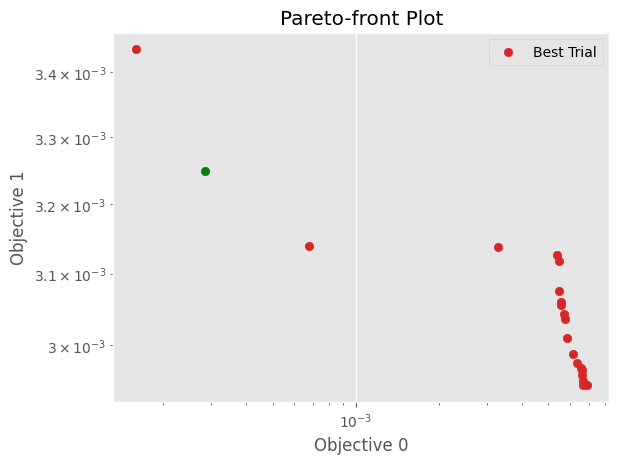

In [196]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
plt.scatter(centroid_ground, sigma_ground, color='green')
plt.xscale('log')
plt.yscale('log')

In [197]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-11.478515865610142
-13.056656952000802
-10.83378207668645
-10.84404094773162
-10.983314058050574
-10.98498925145541
-10.903068994170244
-10.95038266047169
-10.97999270262152
-10.803317544706065
-10.875617887764456
-10.996211321499494
-10.995054990238646
-10.836921468042469
-10.836665281165335
-10.83486624928388
-10.96309739829027
-10.956657556564167
-14.41438865757366


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


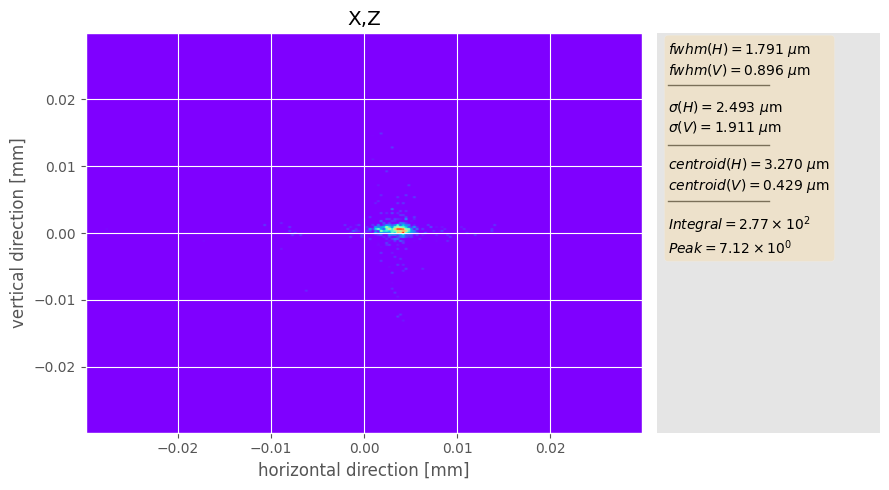

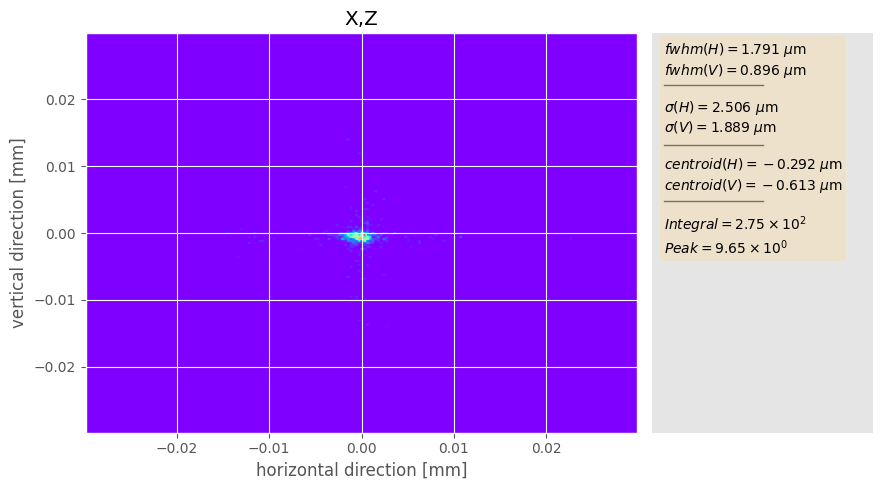

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


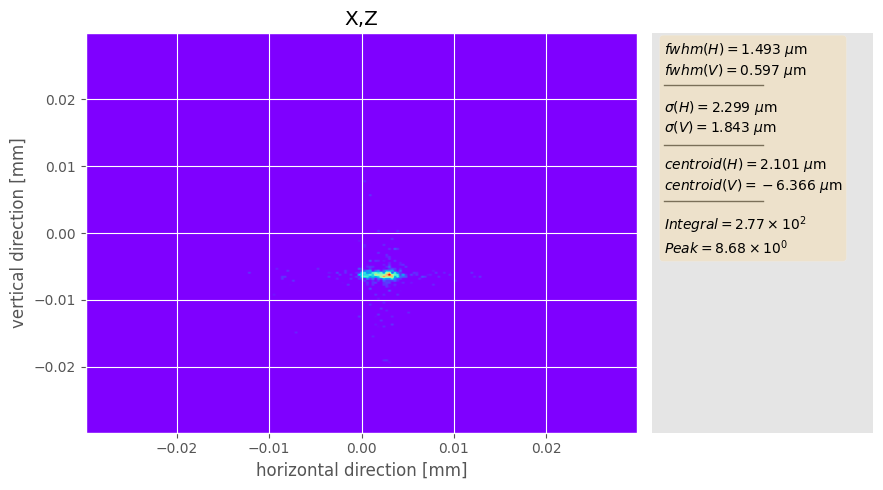

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


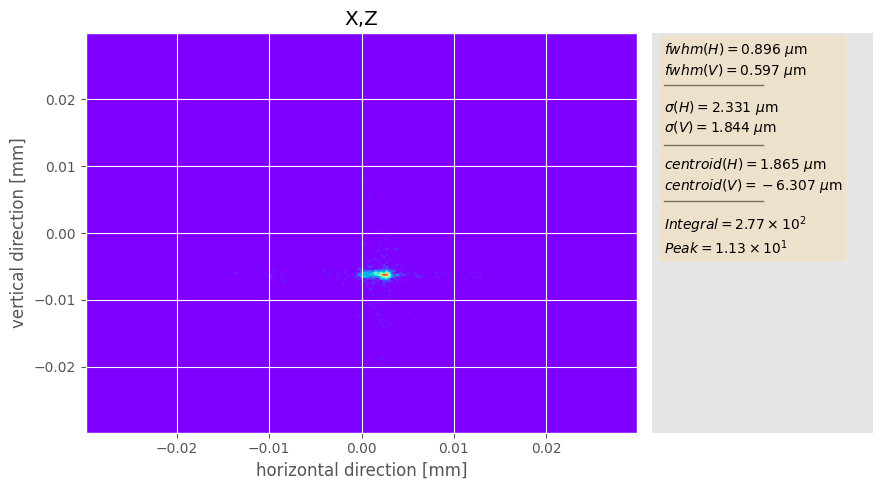

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


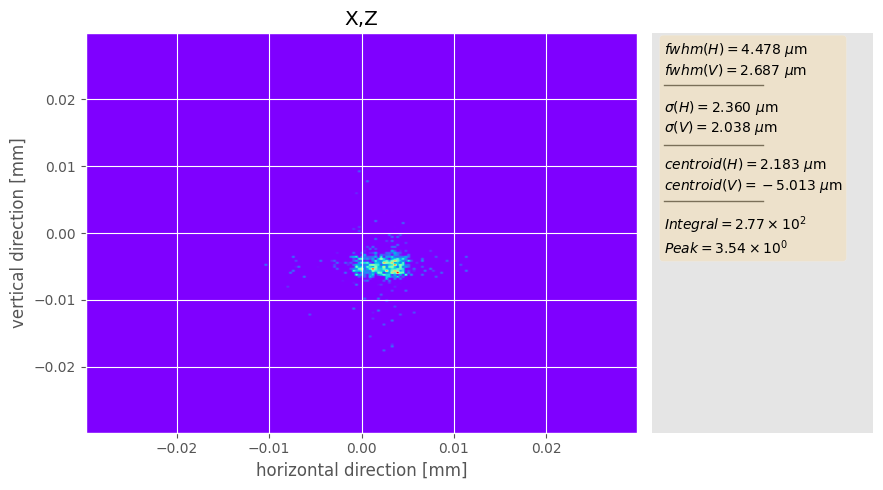

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


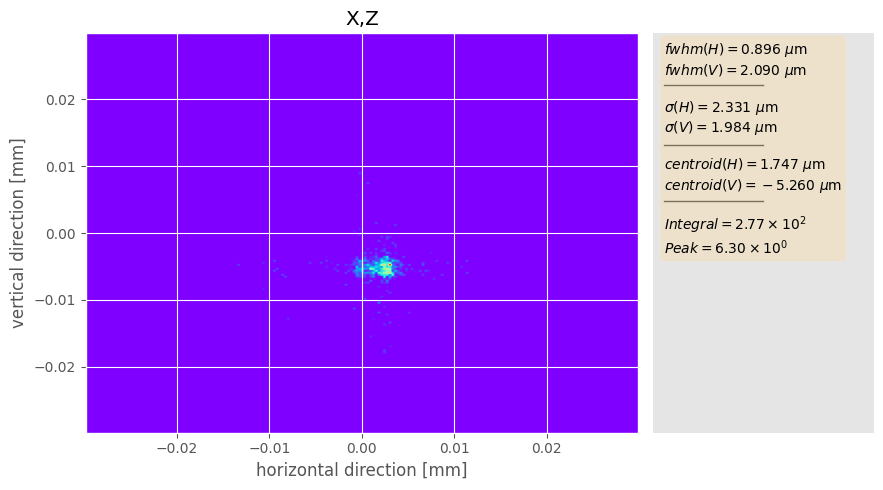

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


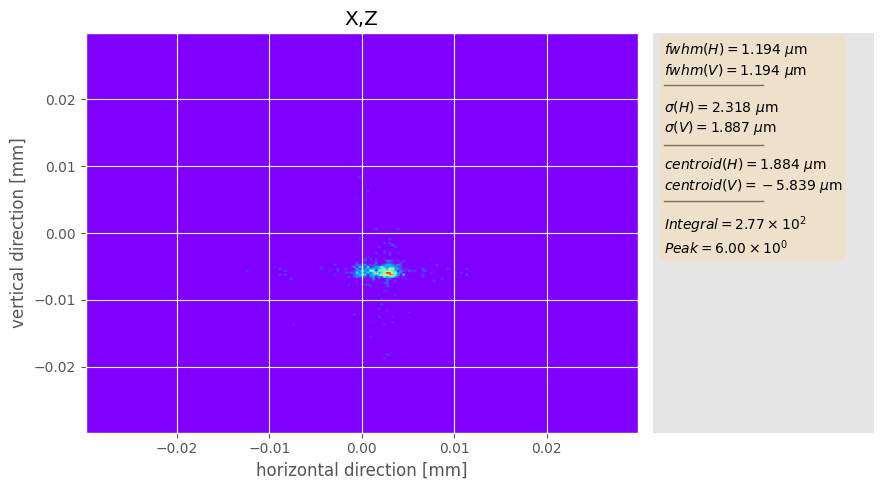

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


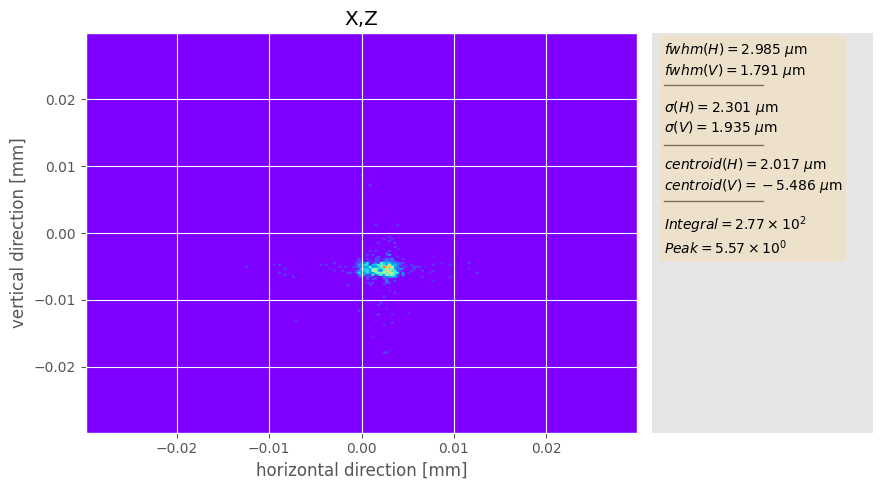

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


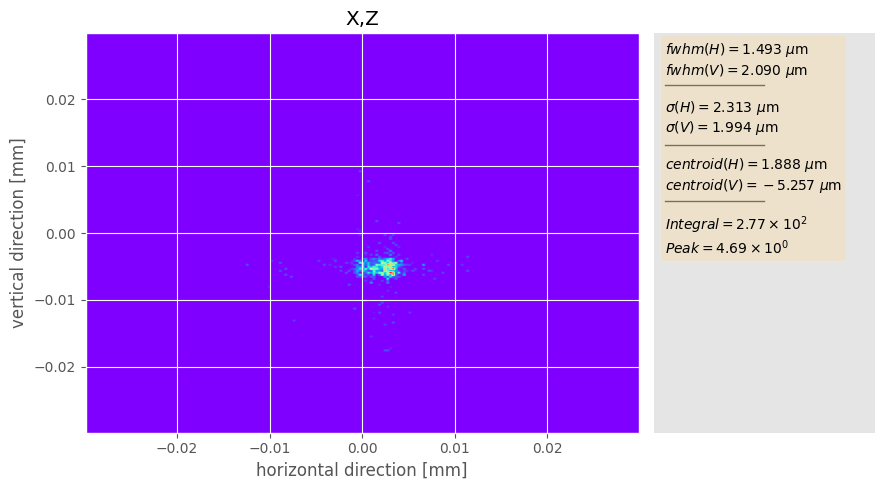

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


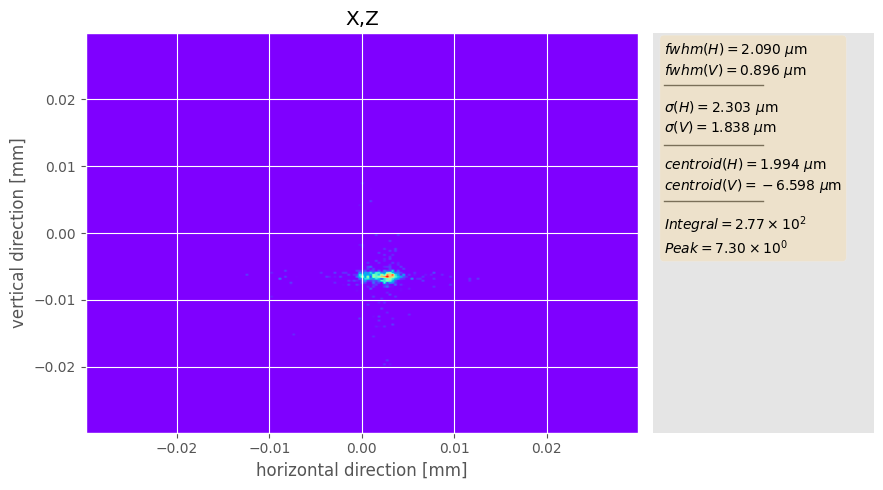

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


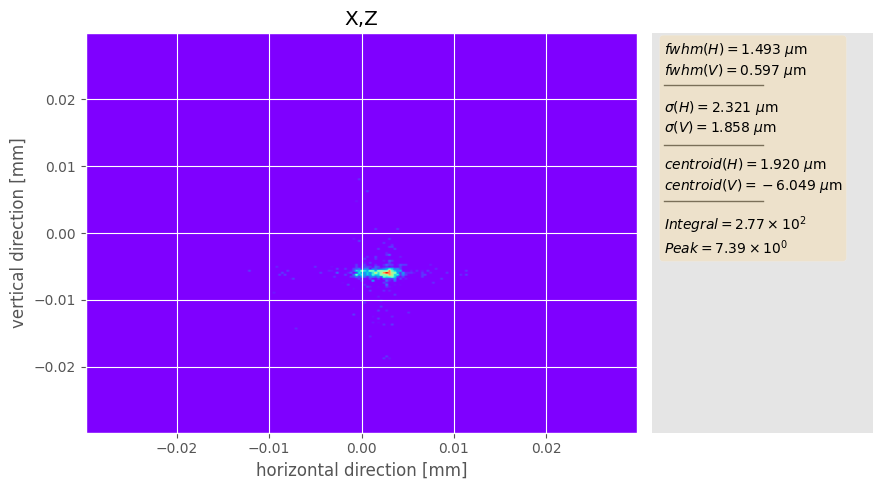

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


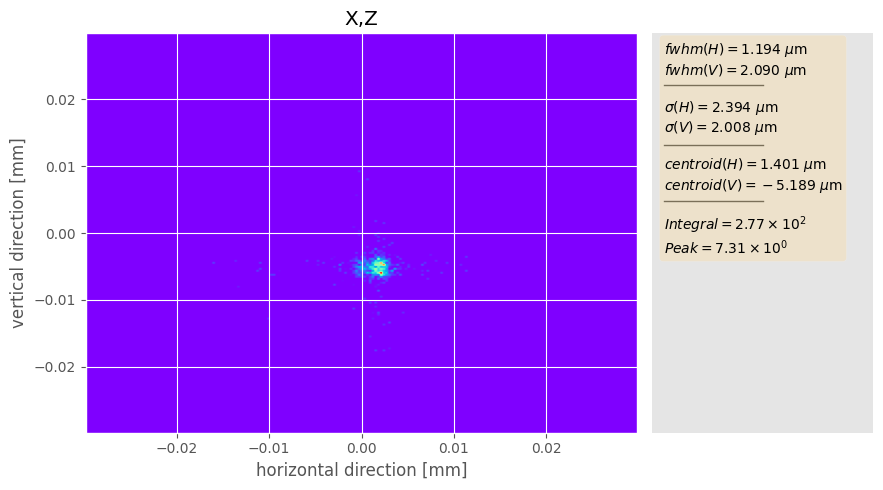

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


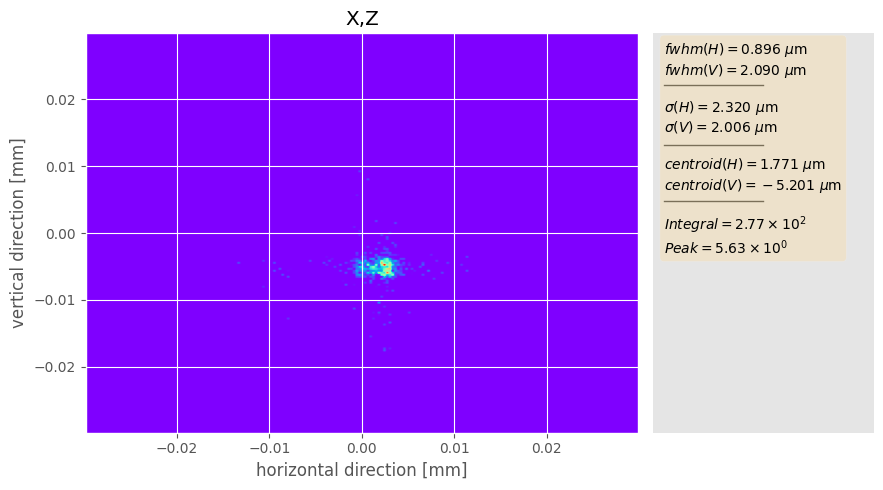

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


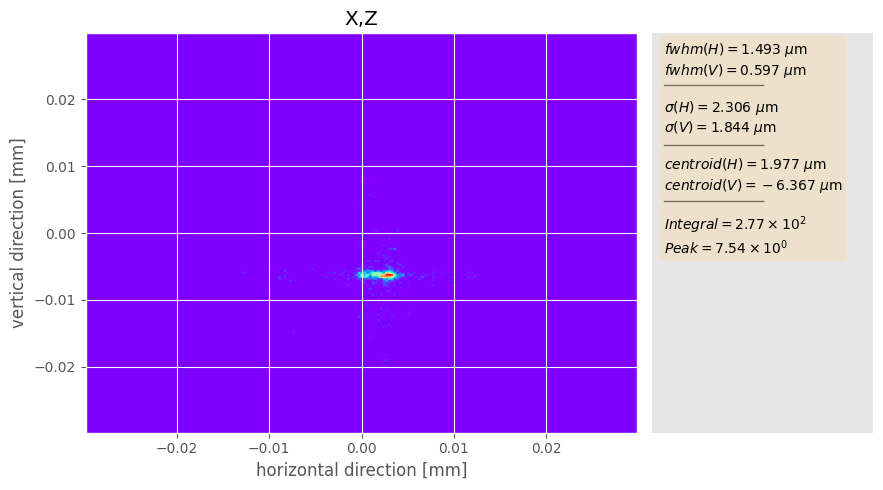

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


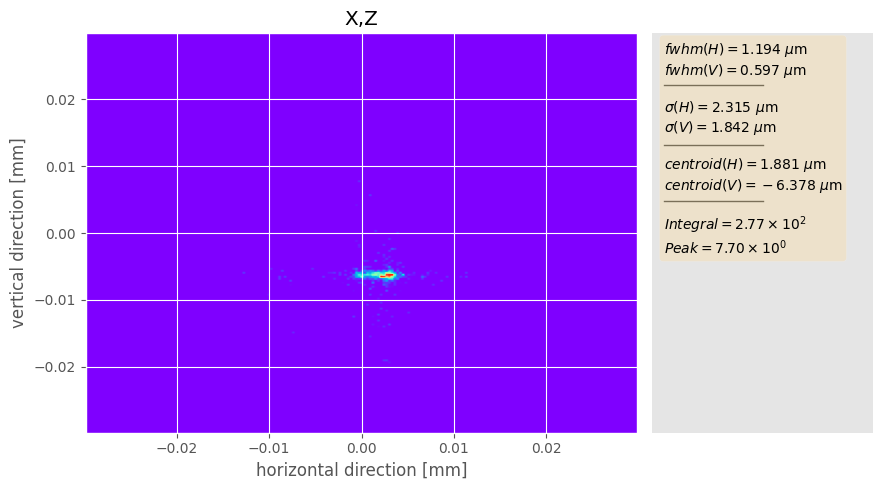

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


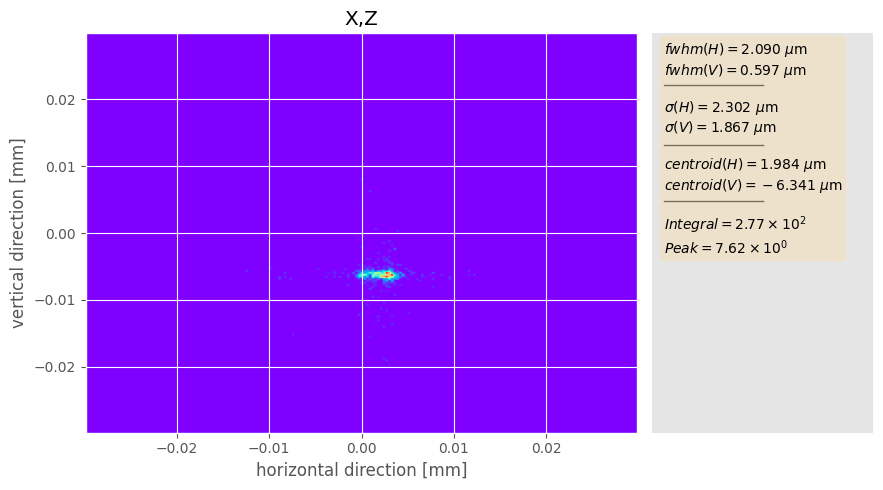

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


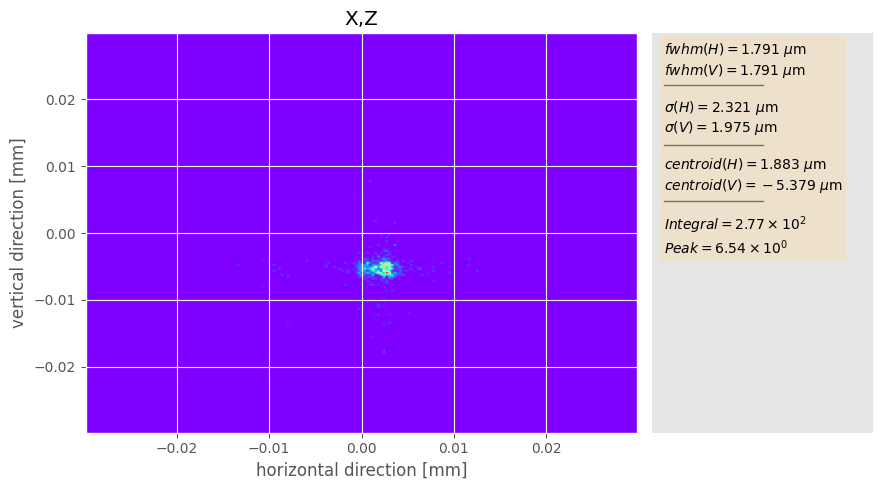

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


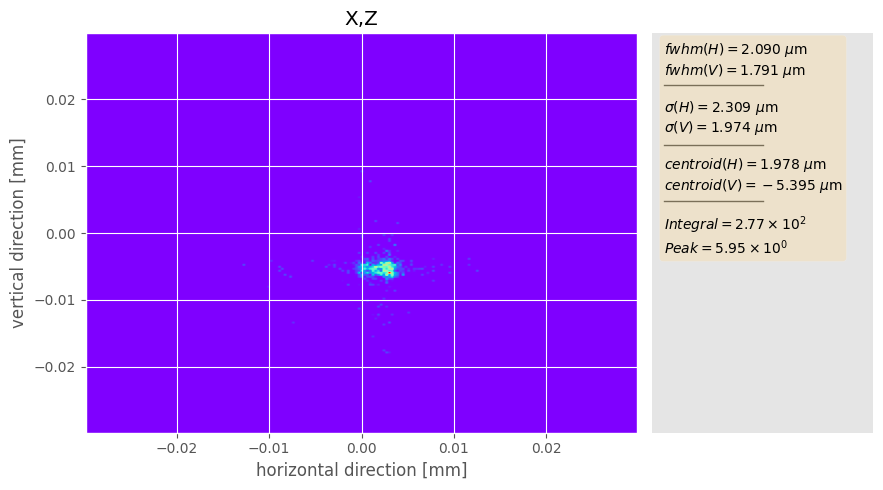

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_19162/Downstream_HKB_bender_profile.dat written to disk.


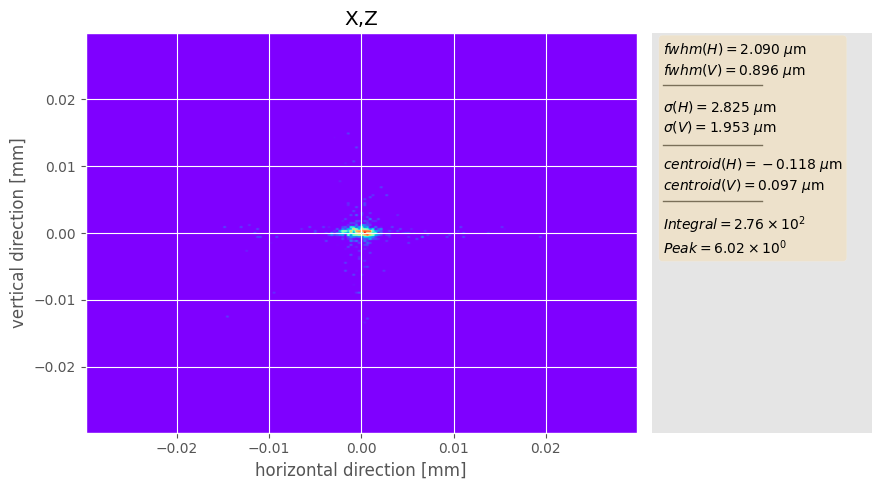

In [198]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

### Comparison to non-pareto procedure

In [179]:
focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


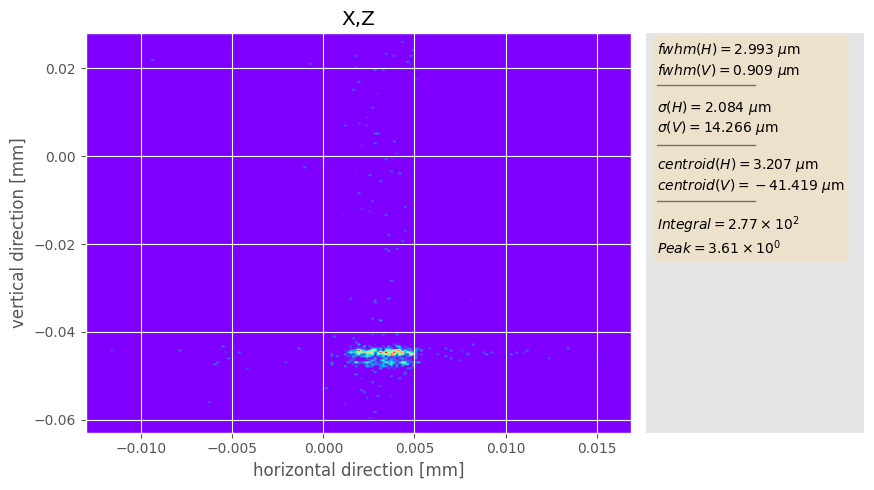

In [180]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [181]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=False)
                            #camera_xrange=[-0.03, 0.03],
                            #camera_yrange=[-0.03, 0.03],
                            #camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

In [182]:
opt_trial.reset()

In [183]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()))

[I 2022-09-22 00:44:57,236] A new study created in memory with name: no-name-009bc42a-089c-44fc-97f8-124c9a5bab3d


In [184]:
opt_trial.trials(200, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28601/1436929021.py:62: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
[I 2022-09-22 00:44:58,426] Trial 0 finished with value: 0.04154251027593936 and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.04154251027593936.
[I 2022-09-22 00:44:59,471] Trial 1 finished with value: 0.048336480368425735 and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.011273353740028353, 'vkb_3': -0.006037365984045364, 'hkb_4': 13.600000000000001, 'vkb_4': -10.399999999999999}. Best is trial 0 with value: 0.04154251027593936.
[I 2022-09-22 00:45:01,132] Trial 2 finished with value: 0.07219547704881642 and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hk

In [185]:
opt_trial._objective(opt_trial.study.best_trial)

7.734026350646235e-05

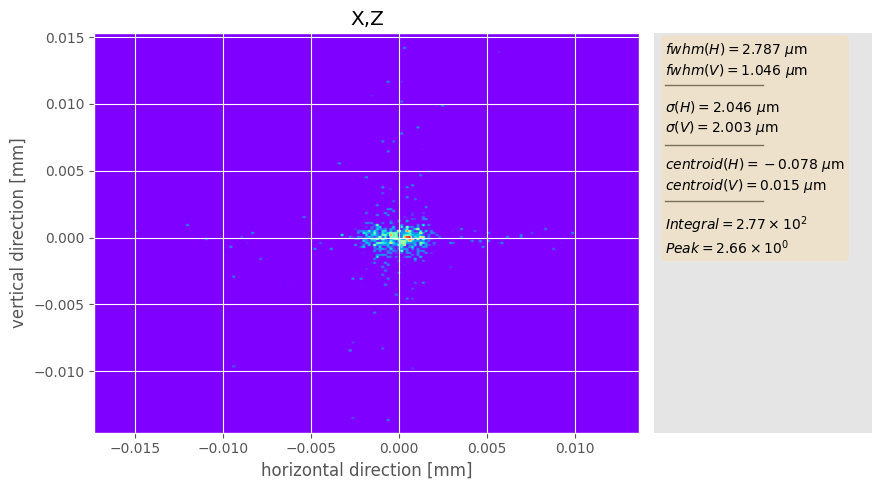

In [186]:
plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [187]:
opt_trial2 = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()),
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False)
                            #camera_xrange=[-0.03, 0.03],
                            #camera_yrange=[-0.03, 0.03],
                            #camera_nbins=512)

In [188]:
opt_trial2.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()))

[I 2022-09-22 09:15:30,578] A new study created in memory with name: no-name-bcf7b0ce-a563-4ab0-9acd-bf740fd19643


In [189]:
opt_trial2.trials(200, trial_motor_types=['hkb_1', 'hkb_2', 'vkb_1', 'vkb_2'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28601/1436929021.py:62: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
[I 2022-09-22 09:15:31,709] Trial 0 finished with value: 0.0028634924039486163 and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/samplers/_partial_fixed.py:109: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.01839724354387525, log=False, low=-0.02, step=0.0017453292519943296).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:33,853] Trial 1 finished with value: 0.0031426398199127796 and parameters: {'hkb_1': 29.753199999999993, 'vkb_1': -16.036500000000004, 'hkb_2': 23.063499999999998, 'vkb_2': 11.160699999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:35,178] Trial 2 finished with value: 0.0029319748076944295 and parameters: {'hkb_1': -22.0229, 'vkb_1': -19.8121, 'hkb_2': 11.974099999999993, 'vkb_2': -8.206300000000002, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:36,228] Trial 3 finished with value: 0.003104130751743769 and parameters: {'hkb_1': -17.750700000000002, 'vkb_1': 20.324199999999998, 'hkb_2': -22.103, 'vkb_2': -29.8731, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:37,756] Trial 4 finished with value: 0.002900156060284469 and parameters: {'hkb_1': 23.921299999999995, 'vkb_1': -5.180500000000002, 'hkb_2': -22.8082, 'vkb_2': -12.581100000000003, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:38,820] Trial 5 finished with value: 0.002990641341747195 and parameters: {'hkb_1': -8.121200000000002, 'vkb_1': -1.3826000000000036, 'hkb_2': -27.3266, 'vkb_2': -25.2909, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:40,266] Trial 6 finished with value: 0.002927465461106204 and parameters: {'hkb_1': -8.962200000000003, 'vkb_1': -9.565100000000001, 'hkb_2': 13.716899999999995, 'vkb_2': -15.001700000000001, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:41,753] Trial 7 finished with value: 0.0028856828256723296 and parameters: {'hkb_1': 10.599199999999996, 'vkb_1': 1.5353999999999957, 'hkb_2': 2.2723999999999975, 'vkb_2': 0.6975999999999978, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:42,856] Trial 8 finished with value: 0.0029562111520328215 and parameters: {'hkb_1': -8.631900000000002, 'vkb_1': -0.32690000000000197, 'hkb_2': -27.521, 'vkb_2': -9.589200000000002, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:44,507] Trial 9 finished with value: 0.002917430124968882 and parameters: {'hkb_1': 28.896799999999992, 'vkb_1': 0.5342999999999982, 'hkb_2': -21.1684, 'vkb_2': 3.2138999999999953, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:45,876] Trial 10 finished with value: 0.0030805752336799117 and parameters: {'hkb_1': 10.012799999999999, 'vkb_1': 14.431399999999996, 'hkb_2': -8.404000000000003, 'vkb_2': 29.159899999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:47,308] Trial 11 finished with value: 0.0029469264192630573 and parameters: {'hkb_1': 8.601999999999997, 'vkb_1': 9.249199999999995, 'hkb_2': -0.7391000000000041, 'vkb_2': 11.5824, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:48,744] Trial 12 finished with value: 0.003110409108435185 and parameters: {'hkb_1': 10.8341, 'vkb_1': 26.2125, 'hkb_2': -6.273200000000003, 'vkb_2': 2.460899999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 0 with value: 0.0028634924039486163.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:50,208] Trial 13 finished with value: 0.002860622051882321 and parameters: {'hkb_1': 1.816399999999998, 'vkb_1': -28.6271, 'hkb_2': 6.596899999999998, 'vkb_2': 14.518699999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:51,702] Trial 14 finished with value: 0.0028620068837828558 and parameters: {'hkb_1': -1.597100000000001, 'vkb_1': -28.6542, 'hkb_2': 10.036099999999998, 'vkb_2': 20.820199999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:53,641] Trial 15 finished with value: 0.002997687359366654 and parameters: {'hkb_1': 1.0442999999999962, 'vkb_1': -28.6336, 'hkb_2': 26.969599999999993, 'vkb_2': 28.265199999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:55,429] Trial 16 finished with value: 0.002931215851766564 and parameters: {'hkb_1': 17.738499999999995, 'vkb_1': -29.1554, 'hkb_2': 11.504299999999994, 'vkb_2': 19.393099999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:56,969] Trial 17 finished with value: 0.00290047395767865 and parameters: {'hkb_1': -3.7546000000000035, 'vkb_1': -21.1795, 'hkb_2': 18.666799999999995, 'vkb_2': 20.030199999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:58,267] Trial 18 finished with value: 0.002895846640696039 and parameters: {'hkb_1': -27.3901, 'vkb_1': -15.403300000000002, 'hkb_2': 6.295399999999994, 'vkb_2': 17.987899999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:15:59,457] Trial 19 finished with value: 0.0028855552922936035 and parameters: {'hkb_1': -15.361900000000002, 'vkb_1': -24.1053, 'hkb_2': -9.5135, 'vkb_2': 10.805699999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:01,201] Trial 20 finished with value: 0.0029395604840745104 and parameters: {'hkb_1': 5.4805999999999955, 'vkb_1': -12.226000000000003, 'hkb_2': 19.0355, 'vkb_2': 24.404999999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:02,586] Trial 21 finished with value: 0.00293281562732162 and parameters: {'hkb_1': 0.7065999999999981, 'vkb_1': 8.490199999999994, 'hkb_2': 4.7087999999999965, 'vkb_2': 8.368299999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:03,833] Trial 22 finished with value: 0.002876051167523247 and parameters: {'hkb_1': -3.4165000000000028, 'vkb_1': -23.9332, 'hkb_2': -2.2967000000000013, 'vkb_2': -2.758900000000004, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 13 with value: 0.002860622051882321.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:05,290] Trial 23 finished with value: 0.0028576847634820086 and parameters: {'hkb_1': 16.1117, 'vkb_1': -6.200900000000001, 'hkb_2': -13.628300000000003, 'vkb_2': 16.082099999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 23 with value: 0.0028576847634820086.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:06,813] Trial 24 finished with value: 0.0028541527552216504 and parameters: {'hkb_1': 18.9595, 'vkb_1': -29.7891, 'hkb_2': -15.644800000000002, 'vkb_2': 18.465899999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 24 with value: 0.0028541527552216504.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:08,282] Trial 25 finished with value: 0.0028500252784633764 and parameters: {'hkb_1': 17.056799999999996, 'vkb_1': -8.4343, 'hkb_2': -13.701500000000003, 'vkb_2': 15.738299999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 25 with value: 0.0028500252784633764.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:09,760] Trial 26 finished with value: 0.002869220909638694 and parameters: {'hkb_1': 18.040499999999994, 'vkb_1': -8.744400000000002, 'hkb_2': -14.639600000000002, 'vkb_2': 23.558999999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 25 with value: 0.0028500252784633764.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:11,205] Trial 27 finished with value: 0.002908864875335243 and parameters: {'hkb_1': 17.444199999999995, 'vkb_1': 5.638499999999993, 'hkb_2': -15.470300000000002, 'vkb_2': 6.5689999999999955, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 25 with value: 0.0028500252784633764.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:12,847] Trial 28 finished with value: 0.0028795963062651915 and parameters: {'hkb_1': 22.192099999999996, 'vkb_1': -4.563100000000002, 'hkb_2': -15.108200000000002, 'vkb_2': 14.663999999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 25 with value: 0.0028500252784633764.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:14,278] Trial 29 finished with value: 0.002828921566787271 and parameters: {'hkb_1': 14.207799999999999, 'vkb_1': -16.8074, 'hkb_2': -11.9236, 'vkb_2': 15.529499999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 29 with value: 0.002828921566787271.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:15,839] Trial 30 finished with value: 0.00286167679094016 and parameters: {'hkb_1': 23.861699999999992, 'vkb_1': -17.0295, 'hkb_2': -18.506300000000003, 'vkb_2': 24.280699999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 29 with value: 0.002828921566787271.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:17,283] Trial 31 finished with value: 0.002838484602645599 and parameters: {'hkb_1': 15.013999999999996, 'vkb_1': -11.662700000000001, 'hkb_2': -11.200000000000003, 'vkb_2': 15.101299999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 29 with value: 0.002828921566787271.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:18,733] Trial 32 finished with value: 0.0028395824218763787 and parameters: {'hkb_1': 14.324099999999994, 'vkb_1': -10.296100000000003, 'hkb_2': -10.5243, 'vkb_2': 6.270299999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 29 with value: 0.002828921566787271.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:20,209] Trial 33 finished with value: 0.0028406625985395945 and parameters: {'hkb_1': 13.277699999999996, 'vkb_1': -12.203400000000002, 'hkb_2': -4.5745000000000005, 'vkb_2': 6.218699999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 29 with value: 0.002828921566787271.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:21,698] Trial 34 finished with value: 0.002859625877975227 and parameters: {'hkb_1': 13.5535, 'vkb_1': -15.0767, 'hkb_2': -4.2058000000000035, 'vkb_2': -3.637800000000002, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 29 with value: 0.002828921566787271.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:23,036] Trial 35 finished with value: 0.002828710302687117 and parameters: {'hkb_1': 7.000999999999998, 'vkb_1': -12.474600000000002, 'hkb_2': -8.7117, 'vkb_2': 5.606299999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 35 with value: 0.002828710302687117.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:24,491] Trial 36 finished with value: 0.0028266912294828837 and parameters: {'hkb_1': 6.843199999999996, 'vkb_1': -19.9952, 'hkb_2': -10.020000000000003, 'vkb_2': 10.880299999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 36 with value: 0.0028266912294828837.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:25,822] Trial 37 finished with value: 0.002826080313888485 and parameters: {'hkb_1': 5.131099999999996, 'vkb_1': -19.6325, 'hkb_2': -10.812600000000003, 'vkb_2': 10.585899999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:27,063] Trial 38 finished with value: 0.0028553074964604193 and parameters: {'hkb_1': 4.2087999999999965, 'vkb_1': -19.4479, 'hkb_2': -23.7928, 'vkb_2': 11.756799999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:28,356] Trial 39 finished with value: 0.002873245246143877 and parameters: {'hkb_1': 6.817699999999995, 'vkb_1': -23.5521, 'hkb_2': -18.9536, 'vkb_2': -2.419500000000003, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:29,718] Trial 40 finished with value: 0.002870617861095604 and parameters: {'hkb_1': 4.104999999999997, 'vkb_1': -19.543, 'hkb_2': -6.650100000000002, 'vkb_2': -7.010400000000001, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:31,059] Trial 41 finished with value: 0.002827016300892137 and parameters: {'hkb_1': 8.378099999999996, 'vkb_1': -17.0588, 'hkb_2': -10.844600000000003, 'vkb_2': 10.880199999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:32,541] Trial 42 finished with value: 0.002836689735081535 and parameters: {'hkb_1': 7.945599999999999, 'vkb_1': -17.4938, 'hkb_2': 0.9114999999999966, 'vkb_2': 8.901399999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:33,936] Trial 43 finished with value: 0.002832605122906904 and parameters: {'hkb_1': 10.673099999999998, 'vkb_1': -14.196900000000001, 'hkb_2': -11.150500000000001, 'vkb_2': 4.416899999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:35,145] Trial 44 finished with value: 0.00284899533205654 and parameters: {'hkb_1': -6.053300000000004, 'vkb_1': -25.364, 'hkb_2': -8.532000000000004, 'vkb_2': 12.039299999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:36,402] Trial 45 finished with value: 0.0028567241613423793 and parameters: {'hkb_1': 3.3613, 'vkb_1': -20.227200000000003, 'hkb_2': -18.3714, 'vkb_2': 0.6860999999999962, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:37,819] Trial 46 finished with value: 0.002853786717973673 and parameters: {'hkb_1': 6.8836999999999975, 'vkb_1': -3.015500000000003, 'hkb_2': -2.7536000000000023, 'vkb_2': 9.235599999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:38,905] Trial 47 finished with value: 0.0029326464536537835 and parameters: {'hkb_1': -11.845200000000002, 'vkb_1': -22.3266, 'hkb_2': -24.5561, 'vkb_2': 4.268299999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:40,495] Trial 48 finished with value: 0.002977608032831524 and parameters: {'hkb_1': 20.579599999999992, 'vkb_1': -25.9026, 'hkb_2': -7.510100000000001, 'vkb_2': -18.8042, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:42,141] Trial 49 finished with value: 0.0028752256646662282 and parameters: {'hkb_1': 27.976399999999998, 'vkb_1': -17.784, 'hkb_2': -21.0098, 'vkb_2': 13.043499999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:43,579] Trial 50 finished with value: 0.002841679084580903 and parameters: {'hkb_1': 10.443199999999997, 'vkb_1': -6.5882000000000005, 'hkb_2': -4.868600000000001, 'vkb_2': 1.6195999999999984, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:44,910] Trial 51 finished with value: 0.0028359384064569333 and parameters: {'hkb_1': 11.6207, 'vkb_1': -13.380600000000001, 'hkb_2': -17.5529, 'vkb_2': 5.599999999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:46,275] Trial 52 finished with value: 0.0028305660658316375 and parameters: {'hkb_1': 8.905999999999999, 'vkb_1': -14.7825, 'hkb_2': -12.378200000000003, 'vkb_2': 8.603499999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:47,472] Trial 53 finished with value: 0.002844384845675106 and parameters: {'hkb_1': -1.783100000000001, 'vkb_1': -16.4048, 'hkb_2': -12.464400000000001, 'vkb_2': 9.410699999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:48,847] Trial 54 finished with value: 0.002826758242579018 and parameters: {'hkb_1': 8.758299999999998, 'vkb_1': -18.665300000000002, 'hkb_2': -8.941100000000002, 'vkb_2': 13.417699999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:50,176] Trial 55 finished with value: 0.0028337980847841686 and parameters: {'hkb_1': 2.7641999999999953, 'vkb_1': -26.2313, 'hkb_2': -9.0746, 'vkb_2': 16.923699999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:51,501] Trial 56 finished with value: 0.0028292931754860225 and parameters: {'hkb_1': -0.635900000000003, 'vkb_1': -20.765, 'hkb_2': -0.885500000000004, 'vkb_2': 13.345199999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 37 with value: 0.002826080313888485.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:52,966] Trial 57 finished with value: 0.0028252788384529512 and parameters: {'hkb_1': 5.997399999999999, 'vkb_1': -18.3009, 'hkb_2': -6.491100000000003, 'vkb_2': 10.882099999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:54,335] Trial 58 finished with value: 0.003061580904716025 and parameters: {'hkb_1': 5.532199999999996, 'vkb_1': 17.283899999999996, 'hkb_2': -5.720700000000001, 'vkb_2': 20.679799999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:55,750] Trial 59 finished with value: 0.002854449964725134 and parameters: {'hkb_1': 1.7911999999999964, 'vkb_1': -19.4845, 'hkb_2': 2.696099999999994, 'vkb_2': -0.5373000000000019, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:57,244] Trial 60 finished with value: 0.0031462136105631262 and parameters: {'hkb_1': 12.401699999999998, 'vkb_1': 25.458699999999993, 'hkb_2': -2.1890000000000036, 'vkb_2': 11.023599999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:16:58,629] Trial 61 finished with value: 0.002826364691835415 and parameters: {'hkb_1': 8.774999999999999, 'vkb_1': -21.898699999999998, 'hkb_2': -7.689600000000002, 'vkb_2': 22.015499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:00,013] Trial 62 finished with value: 0.0028292843407975985 and parameters: {'hkb_1': 8.850499999999997, 'vkb_1': -22.2487, 'hkb_2': -8.255600000000001, 'vkb_2': 27.281299999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:01,356] Trial 63 finished with value: 0.0028454490536361865 and parameters: {'hkb_1': 5.458199999999998, 'vkb_1': -27.4828, 'hkb_2': -6.920000000000002, 'vkb_2': 7.454999999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 57 with value: 0.0028252788384529512.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:02,748] Trial 64 finished with value: 0.002824225811498987 and parameters: {'hkb_1': 6.824399999999997, 'vkb_1': -18.5079, 'hkb_2': -9.814400000000003, 'vkb_2': 17.4683, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:03,968] Trial 65 finished with value: 0.0028417896792004805 and parameters: {'hkb_1': 0.26219999999999644, 'vkb_1': -22.8047, 'hkb_2': -16.3414, 'vkb_2': 22.307699999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:05,435] Trial 66 finished with value: 0.0028377971620482667 and parameters: {'hkb_1': 9.3506, 'vkb_1': -18.654700000000002, 'hkb_2': -10.104400000000002, 'vkb_2': 26.666499999999992, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:06,815] Trial 67 finished with value: 0.0028297028948652573 and parameters: {'hkb_1': 4.564699999999995, 'vkb_1': -24.6196, 'hkb_2': -3.2939000000000007, 'vkb_2': 18.478899999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:07,987] Trial 68 finished with value: 0.002845128000105349 and parameters: {'hkb_1': -3.7238000000000007, 'vkb_1': -21.393900000000002, 'hkb_2': -12.769000000000002, 'vkb_2': 21.429999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:09,514] Trial 69 finished with value: 0.002850560767217117 and parameters: {'hkb_1': 11.419799999999995, 'vkb_1': -27.574, 'hkb_2': 0.7150999999999961, 'vkb_2': 17.190499999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:10,943] Trial 70 finished with value: 0.0028322651352137946 and parameters: {'hkb_1': 7.162499999999994, 'vkb_1': -10.012800000000002, 'hkb_2': -4.752500000000001, 'vkb_2': 13.875399999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:12,262] Trial 71 finished with value: 0.0028267931136380276 and parameters: {'hkb_1': 2.3577999999999975, 'vkb_1': -13.288600000000002, 'hkb_2': -9.718800000000002, 'vkb_2': 9.822499999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:13,562] Trial 72 finished with value: 0.002830355293351652 and parameters: {'hkb_1': 2.7468000000000004, 'vkb_1': -16.455800000000004, 'hkb_2': -10.123600000000003, 'vkb_2': 10.286999999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:14,752] Trial 73 finished with value: 0.00284380481927645 and parameters: {'hkb_1': -1.7036000000000016, 'vkb_1': -18.7678, 'hkb_2': -14.266300000000001, 'vkb_2': 19.211999999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 64 with value: 0.002824225811498987.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:16,150] Trial 74 finished with value: 0.002821052593747102 and parameters: {'hkb_1': 5.576699999999995, 'vkb_1': -13.773400000000002, 'hkb_2': -6.560700000000001, 'vkb_2': 12.630999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:17,443] Trial 75 finished with value: 0.002826523970710698 and parameters: {'hkb_1': 1.631999999999998, 'vkb_1': -14.187400000000002, 'hkb_2': -6.622900000000001, 'vkb_2': 16.385199999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:18,838] Trial 76 finished with value: 0.002839602675616049 and parameters: {'hkb_1': 6.160299999999999, 'vkb_1': -7.799200000000003, 'hkb_2': -6.398400000000002, 'vkb_2': 16.471999999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:20,089] Trial 77 finished with value: 0.0028556123530218704 and parameters: {'hkb_1': -5.904100000000003, 'vkb_1': -10.7085, 'hkb_2': -7.405100000000001, 'vkb_2': 22.967299999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:21,666] Trial 78 finished with value: 0.0029650099795409585 and parameters: {'hkb_1': 15.703699999999998, 'vkb_1': 4.127699999999997, 'hkb_2': -1.2545000000000037, 'vkb_2': 25.108299999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:23,097] Trial 79 finished with value: 0.0028333015387982685 and parameters: {'hkb_1': 4.243599999999994, 'vkb_1': -15.266200000000001, 'hkb_2': 2.3134999999999977, 'vkb_2': 13.723699999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:24,450] Trial 80 finished with value: 0.002824629250897599 and parameters: {'hkb_1': 1.3871999999999964, 'vkb_1': -21.5935, 'hkb_2': -4.411100000000001, 'vkb_2': 19.890699999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:25,910] Trial 81 finished with value: 0.0028265280303220583 and parameters: {'hkb_1': 0.08489999999999753, 'vkb_1': -20.572200000000002, 'hkb_2': -3.5191000000000017, 'vkb_2': 17.9869, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:27,225] Trial 82 finished with value: 0.0028274785316314147 and parameters: {'hkb_1': -0.7043000000000035, 'vkb_1': -20.9589, 'hkb_2': -3.636700000000001, 'vkb_2': 19.785799999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:28,631] Trial 83 finished with value: 0.0028523431338505476 and parameters: {'hkb_1': 1.3726999999999983, 'vkb_1': -21.1508, 'hkb_2': 4.214199999999998, 'vkb_2': 29.944999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:29,925] Trial 84 finished with value: 0.002841860292714016 and parameters: {'hkb_1': -5.911300000000001, 'vkb_1': -23.749000000000002, 'hkb_2': -5.555100000000003, 'vkb_2': 18.296299999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:31,157] Trial 85 finished with value: 0.002898627683179274 and parameters: {'hkb_1': -23.7367, 'vkb_1': -22.5551, 'hkb_2': -1.6815000000000033, 'vkb_2': 26.047999999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:32,523] Trial 86 finished with value: 0.0028350463371191624 and parameters: {'hkb_1': 0.46729999999999805, 'vkb_1': -26.9683, 'hkb_2': -0.07380000000000209, 'vkb_2': 21.421699999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:33,804] Trial 87 finished with value: 0.002828387827355317 and parameters: {'hkb_1': -2.094400000000004, 'vkb_1': -14.1636, 'hkb_2': -5.698400000000003, 'vkb_2': 15.584899999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:35,158] Trial 88 finished with value: 0.0029624075157024697 and parameters: {'hkb_1': 3.8296999999999954, 'vkb_1': -18.148600000000002, 'hkb_2': -3.8941000000000017, 'vkb_2': -28.1685, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:36,501] Trial 89 finished with value: 0.002829773903767931 and parameters: {'hkb_1': 5.624599999999994, 'vkb_1': -24.1862, 'hkb_2': -7.778400000000001, 'vkb_2': 12.417499999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:37,688] Trial 90 finished with value: 0.002844450445839046 and parameters: {'hkb_1': -3.169500000000003, 'vkb_1': -16.2592, 'hkb_2': -13.490400000000001, 'vkb_2': 17.882999999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:39,028] Trial 91 finished with value: 0.0028230226660826527 and parameters: {'hkb_1': 7.334999999999994, 'vkb_1': -19.922400000000003, 'hkb_2': -10.855800000000002, 'vkb_2': 15.003599999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:40,367] Trial 92 finished with value: 0.0028257435394276015 and parameters: {'hkb_1': 7.244, 'vkb_1': -20.6369, 'hkb_2': -11.058400000000002, 'vkb_2': 14.797999999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:41,701] Trial 93 finished with value: 0.0028316710551989487 and parameters: {'hkb_1': 7.915199999999999, 'vkb_1': -24.902900000000002, 'hkb_2': -11.260900000000003, 'vkb_2': 14.973899999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:43,122] Trial 94 finished with value: 0.002826621253592529 and parameters: {'hkb_1': 9.979799999999997, 'vkb_1': -20.3264, 'hkb_2': -6.717200000000002, 'vkb_2': 19.721899999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:44,388] Trial 95 finished with value: 0.0028299533988853146 and parameters: {'hkb_1': 5.134999999999998, 'vkb_1': -17.4833, 'hkb_2': -15.796800000000001, 'vkb_2': 16.593399999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:45,655] Trial 96 finished with value: 0.0028332090065817496 and parameters: {'hkb_1': 3.0231999999999957, 'vkb_1': -21.626800000000003, 'hkb_2': -11.804400000000001, 'vkb_2': 23.968899999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:46,967] Trial 97 finished with value: 0.0028316905561391902 and parameters: {'hkb_1': 1.4218999999999973, 'vkb_1': -15.537200000000002, 'hkb_2': -8.349700000000002, 'vkb_2': 20.946199999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:48,369] Trial 98 finished with value: 0.002830482209067879 and parameters: {'hkb_1': 7.572099999999999, 'vkb_1': -11.487200000000001, 'hkb_2': -4.736200000000004, 'vkb_2': 14.969499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:49,863] Trial 99 finished with value: 0.002834250671842283 and parameters: {'hkb_1': 11.576499999999996, 'vkb_1': -23.1674, 'hkb_2': -2.7245000000000026, 'vkb_2': 22.524299999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:51,512] Trial 100 finished with value: 0.002897907229338848 and parameters: {'hkb_1': 6.221899999999998, 'vkb_1': -19.419, 'hkb_2': 15.695599999999999, 'vkb_2': 17.665999999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:52,976] Trial 101 finished with value: 0.0028315616847517933 and parameters: {'hkb_1': 12.638299999999994, 'vkb_1': -20.9516, 'hkb_2': -6.641100000000002, 'vkb_2': 19.569899999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:54,386] Trial 102 finished with value: 0.0028285728401081485 and parameters: {'hkb_1': 10.018999999999998, 'vkb_1': -19.902900000000002, 'hkb_2': -9.340700000000002, 'vkb_2': 12.176299999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:55,912] Trial 103 finished with value: 0.0028275226252248297 and parameters: {'hkb_1': 9.456799999999994, 'vkb_1': -17.9708, 'hkb_2': -6.548700000000004, 'vkb_2': 16.250799999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:57,145] Trial 104 finished with value: 0.00283347072133941 and parameters: {'hkb_1': -0.12040000000000362, 'vkb_1': -22.7268, 'hkb_2': -13.3262, 'vkb_2': 19.265199999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:58,511] Trial 105 finished with value: 0.0028242005263574366 and parameters: {'hkb_1': 3.711199999999998, 'vkb_1': -13.841000000000001, 'hkb_2': -7.529200000000003, 'vkb_2': 14.179499999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:17:59,752] Trial 106 finished with value: 0.002837352701740276 and parameters: {'hkb_1': 3.6298999999999992, 'vkb_1': -13.382100000000001, 'hkb_2': -16.922200000000004, 'vkb_2': 14.552499999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:01,014] Trial 107 finished with value: 0.002828149427722295 and parameters: {'hkb_1': 2.0208999999999975, 'vkb_1': -15.940100000000001, 'hkb_2': -11.549800000000001, 'vkb_2': 13.039499999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:02,292] Trial 108 finished with value: 0.0028315555088197983 and parameters: {'hkb_1': 4.792299999999997, 'vkb_1': -14.6978, 'hkb_2': -14.752300000000002, 'vkb_2': 7.831999999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:03,642] Trial 109 finished with value: 0.002903502571098242 and parameters: {'hkb_1': 6.963099999999997, 'vkb_1': -16.982100000000003, 'hkb_2': -8.325800000000001, 'vkb_2': -17.857100000000003, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:04,916] Trial 110 finished with value: 0.002828325142319538 and parameters: {'hkb_1': 1.0493999999999986, 'vkb_1': -18.8988, 'hkb_2': -9.962700000000002, 'vkb_2': 11.652399999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:06,327] Trial 111 finished with value: 0.002830802338309001 and parameters: {'hkb_1': 10.471699999999998, 'vkb_1': -25.7613, 'hkb_2': -7.483500000000003, 'vkb_2': 22.027699999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:07,726] Trial 112 finished with value: 0.002827838936566559 and parameters: {'hkb_1': 8.0961, 'vkb_1': -19.6657, 'hkb_2': -5.471800000000002, 'vkb_2': 17.1637, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:09,126] Trial 113 finished with value: 0.0028271971961336714 and parameters: {'hkb_1': 5.803199999999997, 'vkb_1': -21.7419, 'hkb_2': -3.173300000000001, 'vkb_2': 18.540699999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:10,478] Trial 114 finished with value: 0.0028235438410854122 and parameters: {'hkb_1': 3.4380999999999986, 'vkb_1': -20.417, 'hkb_2': -4.256900000000002, 'vkb_2': 20.754699999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:11,877] Trial 115 finished with value: 0.0028476350629737406 and parameters: {'hkb_1': 4.008499999999998, 'vkb_1': -12.8671, 'hkb_2': -0.7338000000000022, 'vkb_2': 25.243799999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:13,213] Trial 116 finished with value: 0.0029816266504499433 and parameters: {'hkb_1': 2.5097999999999985, 'vkb_1': 12.423499999999997, 'hkb_2': -4.304200000000002, 'vkb_2': 15.763799999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:14,463] Trial 117 finished with value: 0.002832284346833094 and parameters: {'hkb_1': -1.2149000000000036, 'vkb_1': -17.8399, 'hkb_2': -10.3853, 'vkb_2': 20.631399999999992, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:15,886] Trial 118 finished with value: 0.0028338423399679267 and parameters: {'hkb_1': 4.8414, 'vkb_1': -23.8687, 'hkb_2': 0.514599999999998, 'vkb_2': 13.855199999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:17,641] Trial 119 finished with value: 0.0030091510518609303 and parameters: {'hkb_1': 0.25819999999999865, 'vkb_1': -14.0981, 'hkb_2': 27.280799999999992, 'vkb_2': 28.076399999999992, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:18,843] Trial 120 finished with value: 0.002848351919191581 and parameters: {'hkb_1': -2.707100000000004, 'vkb_1': -11.377100000000002, 'hkb_2': -12.481200000000001, 'vkb_2': 10.112599999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:20,082] Trial 121 finished with value: 0.0028345314656752487 and parameters: {'hkb_1': -4.7668000000000035, 'vkb_1': -19.9167, 'hkb_2': -7.121700000000001, 'vkb_2': 20.178499999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:21,535] Trial 122 finished with value: 0.0028297825502759328 and parameters: {'hkb_1': 9.054399999999994, 'vkb_1': -20.846, 'hkb_2': -2.1250000000000036, 'vkb_2': 18.788299999999992, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:22,902] Trial 123 finished with value: 0.0028247089252572736 and parameters: {'hkb_1': 6.9450999999999965, 'vkb_1': -18.820300000000003, 'hkb_2': -9.236400000000003, 'vkb_2': 17.7461, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:24,238] Trial 124 finished with value: 0.0028248432360527425 and parameters: {'hkb_1': 6.319799999999994, 'vkb_1': -18.569000000000003, 'hkb_2': -9.119000000000003, 'vkb_2': 16.629599999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:25,729] Trial 125 finished with value: 0.002822965749718385 and parameters: {'hkb_1': 7.516999999999996, 'vkb_1': -16.726300000000002, 'hkb_2': -8.812600000000003, 'vkb_2': 14.335899999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:27,076] Trial 126 finished with value: 0.002823605754403898 and parameters: {'hkb_1': 6.446399999999997, 'vkb_1': -16.5681, 'hkb_2': -8.942900000000002, 'vkb_2': 12.549499999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:28,441] Trial 127 finished with value: 0.002822263818039277 and parameters: {'hkb_1': 6.534399999999998, 'vkb_1': -17.1511, 'hkb_2': -8.7817, 'vkb_2': 12.931799999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:29,804] Trial 128 finished with value: 0.0028217429783024056 and parameters: {'hkb_1': 6.648399999999995, 'vkb_1': -15.9457, 'hkb_2': -8.690100000000001, 'vkb_2': 14.545499999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:31,167] Trial 129 finished with value: 0.0028291680150565692 and parameters: {'hkb_1': 5.877699999999997, 'vkb_1': -9.1706, 'hkb_2': -8.729700000000001, 'vkb_2': 12.441999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:32,538] Trial 130 finished with value: 0.002827264279647961 and parameters: {'hkb_1': 7.995099999999994, 'vkb_1': -15.8557, 'hkb_2': -9.090500000000002, 'vkb_2': 14.094499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:33,879] Trial 131 finished with value: 0.0028243358089573606 and parameters: {'hkb_1': 6.582799999999999, 'vkb_1': -17.6537, 'hkb_2': -10.758300000000002, 'vkb_2': 15.015499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:35,239] Trial 132 finished with value: 0.0028228164289651097 and parameters: {'hkb_1': 6.6410999999999945, 'vkb_1': -16.9379, 'hkb_2': -9.653300000000002, 'vkb_2': 15.689099999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:36,543] Trial 133 finished with value: 0.0028263244006129615 and parameters: {'hkb_1': 3.539199999999994, 'vkb_1': -16.470200000000002, 'hkb_2': -10.181000000000001, 'vkb_2': 15.510999999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:37,908] Trial 134 finished with value: 0.0028213133964485613 and parameters: {'hkb_1': 6.969199999999994, 'vkb_1': -17.7742, 'hkb_2': -8.738000000000003, 'vkb_2': 17.161399999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:39,258] Trial 135 finished with value: 0.002829283806235461 and parameters: {'hkb_1': 7.626899999999999, 'vkb_1': -17.259500000000003, 'hkb_2': -12.262800000000002, 'vkb_2': 13.111299999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:40,726] Trial 136 finished with value: 0.0028325382096761227 and parameters: {'hkb_1': 11.757599999999996, 'vkb_1': -15.472900000000001, 'hkb_2': -5.3149000000000015, 'vkb_2': 14.331799999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:42,004] Trial 137 finished with value: 0.002830176079466264 and parameters: {'hkb_1': 4.638399999999997, 'vkb_1': -13.1417, 'hkb_2': -13.7118, 'vkb_2': 11.544399999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:43,363] Trial 138 finished with value: 0.0028221307118274776 and parameters: {'hkb_1': 6.586999999999996, 'vkb_1': -17.051000000000002, 'hkb_2': -7.913100000000004, 'vkb_2': 17.327499999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:45,208] Trial 139 finished with value: 0.0030066762456751944 and parameters: {'hkb_1': 9.3906, 'vkb_1': -15.043500000000002, 'hkb_2': 25.676099999999998, 'vkb_2': 15.752999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:46,552] Trial 140 finished with value: 0.0028600870222957324 and parameters: {'hkb_1': 10.594999999999999, 'vkb_1': -16.6934, 'hkb_2': -29.4803, 'vkb_2': 17.133199999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:47,903] Trial 141 finished with value: 0.0028210987701536975 and parameters: {'hkb_1': 6.683899999999994, 'vkb_1': -17.901400000000002, 'hkb_2': -8.029500000000002, 'vkb_2': 18.153299999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:49,226] Trial 142 finished with value: 0.002822080756097866 and parameters: {'hkb_1': 2.9638999999999953, 'vkb_1': -17.777500000000003, 'hkb_2': -7.9862, 'vkb_2': 13.1954, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:50,553] Trial 143 finished with value: 0.0028221570407097824 and parameters: {'hkb_1': 3.106899999999996, 'vkb_1': -17.673000000000002, 'hkb_2': -7.705400000000001, 'vkb_2': 13.431199999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:51,886] Trial 144 finished with value: 0.0028214071904580263 and parameters: {'hkb_1': 3.0715000000000003, 'vkb_1': -14.716500000000002, 'hkb_2': -7.653400000000001, 'vkb_2': 12.881299999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:53,213] Trial 145 finished with value: 0.002828049308817023 and parameters: {'hkb_1': 3.0671999999999997, 'vkb_1': -12.546600000000002, 'hkb_2': -7.890200000000004, 'vkb_2': 9.216099999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:54,592] Trial 146 finished with value: 0.0028232398593837226 and parameters: {'hkb_1': 5.012999999999998, 'vkb_1': -14.559400000000002, 'hkb_2': -5.9238000000000035, 'vkb_2': 12.793599999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:55,927] Trial 147 finished with value: 0.0028248710976527753 and parameters: {'hkb_1': 2.5359999999999943, 'vkb_1': -15.509100000000002, 'hkb_2': -5.788600000000002, 'vkb_2': 11.742099999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:57,255] Trial 148 finished with value: 0.0028236093828422205 and parameters: {'hkb_1': 4.6055999999999955, 'vkb_1': -14.818000000000001, 'hkb_2': -7.985700000000001, 'vkb_2': 13.296599999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:18:58,798] Trial 149 finished with value: 0.002830000321401475 and parameters: {'hkb_1': 8.406999999999996, 'vkb_1': -16.704300000000003, 'hkb_2': -5.955700000000004, 'vkb_2': 6.989099999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:00,108] Trial 150 finished with value: 0.00282337985922924 and parameters: {'hkb_1': 5.140099999999997, 'vkb_1': -17.559800000000003, 'hkb_2': -11.389700000000001, 'vkb_2': 10.133999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:01,416] Trial 151 finished with value: 0.0028250754928544728 and parameters: {'hkb_1': 5.434699999999999, 'vkb_1': -17.2039, 'hkb_2': -11.508600000000001, 'vkb_2': 10.527699999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:02,751] Trial 152 finished with value: 0.0028241882321099238 and parameters: {'hkb_1': 5.1541, 'vkb_1': -18.3764, 'hkb_2': -8.886800000000001, 'vkb_2': 12.494599999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:04,110] Trial 153 finished with value: 0.002830519181382144 and parameters: {'hkb_1': 7.891299999999994, 'vkb_1': -11.837300000000003, 'hkb_2': -10.2024, 'vkb_2': 13.489799999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:05,433] Trial 154 finished with value: 0.003171056979643558 and parameters: {'hkb_1': 3.363499999999995, 'vkb_1': 28.824899999999992, 'hkb_2': -7.5455000000000005, 'vkb_2': 8.303899999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:06,772] Trial 155 finished with value: 0.0028296067294139196 and parameters: {'hkb_1': 5.646899999999995, 'vkb_1': -14.541000000000002, 'hkb_2': -12.681000000000001, 'vkb_2': 11.6772, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:08,107] Trial 156 finished with value: 0.002872871698777048 and parameters: {'hkb_1': 6.6678, 'vkb_1': -16.169400000000003, 'hkb_2': -11.397200000000002, 'vkb_2': -10.584700000000002, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:09,451] Trial 157 finished with value: 0.0028238276493676353 and parameters: {'hkb_1': 4.520799999999994, 'vkb_1': -17.683300000000003, 'hkb_2': -6.210000000000001, 'vkb_2': 15.503999999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:10,786] Trial 158 finished with value: 0.002829029452704007 and parameters: {'hkb_1': 2.1739999999999995, 'vkb_1': -10.653500000000001, 'hkb_2': -5.102200000000003, 'vkb_2': 9.6618, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:12,192] Trial 159 finished with value: 0.002825812881221978 and parameters: {'hkb_1': 8.761799999999994, 'vkb_1': -19.3851, 'hkb_2': -8.558100000000003, 'vkb_2': 12.796499999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:13,503] Trial 160 finished with value: 0.0028243215504310335 and parameters: {'hkb_1': 3.8081999999999994, 'vkb_1': -15.955400000000001, 'hkb_2': -9.535600000000002, 'vkb_2': 10.668499999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:14,848] Trial 161 finished with value: 0.002822143787234745 and parameters: {'hkb_1': 5.533199999999994, 'vkb_1': -15.2314, 'hkb_2': -7.560600000000001, 'vkb_2': 13.481499999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:16,233] Trial 162 finished with value: 0.002824097179865676 and parameters: {'hkb_1': 6.7896, 'vkb_1': -14.345400000000001, 'hkb_2': -7.120600000000003, 'vkb_2': 14.109399999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:17,644] Trial 163 finished with value: 0.0028822104698392422 and parameters: {'hkb_1': 5.634399999999999, 'vkb_1': 0.5109999999999957, 'hkb_2': -4.403800000000004, 'vkb_2': 16.807399999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:19,027] Trial 164 finished with value: 0.0028612577773733192 and parameters: {'hkb_1': 7.837899999999998, 'vkb_1': -2.414500000000004, 'hkb_2': -8.208400000000001, 'vkb_2': 14.908199999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:20,418] Trial 165 finished with value: 0.002828570936682499 and parameters: {'hkb_1': 9.811499999999995, 'vkb_1': -12.975800000000003, 'hkb_2': -10.068700000000003, 'vkb_2': 12.448499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:21,782] Trial 166 finished with value: 0.0028222188655973065 and parameters: {'hkb_1': 4.706399999999995, 'vkb_1': -17.1982, 'hkb_2': -6.221100000000003, 'vkb_2': 15.886999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:23,153] Trial 167 finished with value: 0.002824570203618105 and parameters: {'hkb_1': 4.327399999999997, 'vkb_1': -18.0141, 'hkb_2': -5.804600000000001, 'vkb_2': 16.022099999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:24,489] Trial 168 finished with value: 0.002821193535222 and parameters: {'hkb_1': 2.8492999999999995, 'vkb_1': -19.3114, 'hkb_2': -6.5207000000000015, 'vkb_2': 14.852799999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:25,801] Trial 169 finished with value: 0.0028240080500724725 and parameters: {'hkb_1': 1.2692999999999977, 'vkb_1': -15.1109, 'hkb_2': -6.5732000000000035, 'vkb_2': 14.417099999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:27,112] Trial 170 finished with value: 0.002828535482532078 and parameters: {'hkb_1': 2.494099999999996, 'vkb_1': -19.0839, 'hkb_2': -11.105300000000003, 'vkb_2': 16.173099999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:28,450] Trial 171 finished with value: 0.0028238024905762366 and parameters: {'hkb_1': 3.4202999999999975, 'vkb_1': -17.3427, 'hkb_2': -7.3047, 'vkb_2': 17.717699999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:29,835] Trial 172 finished with value: 0.002822370362375814 and parameters: {'hkb_1': 5.037399999999998, 'vkb_1': -19.7611, 'hkb_2': -4.049300000000002, 'vkb_2': 13.665399999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:31,359] Trial 173 finished with value: 0.0028265255045973243 and parameters: {'hkb_1': 5.5092, 'vkb_1': -18.9813, 'hkb_2': -2.9212000000000025, 'vkb_2': 13.835499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:32,750] Trial 174 finished with value: 0.002826632575288987 and parameters: {'hkb_1': 7.3264, 'vkb_1': -16.2223, 'hkb_2': -7.265000000000001, 'vkb_2': 11.175899999999999, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:34,281] Trial 175 finished with value: 0.0028516778039524124 and parameters: {'hkb_1': 4.980899999999998, 'vkb_1': -17.3375, 'hkb_2': 8.369, 'vkb_2': 14.765499999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:35,710] Trial 176 finished with value: 0.0028332973278379064 and parameters: {'hkb_1': 8.502699999999997, 'vkb_1': -14.142900000000001, 'hkb_2': -4.980800000000002, 'vkb_2': 16.300199999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:37,069] Trial 177 finished with value: 0.0028215392458044836 and parameters: {'hkb_1': 6.763499999999993, 'vkb_1': -18.3337, 'hkb_2': -8.167800000000003, 'vkb_2': 13.317999999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:38,432] Trial 178 finished with value: 0.002822367726735243 and parameters: {'hkb_1': 6.598799999999997, 'vkb_1': -19.9174, 'hkb_2': -8.233700000000002, 'vkb_2': 13.037399999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 74 with value: 0.002821052593747102.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:39,804] Trial 179 finished with value: 0.002820594386870849 and parameters: {'hkb_1': 6.642099999999999, 'vkb_1': -19.7956, 'hkb_2': -8.131900000000002, 'vkb_2': 18.826899999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 179 with value: 0.002820594386870849.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:41,192] Trial 180 finished with value: 0.002819674265284552 and parameters: {'hkb_1': 6.485099999999996, 'vkb_1': -19.9124, 'hkb_2': -8.177700000000002, 'vkb_2': 18.496999999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:42,374] Trial 181 finished with value: 0.0029295051124569333 and parameters: {'hkb_1': -29.2709, 'vkb_1': -22.2708, 'hkb_2': -8.453000000000003, 'vkb_2': 18.553499999999993, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:43,754] Trial 182 finished with value: 0.0028221740747109295 and parameters: {'hkb_1': 6.6691999999999965, 'vkb_1': -19.9818, 'hkb_2': -7.888100000000001, 'vkb_2': 17.049799999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:45,130] Trial 183 finished with value: 0.0028220379740172795 and parameters: {'hkb_1': 6.386499999999998, 'vkb_1': -20.3326, 'hkb_2': -7.075500000000002, 'vkb_2': 18.905799999999992, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:46,514] Trial 184 finished with value: 0.0028220183622501742 and parameters: {'hkb_1': 6.561999999999998, 'vkb_1': -20.457700000000003, 'hkb_2': -6.8637000000000015, 'vkb_2': 18.646699999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:47,924] Trial 185 finished with value: 0.002824770024042822 and parameters: {'hkb_1': 9.4193, 'vkb_1': -21.8619, 'hkb_2': -7.042300000000001, 'vkb_2': 18.926199999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:49,286] Trial 186 finished with value: 0.0028237384901919982 and parameters: {'hkb_1': 6.264499999999998, 'vkb_1': -20.928, 'hkb_2': -7.9238000000000035, 'vkb_2': 17.539299999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:50,696] Trial 187 finished with value: 0.0028269016173136647 and parameters: {'hkb_1': 8.523699999999998, 'vkb_1': -18.5365, 'hkb_2': -6.158700000000003, 'vkb_2': 19.912799999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:52,052] Trial 188 finished with value: 0.002864781407513431 and parameters: {'hkb_1': 6.312799999999996, 'vkb_1': -19.942300000000003, 'hkb_2': -7.695100000000004, 'vkb_2': -5.781200000000002, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:53,379] Trial 189 finished with value: 0.0028245629214582895 and parameters: {'hkb_1': 3.716299999999997, 'vkb_1': -22.6206, 'hkb_2': -9.384700000000002, 'vkb_2': 18.492199999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:54,728] Trial 190 finished with value: 0.0028247422901101138 and parameters: {'hkb_1': 1.8679999999999986, 'vkb_1': -20.6806, 'hkb_2': -5.314000000000004, 'vkb_2': 21.4426, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:55,958] Trial 191 finished with value: 0.0028595727039166844 and parameters: {'hkb_1': -13.923100000000002, 'vkb_1': -19.438000000000002, 'hkb_2': -3.9452000000000034, 'vkb_2': 17.022999999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:57,306] Trial 192 finished with value: 0.0028270267660840407 and parameters: {'hkb_1': 4.486799999999995, 'vkb_1': -18.764400000000002, 'hkb_2': -6.593200000000003, 'vkb_2': 17.991699999999994, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:19:58,671] Trial 193 finished with value: 0.0028200683652344497 and parameters: {'hkb_1': 6.063599999999994, 'vkb_1': -20.2478, 'hkb_2': -8.167700000000004, 'vkb_2': 19.254599999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:00,045] Trial 194 finished with value: 0.0028217925385916175 and parameters: {'hkb_1': 7.194199999999995, 'vkb_1': -21.498800000000003, 'hkb_2': -8.247600000000002, 'vkb_2': 19.400399999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:01,576] Trial 195 finished with value: 0.0028284915879790927 and parameters: {'hkb_1': 7.987699999999997, 'vkb_1': -23.0913, 'hkb_2': -9.856300000000001, 'vkb_2': 20.012999999999998, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:02,933] Trial 196 finished with value: 0.0028250264945570936 and parameters: {'hkb_1': 5.9437, 'vkb_1': -21.272100000000002, 'hkb_2': -6.9338000000000015, 'vkb_2': 22.743899999999996, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:04,348] Trial 197 finished with value: 0.002826986526566186 and parameters: {'hkb_1': 10.579499999999996, 'vkb_1': -18.3276, 'hkb_2': -8.498000000000001, 'vkb_2': 19.331399999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:05,752] Trial 198 finished with value: 0.0028272248682184296 and parameters: {'hkb_1': 7.569999999999993, 'vkb_1': -21.882, 'hkb_2': -5.544100000000004, 'vkb_2': 20.768899999999995, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:06,911] Trial 199 finished with value: 0.0029594111471349387 and parameters: {'hkb_1': -20.293100000000003, 'vkb_1': 2.035899999999998, 'hkb_2': -7.802000000000003, 'vkb_2': 18.772799999999997, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. Best is trial 180 with value: 0.002819674265284552.


In [190]:
opt_trial2._objective(opt_trial2.study.best_trial)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_frozen.py:343: UserWarning: The value 0.0 of the parameter 'hkb_3' is out of the range of the distribution FloatDistribution(high=0.01839724354387525, log=False, low=-0.02, step=0.0017453292519943296).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_frozen.py:343: UserWarning: The value 0.0 of the parameter 'vkb_3' is out of the range of the distribution FloatDistribution(high=0.01839724354387525, log=False, low=-0.02, step=0.0017453292519943296).
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


0.0028191004380113175

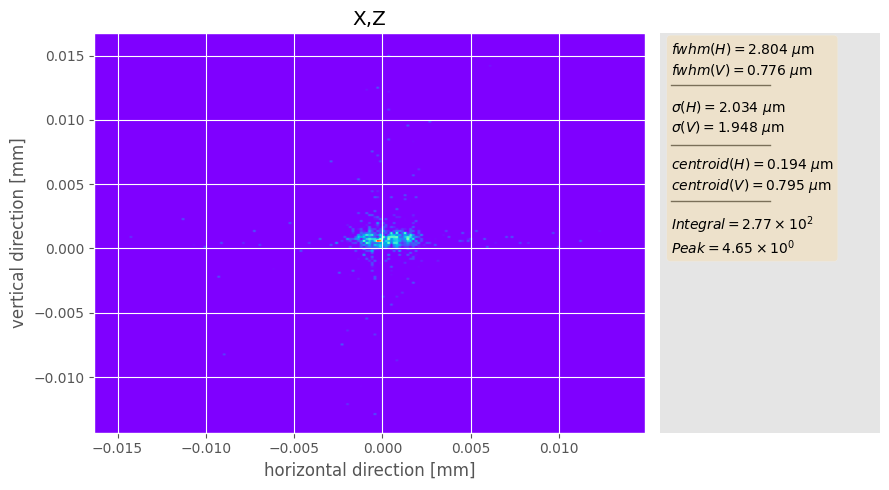

In [191]:
plot_shadow_beam_spatial_distribution(opt_trial2.beam_state.photon_beam, xrange=opt_trial2._camera_xrange, yrange=opt_trial2._camera_yrange)

In [192]:

opt_trial3 = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True)
                            #camera_xrange=[-0.03, 0.03],
                            #camera_yrange=[-0.03, 0.03],
                            #camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

In [193]:
opt_trial3.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()))

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28601/1436929021.py:25: FutureWarning: MOTPESampler has been deprecated in v2.9.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.9.0.
  base_sampler = optuna.samplers.MOTPESampler()
[I 2022-09-22 09:20:10,067] A new study created in memory with name: no-name-17a5bd19-cc41-4a11-9c94-b15d7696ccc7


In [194]:
opt_trial3.trials(200)#, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

[I 2022-09-22 09:20:11,245] Trial 0 finished with values: [0.0008138535468650073, 0.0028191004380113175] and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:12,438] Trial 1 finished with values: [0.03717820557348741, 0.01516351260112927] and parameters: {'hkb_1': -29.7239, 'vkb_1': 9.089599999999997, 'hkb_2': -3.2497000000000007, 'vkb_2': -17.1316, 'hkb_3': 0.011415926535897934, 'vkb_3': 0.011415926535897934, 'hkb_4': -13.8, 'vkb_4': -17.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:14,115] Trial 2 finished with values: [0.020851484367631457, 0.004068206840969821] and parameters: {'hkb_1': 22.783599999999993, 'vkb_1': -22.145200000000003, 'hkb_2': 2.893099999999997, 'vkb_2': -22.8916, 'hkb_3': 0.0044346095279206126, 'vkb_3': 0.0061799387799149445, 'hkb_4': -3.8999999999999986, 'vkb_4': 15.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:15,707] Trial 3 finished with values: [0.007704613759891374, 0.003146076102852687] and parameters: {'hkb_1': 17.469099999999997, 'vkb_1': 26.119899999999994, 'hkb_2': -27.8809, 'vkb_2': -10.8033, 'hkb_3': -0.002546707480056705, 'vkb_3': -0.0008013782280623764, 'hkb_4': 6.300000000000001, 'vkb_4': -5.799999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:17,155] Trial 4 finished with values: [0.026898469016460994, 0.004461264788600874] and parameters: {'hkb_1': -9.739800000000002, 'vkb_1': -11.705900000000003, 'hkb_2': 8.140899999999995, 'vkb_2': -9.394900000000003, 'hkb_3': 0.018397243543875248, 'vkb_3': 0.016651914291880923, 'hkb_4': -12.7, 'vkb_4': 12.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:19,427] Trial 5 finished with values: [0.06156780423474932, 0.005141132945208286] and parameters: {'hkb_1': 28.877699999999997, 'vkb_1': 29.639399999999995, 'hkb_2': 19.196199999999997, 'vkb_2': 23.938599999999994, 'hkb_3': 0.0044346095279206126, 'vkb_3': -0.02, 'hkb_4': 12.300000000000004, 'vkb_4': 19.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:20,967] Trial 6 finished with values: [0.013124303141571541, 0.017949899409017638] and parameters: {'hkb_1': -22.5513, 'vkb_1': 0.09839999999999804, 'hkb_2': 6.805099999999996, 'vkb_2': 17.646499999999996, 'hkb_3': -0.013018682992022683, 'vkb_3': 0.0009439510239319555, 'hkb_4': -0.6999999999999993, 'vkb_4': 18.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:22,338] Trial 7 finished with values: [0.01195983560093021, 0.003165095230603955] and parameters: {'hkb_1': -15.102200000000002, 'vkb_1': -26.1473, 'hkb_2': 24.059899999999992, 'vkb_2': 23.377399999999994, 'hkb_3': 0.0061799387799149445, 'vkb_3': -0.0008013782280623764, 'hkb_4': -7.6, 'vkb_4': -11.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:23,498] Trial 8 finished with values: [0.022373198471515327, 0.009033725086979161] and parameters: {'hkb_1': -29.2719, 'vkb_1': 2.319099999999999, 'hkb_2': -10.976700000000001, 'vkb_2': 2.3955999999999946, 'hkb_3': 0.01490658503988659, 'vkb_3': 0.011415926535897934, 'hkb_4': 12.100000000000001, 'vkb_4': 15.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:24,777] Trial 9 finished with values: [0.006215073674485689, 0.0030080503595031334] and parameters: {'hkb_1': 7.9026, 'vkb_1': 22.642199999999995, 'hkb_2': -4.212700000000002, 'vkb_2': -28.2863, 'hkb_3': 0.011415926535897934, 'vkb_3': -0.0008013782280623764, 'hkb_4': 2.900000000000002, 'vkb_4': 6.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:26,701] Trial 10 finished with values: [0.0202763656780971, 0.0062648081712531195] and parameters: {'hkb_1': -0.08740000000000236, 'vkb_1': -11.953400000000002, 'hkb_2': -20.1474, 'vkb_2': 7.904699999999998, 'hkb_3': -0.02, 'vkb_3': -0.013018682992022683, 'hkb_4': 17.700000000000003, 'vkb_4': 1.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:28,571] Trial 11 finished with values: [0.04038292941390109, 0.023595391373774845] and parameters: {'hkb_1': 6.883199999999995, 'vkb_1': 15.009699999999995, 'hkb_2': 15.591399999999993, 'vkb_2': 11.661599999999993, 'hkb_3': -0.006037365984045364, 'vkb_3': -0.009528024488034022, 'hkb_4': -18.9, 'vkb_4': -3.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:30,574] Trial 12 finished with values: [0.03096302441159728, 0.010217074548533078] and parameters: {'hkb_1': -6.463400000000004, 'vkb_1': -11.744500000000002, 'hkb_2': 28.914199999999994, 'vkb_2': -2.4603000000000037, 'hkb_3': -0.011273353740028353, 'vkb_3': -0.013018682992022683, 'hkb_4': 19.800000000000004, 'vkb_4': -19.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:32,672] Trial 13 finished with values: [0.011387532561722587, 0.004935708867831723] and parameters: {'hkb_1': 12.949799999999996, 'vkb_1': 10.8722, 'hkb_2': -13.984300000000001, 'vkb_2': 29.201999999999998, 'hkb_3': -0.02, 'vkb_3': -0.007782695236039694, 'hkb_4': 6.700000000000003, 'vkb_4': 8.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:34,493] Trial 14 finished with values: [0.007561930825315669, 0.012599190983154455] and parameters: {'hkb_1': -0.6080000000000041, 'vkb_1': -19.0396, 'hkb_2': -27.3678, 'vkb_2': -3.526100000000003, 'hkb_3': -0.007782695236039694, 'vkb_3': 0.018397243543875248, 'hkb_4': -8.6, 'vkb_4': -11.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:36,170] Trial 15 finished with values: [0.01354651046887342, 0.021216251975024747] and parameters: {'hkb_1': -19.1308, 'vkb_1': -5.2683000000000035, 'hkb_2': 14.963999999999999, 'vkb_2': 7.667999999999999, 'hkb_3': -0.0008013782280623764, 'vkb_3': -0.018254670748005672, 'hkb_4': -19.2, 'vkb_4': 3.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:37,321] Trial 16 finished with values: [0.009479336414827856, 0.0030672940634602856] and parameters: {'hkb_1': -9.433400000000002, 'vkb_1': 19.692299999999996, 'hkb_2': -10.977400000000003, 'vkb_2': -14.339000000000002, 'hkb_3': 0.007925268031909273, 'vkb_3': 0.0061799387799149445, 'hkb_4': 12.300000000000004, 'vkb_4': -5.699999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:39,177] Trial 17 finished with values: [0.01586399890236805, 0.003355309599259773] and parameters: {'hkb_1': 7.165999999999997, 'vkb_1': 5.724399999999996, 'hkb_2': -17.5395, 'vkb_2': -28.7436, 'hkb_3': -0.014764012244017011, 'vkb_3': -0.007782695236039694, 'hkb_4': -3.3999999999999986, 'vkb_4': -12.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:41,179] Trial 18 finished with values: [0.016785297817773374, 0.003513606647473019] and parameters: {'hkb_1': 29.71249999999999, 'vkb_1': -4.072200000000002, 'hkb_2': -6.0151, 'vkb_2': 14.492599999999996, 'hkb_3': 0.0009439510239319555, 'vkb_3': 0.013161255787892259, 'hkb_4': 3.700000000000003, 'vkb_4': 9.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:43,188] Trial 19 finished with values: [0.009404794234890627, 0.007139304896864998] and parameters: {'hkb_1': 19.243399999999994, 'vkb_1': 16.2977, 'hkb_2': 9.482099999999996, 'vkb_2': 2.928699999999999, 'hkb_3': -0.006037365984045364, 'vkb_3': 0.0061799387799149445, 'hkb_4': -13.8, 'vkb_4': -1.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:44,526] Trial 20 finished with values: [0.004798766766916924, 0.0031550961010707894] and parameters: {'hkb_1': 7.349999999999994, 'vkb_1': -17.5607, 'hkb_2': 0.7841999999999985, 'vkb_2': -29.7989, 'hkb_3': 0.011415926535897934, 'vkb_3': -0.0042920367320510334, 'hkb_4': 2.200000000000003, 'vkb_4': 5.300000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:45,846] Trial 21 finished with values: [0.008913617087463244, 0.0033202507969894743] and parameters: {'hkb_1': -3.1114000000000033, 'vkb_1': -29.7783, 'hkb_2': 2.5097999999999985, 'vkb_2': -20.5092, 'hkb_3': 0.0009439510239319555, 'vkb_3': -0.0042920367320510334, 'hkb_4': 8.700000000000003, 'vkb_4': 5.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:47,691] Trial 22 finished with values: [0.026187503446120492, 0.008961766978229998] and parameters: {'hkb_1': 3.3581999999999965, 'vkb_1': -16.8506, 'hkb_2': -7.280600000000003, 'vkb_2': -8.346000000000004, 'hkb_3': -0.009528024488034022, 'vkb_3': -0.01650934149601134, 'hkb_4': 15.399999999999999, 'vkb_4': -15.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:49,726] Trial 23 finished with values: [0.007374945947949398, 0.0038134957413035924] and parameters: {'hkb_1': 12.625699999999995, 'vkb_1': -6.522800000000004, 'hkb_2': -0.11840000000000117, 'vkb_2': 22.603799999999993, 'hkb_3': -0.01650934149601134, 'vkb_3': 0.002689280275926284, 'hkb_4': -9.5, 'vkb_4': -8.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:50,922] Trial 24 finished with values: [0.0022497504472188423, 0.003089100858828448] and parameters: {'hkb_1': -15.0599, 'vkb_1': 6.046099999999996, 'hkb_2': -21.9621, 'vkb_2': 29.05239999999999, 'hkb_3': -0.0042920367320510334, 'vkb_3': -0.0042920367320510334, 'hkb_4': 0.9000000000000021, 'vkb_4': -1.3999999999999986}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:52,398] Trial 25 finished with values: [0.010753696785009956, 0.003132796561108963] and parameters: {'hkb_1': -15.911800000000001, 'vkb_1': 4.519199999999998, 'hkb_2': -21.994500000000002, 'vkb_2': 7.220099999999995, 'hkb_3': 0.018397243543875248, 'vkb_3': 0.01490658503988659, 'hkb_4': -3.3999999999999986, 'vkb_4': -1.0999999999999979}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:54,223] Trial 26 finished with values: [0.004553174015825335, 0.003597975589576782] and parameters: {'hkb_1': -22.6411, 'vkb_1': -1.9074000000000026, 'hkb_2': 27.475599999999993, 'vkb_2': 18.6134, 'hkb_3': -0.0042920367320510334, 'vkb_3': -0.014764012244017011, 'hkb_4': -5.699999999999999, 'vkb_4': 2.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:56,213] Trial 27 finished with values: [0.005500267993387548, 0.0030952156823393522] and parameters: {'hkb_1': 25.272799999999997, 'vkb_1': 11.716299999999997, 'hkb_2': 21.7581, 'vkb_2': -5.143200000000004, 'hkb_3': 0.01490658503988659, 'vkb_3': 0.009670597283903602, 'hkb_4': -1.0999999999999979, 'vkb_4': -2.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:58,321] Trial 28 finished with values: [0.013980278383111125, 0.0034032948792378777] and parameters: {'hkb_1': 14.945299999999996, 'vkb_1': -7.734500000000001, 'hkb_2': 14.354999999999997, 'vkb_2': 29.344799999999992, 'hkb_3': -0.01650934149601134, 'vkb_3': -0.0042920367320510334, 'hkb_4': 9.200000000000003, 'vkb_4': -8.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:20:59,414] Trial 29 finished with values: [0.018151769740625937, 0.0036214825987855243] and parameters: {'hkb_1': -12.747600000000002, 'vkb_1': 6.4679, 'hkb_2': -24.666800000000002, 'vkb_2': -21.7825, 'hkb_3': 0.007925268031909273, 'vkb_3': 0.002689280275926284, 'hkb_4': -11.299999999999999, 'vkb_4': 10.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_86593/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-22 09:21:00,767] Trial 30 finished with values: [0.012039419850440115, 0.0061606185511326305] and parameters: {'hkb_1': -3.564300000000003, 'vkb_1': -0.45470000000000255, 'hkb_2': -15.183200000000001, 'vkb_2': 0.8153999999999968, 'hkb_3': 0.0009439510239319555, 'vkb_3': -0.011273353740028353, 'hkb_4': -16.4, 'vkb_4': 5.400000000000002}. 
[W 2022-09-22 09:21:00,798] Trial 31 failed because of the following error: OSError(24, 'Too many open files')
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28601/1436929021.py", line 50, in _objective
    loss = self._loss_fn_this(current_params)
  File "/Users/skandel/code/oasys/ML_Control_System/beamline34IDC/optimization/common.py", line 277, in loss
    self.current_loss = self.opt_comm

OSError: [Errno 24] Too many open files

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_28601/2786253559.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial3.study)
Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/history.py", line 886, in run
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/decorator.py", line 232, in fun
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/history.py", line 60, in only_when_enabled
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/history.py", line 831, in writeout_cache
  File "

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

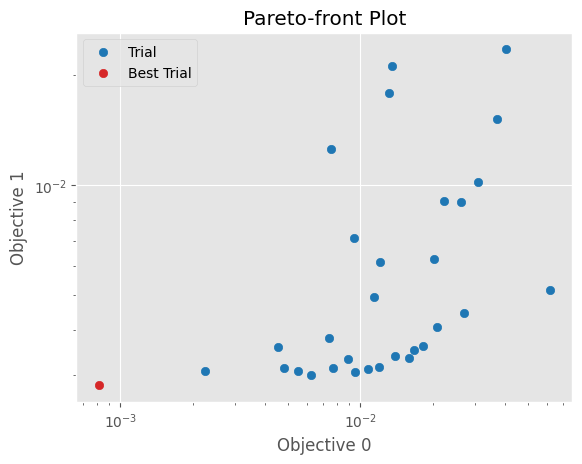

In [195]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial3.study)
plt.xscale('log')
plt.yscale('log')

In [196]:
for t in opt_trial3.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-12.985067564539557


In [197]:
for t in opt_trial3.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial3.motor_types:
        current_params.append(params[mot])
    opt_trial3._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial3.beam_state.photon_beam, xrange=opt_trial3._camera_xrange, yrange=opt_trial3._camera_yrange)

OSError: [Errno 24] Too many open files: '/dev/null'